## Ai For Route Planning Using DRL (PPO VS DDQN)

This Jupyter notebook presents a detailed simulation environment for an Unmanned Aerial Vehicle (UAV) navigation system using reinforcement learning techniques. The simulation is designed to optimize and evaluate UAV pathfinding capabilities in a controlled environment featuring obstacles and no-fly zones.

### Key Components:

1. **Custom Environment**: The simulation leverages a custom Gym environment tailored for UAV operations. This environment includes dynamic elements such as obstacles, no-fly zones, and a goal position that the UAV must navigate to.

2. **Deep Reinforcement Learning Models**:
    - **Proximal Policy Optimization (PPO)**: Implements the PPO algorithm to train an agent with a policy-based method, focusing on learning a policy that dictates the action to take based on the current state.
    - **Double Deep Q-Network (DDQN)**: Utilizes a value-based approach with a Q-network to estimate the optimal action-value function, with a target network to stabilize training.

3. **Simulation and Visualization**: The notebook includes functions to simulate UAV flights and visualize the paths taken by the UAV, helping to illustrate the effectiveness of the implemented learning algorithms.

4. **Evaluation and Hyperparameter Tuning**:
    - The performance of the models is assessed through the average rewards over multiple test episodes.
    - Hyperparameter optimization is conducted using Optuna to find the most effective learning rate, batch size, epsilon, and gamma values for the Q-network.

### Objectives:
The main objectives of this notebook are to:
- Develop and refine reinforcement learning models for autonomous UAV navigation.
- Visualize UAV paths to assess model performance.
- Optimize learning parameters to enhance UAV decision-making capabilities in complex environments.

This notebook serves as a comprehensive guide to applying advanced reinforcement learning techniques for UAV navigation, highlighting model development, training, evaluation, and optimization steps.


In [96]:
import gym  # Gym provides the environment and spaces definitions for reinforcement learning tasks.
from gym import spaces  # Spaces define the types of valid action and observation spaces available in Gym.

import numpy as np  # NumPy is used for numerical operations and handling arrays efficiently.

import matplotlib.pyplot as plt  # Pyplot from Matplotlib is used for creating static, interactive, and animated visualizations.
import matplotlib.patches as patches  # Patches are used for drawing shapes, useful for visualizing obstacles and no-fly zones.

from stable_baselines3 import PPO  # Stable Baselines3 provides the PPO algorithm, a modern reinforcement learning model.
from stable_baselines3.common.env_util import make_vec_env  # Utility to create vectorized environments.
from stable_baselines3.common.evaluation import evaluate_policy  # Utility for evaluating the performance of a policy.

import time  # Used for managing time-related tasks, such as delays between rendering frames.

from PIL import Image  # PIL is used for opening, manipulating, and saving many different image file formats.
from matplotlib.animation import FuncAnimation  # For creating animations, which are useful for visualizing the UAV's path.

import tensorflow as tf  # TensorFlow is used for building and training the neural network models.

from collections import deque  # Deque is a double-ended queue, useful for implementing efficient queues and stacks.
import random  # Provides functionalities for generating random numbers, crucial for stochastic processes in simulations.

import optuna  # Optuna is an optimization framework used for automating hyperparameter tuning tasks.


In [81]:
class UAVEnv(gym.Env):
    """Custom Environment that follows gym interface for a UAV."""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, goal_position=np.array([10, 10, 10]), max_steps=100):
        super(UAVEnv, self).__init__()
        """
        Initializes the UAV environment.

        Parameters:
        - goal_position (np.array): The goal position for the UAV to reach.
        - max_steps (int): Maximum number of steps allowed in the environment.
        """
        
        # Bounds of the environment including z-axis
        self.env_bounds = (15, 15, 30)  
        self.goal_position = goal_position
        self.max_steps = max_steps
        self.current_step = 0
        
        # Initial state: x, y, z, dx, dy, dz
        self.state = np.array([0, 0, 0, 0, 0, 0])  
        self.previous_distance = np.linalg.norm(self.state[:3] - self.goal_position)
        self.path = []
        
        # Adding no-fly zones
        self.no_fly_zones = [
            {'type': 'rectangle', 'position': (7.5, 2.5, 15), 'width': 2, 'height': 2, 'depth': 15}
        ]
        self.obstacles = [
            {'type': 'rectangle', 'position': (2, 2, 15), 'width': 1, 'height': 1, 'depth': 15},
            {'type': 'circle', 'position': (7.5, 7.5, 20), 'radius': 1, 'depth': 20},
            {'type': 'ellipse', 'position': (2.5, 7.5, 25), 'width': 2, 'height': 1, 'depth': 25}
        ]
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Box(low=np.array([-10, -10, 0, -1, -1, -1]),
                                            high=np.array([10, 10, 30, 1, 1, 1]),
                                            dtype=np.float32)

    def step(self, action):
        """
        Executes one step within the environment.

        Parameters:
        - action (int): The action to be taken.

        Returns:
        - state (np.array): The new state after taking the action.
        - reward (float): The reward obtained from taking the action.
        - done (bool): Whether the episode is done or not.
        - info (dict): Additional information.
        """
        reward = 0
        done = False
        
        self._take_action(action)
        self.current_step += 1
        self.path.append(self.state[:3].copy())
        done = self._is_done()
        reward = self._get_reward()
        
        # Logic to handle no-fly zones
        for zone in self.no_fly_zones:
            if self._in_no_fly_zone(self.state[:3], zone):
                reward -= 100  # Large penalty for entering no-fly zone
                done = True
        
        return np.array(self.state), reward, done, {}

    def reset(self):
        """
        Resets the environment to its initial state.

        Returns:
        - state (np.array): The initial state.
        """
        self.current_step = 0
        self.state = np.array([0, 0, 0, 0, 0, 0])  # Reset state
        self.previous_distance = np.linalg.norm(self.state[:3] - self.goal_position)
        self.path = []
        return np.array(self.state)

    
    """        #used for the PPO Model to download the GIF. Uncomment lines to use
    def render(self, mode='human'):
        if mode == 'human':
            #x = latitude, y = longitude, and z is the altitude.
            x, y, z, dx, dy, dz = self.state
            fig, ax = plt.subplots(figsize=(10, 10))

            # Goal and UAV positions
            ax.scatter(self.goal_position[0], self.goal_position[1], c='red', s=100, label='Goal', alpha=0.5)
            ax.scatter(x, y, c='blue', s=100, label='UAV', alpha=0.5)

            # UAV Path
            if self.path:
                path_array = np.array(self.path)
                ax.plot(path_array[:, 0], path_array[:, 1], label='Path', color='blue', alpha=0.6)

            # Axis limits
            ax.set_xlim(self.observation_space.low[0], self.observation_space.high[0])
            ax.set_ylim(self.observation_space.low[1], self.observation_space.high[1])

            # Labels and Title
            ax.set_xlabel('Latitude')
            ax.set_ylabel('Longitude')
            ax.set_title('UAV Navigation Environment')

            # Obstacles rendering
            for obstacle in self.obstacles:
                self._plot_obstacle(ax, obstacle, 'red')

            # No-fly zones rendering with a different color
            for zone in self.no_fly_zones:
                self._plot_obstacle(ax, zone, 'purple')  # Visualizing no-fly zones distinctly

            # Legend and Grid
            ax.legend()
            ax.grid(True)
            plt.show()"""
        
        #Used for the DDQN Model to download the Image. comment these lines to use the above PPO render function.
    def render(self, mode='rgb_array'):
        """
        Renders the environment.

        Parameters:
        - mode (str): Rendering mode ('rgb_array' for rendering to NumPy array).

        Returns:
        - frame (np.ndarray): Rendered frame as a NumPy array.
        """
        if mode == 'rgb_array':
            #x = latitude, y = longitude, and z is the altitude.
            x, y, z, dx, dy, dz = self.state
            fig, ax = plt.subplots(figsize=(10, 10))

            # Goal and UAV positions
            ax.scatter(self.goal_position[0], self.goal_position[1], c='red', s=100, label='Goal', alpha=0.5)
            ax.scatter(x, y, c='blue', s=100, label='UAV', alpha=0.5)

            # UAV Path
            if self.path:
                path_array = np.array(self.path)
                ax.plot(path_array[:, 0], path_array[:, 1], label='Path', color='blue', alpha=0.6)

            # Axis limits
            ax.set_xlim(self.observation_space.low[0], self.observation_space.high[0])
            ax.set_ylim(self.observation_space.low[1], self.observation_space.high[1])

            # Labels and Title
            ax.set_xlabel('Latitude')
            ax.set_ylabel('Longitude')
            ax.set_title('UAV Navigation Environment')

            # Obstacles rendering
            for obstacle in self.obstacles:
                self._plot_obstacle(ax, obstacle, 'red')

            # No-fly zones rendering with a different color
            for zone in self.no_fly_zones:
                self._plot_obstacle(ax, zone, 'purple')  # Visualizing no-fly zones distinctly

            # Legend and Grid
            ax.legend()
            ax.grid(True)

            # Convert the plot to a NumPy array
            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer.buffer_rgba())
            plt.close(fig)

            return frame

        elif mode == 'human':
            # Render the environment using Matplotlib
            plt.show()
            
    
        

    def _plot_obstacle(self, ax, obstacle, color):
        """
        Helper function to plot obstacles.

        Parameters:
        - ax (matplotlib.axes.Axes): The matplotlib axes object.
        - obstacle (dict): Dictionary containing obstacle information.
        - color (str): Color of the obstacle.
        """
        if obstacle['type'] == 'rectangle':
            rect = patches.Rectangle((obstacle['position'][0] - obstacle['width']/2,
                                      obstacle['position'][1] - obstacle['height']/2),
                                     obstacle['width'], obstacle['height'],
                                     linewidth=1, edgecolor=color, facecolor=color, alpha=0.3)
            ax.add_patch(rect)
        elif obstacle['type'] == 'circle':
            circle = patches.Circle((obstacle['position'][0], obstacle['position'][1]),
                                    obstacle['radius'], linewidth=1,
                                    edgecolor=color, facecolor=color, alpha=0.3)
            ax.add_patch(circle)
        elif obstacle['type'] == 'ellipse':
            ellipse = patches.Ellipse((obstacle['position'][0], obstacle['position'][1]),
                                      obstacle['width'], obstacle['height'],
                                      linewidth=1, edgecolor=color, facecolor=color, alpha=0.3)
            ax.add_patch(ellipse)
            
            
            
    def _detect_collision(self, new_position):
        """
        Detects collision between the UAV and obstacles.

        Parameters:
        - new_position (np.array): The new position of the UAV.

        Returns:
        - collision (bool): True if collision detected, False otherwise.
        """
        for obstacle in self.obstacles:
            # Collision detection for rectangle
            if obstacle['type'] == 'rectangle':
                rect_min_x = obstacle['position'][0] - obstacle['width'] / 2
                rect_max_x = obstacle['position'][0] + obstacle['width'] / 2
                rect_min_y = obstacle['position'][1] - obstacle['height'] / 2
                rect_max_y = obstacle['position'][1] + obstacle['height'] / 2
                if rect_min_x <= new_position[0] <= rect_max_x and rect_min_y <= new_position[1] <= rect_max_y:
                    return True
            # Collision detection for circle
            elif obstacle['type'] == 'circle':
                distance = np.linalg.norm(np.array(obstacle['position'][:2]) - new_position[:2])
                if distance <= obstacle['radius']:
                    return True
            # Collision detection for ellipse
            elif obstacle['type'] == 'ellipse':
                # Simplified ellipse detection
                distance = np.linalg.norm(np.array(obstacle['position'][:2]) - new_position[:2])
                if distance <= max(obstacle['width'], obstacle['height']):
                    return True
        return False

    def _take_action(self, action):
        """
        Takes action based on the given action.

        Parameters:
        - action (int): The action to be taken by the UAV.
        """
        x, y, z, dx, dy, dz = self.state
        speed_change = 0.1
        if action == 0: dz += speed_change
        elif action == 1: dz -= speed_change
        elif action == 2: dx -= speed_change
        elif action == 3: dx += speed_change
        elif action == 4: dy += speed_change
        elif action == 5: dy -= speed_change
        damping_factor = 0.95
        dx *= damping_factor
        dy *= damping_factor
        dz *= damping_factor
        x += dx
        y += dy
        z += dz
        x = np.clip(x, self.observation_space.low[0], self.observation_space.high[0])
        y = np.clip(y, self.observation_space.low[1], self.observation_space.high[1])
        z = np.clip(z, self.observation_space.low[2], self.observation_space.high[2])
        self.state = np.array([x, y, z, dx, dy, dz])

        # New position based on current action
        new_position = np.array([x + dx, y + dy, z + dz])
        
        # Check for collision
        if self._detect_collision(new_position):
            # Handle collision (e.g., reset position, apply penalty, etc.)
            print("Collision detected! Taking avoidance measures.")
            # For example, undo the move which causes the collision
            dx = dy = dz = 0
        else:
            # Update state only if no collision
            self.state = np.array([x + dx, y + dy, z + dz, dx, dy, dz])

    def _get_proximity_penalty(self, current_position):
        """
        Computes the penalty for proximity to obstacles.

        Parameters:
        - current_position (np.array): Current position of the UAV.

        Returns:
        - penalty (float): The proximity penalty.
        """
        penalty = 0
        # Define a minimum safe distance
        safe_distance = 1.0
    
        for obstacle in self.obstacles:
            # Check proximity for rectangles
            if obstacle['type'] == 'rectangle':
                rect_min_x = obstacle['position'][0] - obstacle['width'] / 2 - safe_distance
                rect_max_x = obstacle['position'][0] + obstacle['width'] / 2 + safe_distance
                rect_min_y = obstacle['position'][1] - obstacle['height'] / 2 - safe_distance
                rect_max_y = obstacle['position'][1] + obstacle['height'] / 2 + safe_distance
                if rect_min_x <= current_position[0] <= rect_max_x and rect_min_y <= current_position[1] <= rect_max_y:
                    penalty += (safe_distance - min(abs(current_position[0] - rect_min_x),
                                                    abs(current_position[0] - rect_max_x),
                                                    abs(current_position[1] - rect_min_y),
                                                    abs(current_position[1] - rect_max_y)))
    
            # Proximity check for circles
            elif obstacle['type'] == 'circle':
                distance = np.linalg.norm(np.array(obstacle['position'][:2]) - current_position[:2])
                if distance < obstacle['radius'] + safe_distance:
                    penalty += (obstacle['radius'] + safe_distance - distance)
    
            # Proximity check for ellipses
            elif obstacle['type'] == 'ellipse':
                # Simplified ellipse proximity check
                distance = np.linalg.norm(np.array(obstacle['position'][:2]) - current_position[:2])
                if distance < max(obstacle['width'], obstacle['height']) + safe_distance:
                    penalty += (max(obstacle['width'], obstacle['height']) + safe_distance - distance)
    
        return penalty

    
    def _get_reward(self):
        """
        Computes the reward for the current state.

        Returns:
        - reward (float): The reward for the current state.
        """
        current_position = self.state[:3]
        goal_distance = np.linalg.norm(current_position - self.goal_position)
        if self.current_step == 0:
            self.previous_distance = goal_distance
        reward = self.previous_distance - goal_distance
        self.previous_distance = goal_distance
        speed_penalty = -np.linalg.norm(self.state[3:]) * 0.05
        if goal_distance < 1:
            reward += 100  # Large reward for reaching the goal
        return reward + speed_penalty

        # Check if UAV is too close to any obstacles and apply a penalty
        penalty_for_proximity_to_obstacles = -10 if self._detect_collision(self.state[:3]) else 0
    
        return reward + speed_penalty + penalty_for_proximity_to_obstacles

        proximity_penalty = self._get_proximity_penalty(self.state[:3])
        return reward + speed_penalty - proximity_penalty

    def _is_done(self):
        """
        Checks if the episode is done.

        Returns:
        - done (bool): True if the episode is done, False otherwise.
        """
        current_position = self.state[:3]
        goal_distance = np.linalg.norm(current_position - self.goal_position)
        if goal_distance < 1:
            print("Goal reached!")
            return True
        if self.current_step >= self.max_steps:
            print("Max steps exceeded.")
            return True

        if self._detect_collision(self.state[:3]):
            print("Collision with an obstacle!")
            return True
        return False
    
    def _in_no_fly_zone(self, position, zone):
        """
        Checks if the given position is within a specified no-fly zone.

        Parameters:
        - position (tuple): The position to be checked (x, y, z).
        - zone (dict): The definition of the no-fly zone.

        Returns:
        - in_zone (bool): True if the position is within the no-fly zone, False otherwise.
        """
        x, y, z = position
        zx, zy, zz = zone['position']

        if zone['type'] == 'rectangle':
            return (zx - zone['width']/2 <= x <= zx + zone['width']/2 and
                    zy - zone['height']/2 <= y <= zy + zone['height']/2 and
                    0 <= z <= zz)
        elif zone['type'] == 'circle':
            # Check if the point is within the radius of the circle on the xy-plane
            distance = np.sqrt((x - zx)**2 + (y - zy)**2)
            return distance <= zone['radius'] and 0 <= z <= zz
        elif zone['type'] == 'ellipse':
            # Check if the point is within the ellipse on the xy-plane
            distance = ((x - zx)**2 / (zone['width']/2)**2) + ((y - zy)**2 / (zone['height']/2)**2)
            return distance <= 1 and 0 <= z <= zz

        return False


    def seed(self, seed=None):
        """
        Sets the seed for the random number generator.

        Parameters:
        - seed (int or None): The seed value. If None, the seed is not set.
        """
        np.random.seed(seed)


C:\Users\ammar\myuav\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


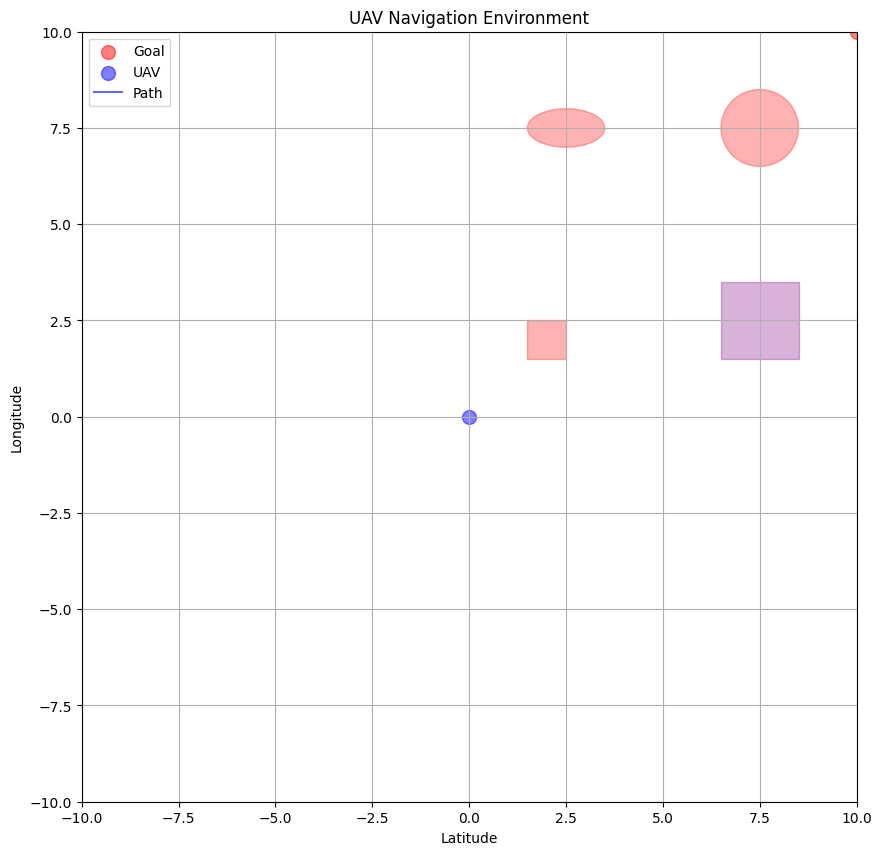

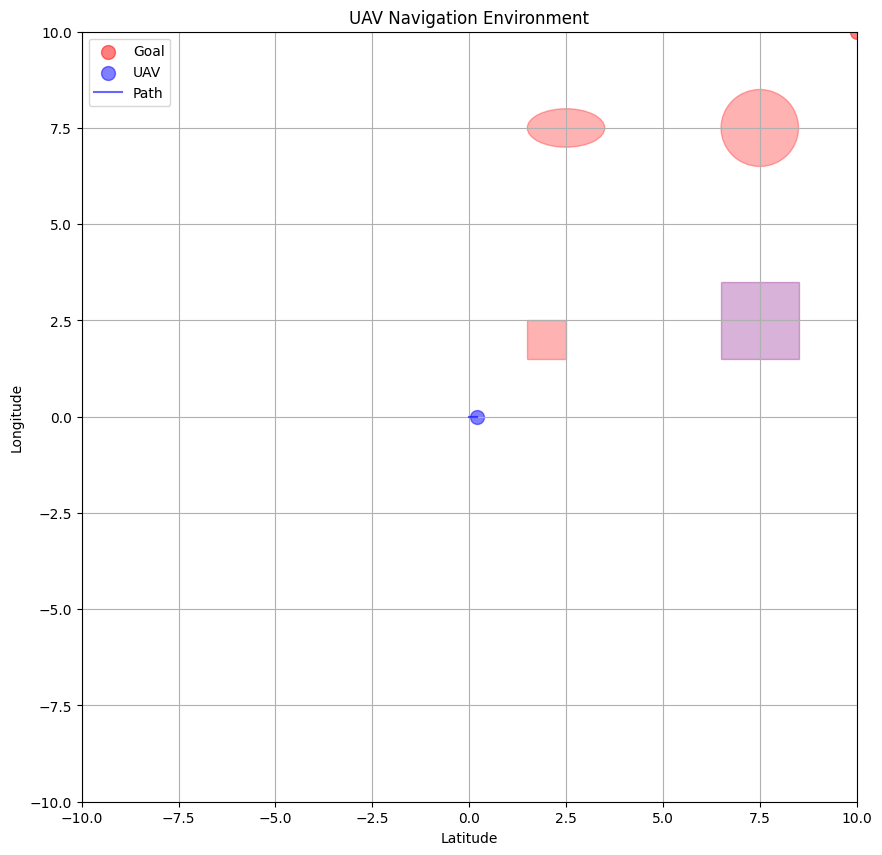

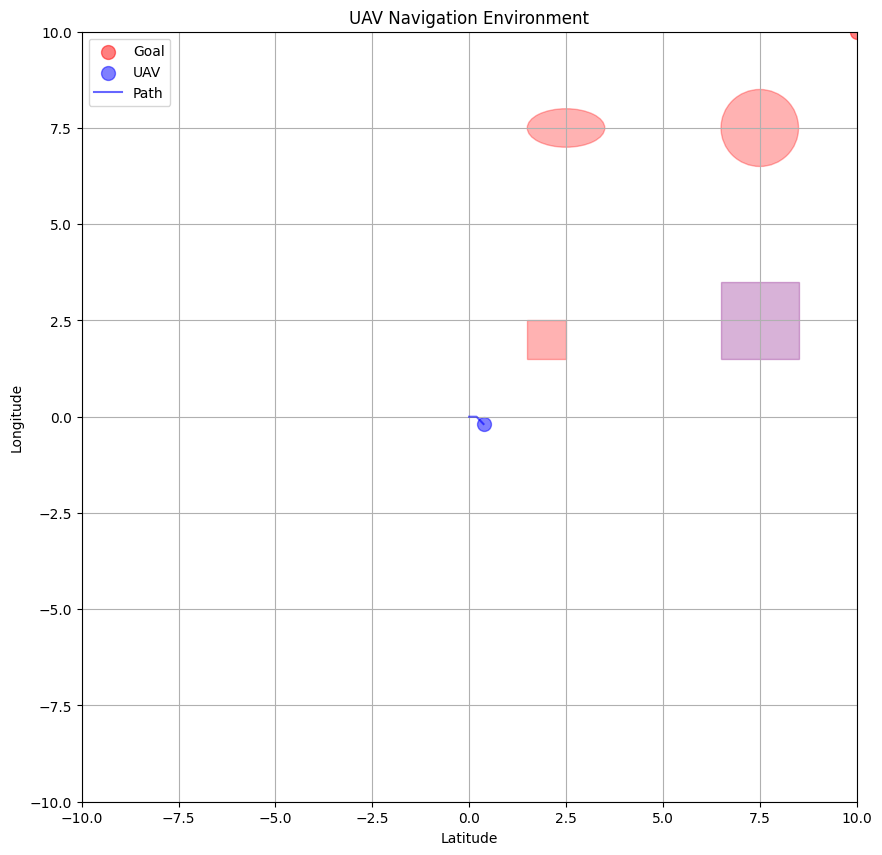

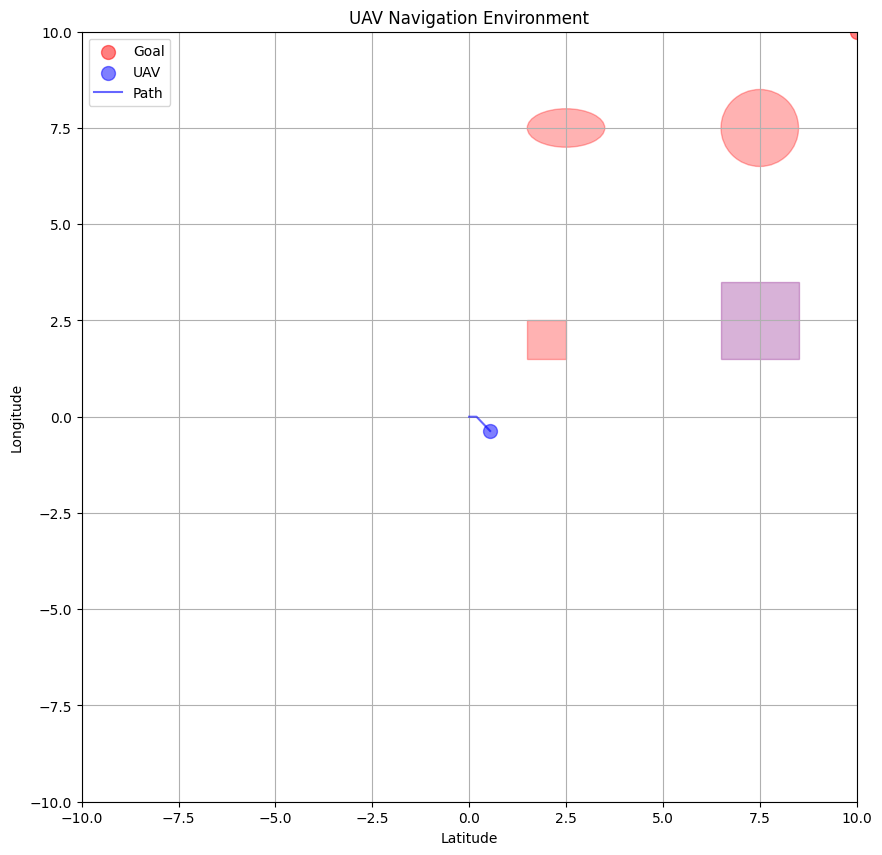

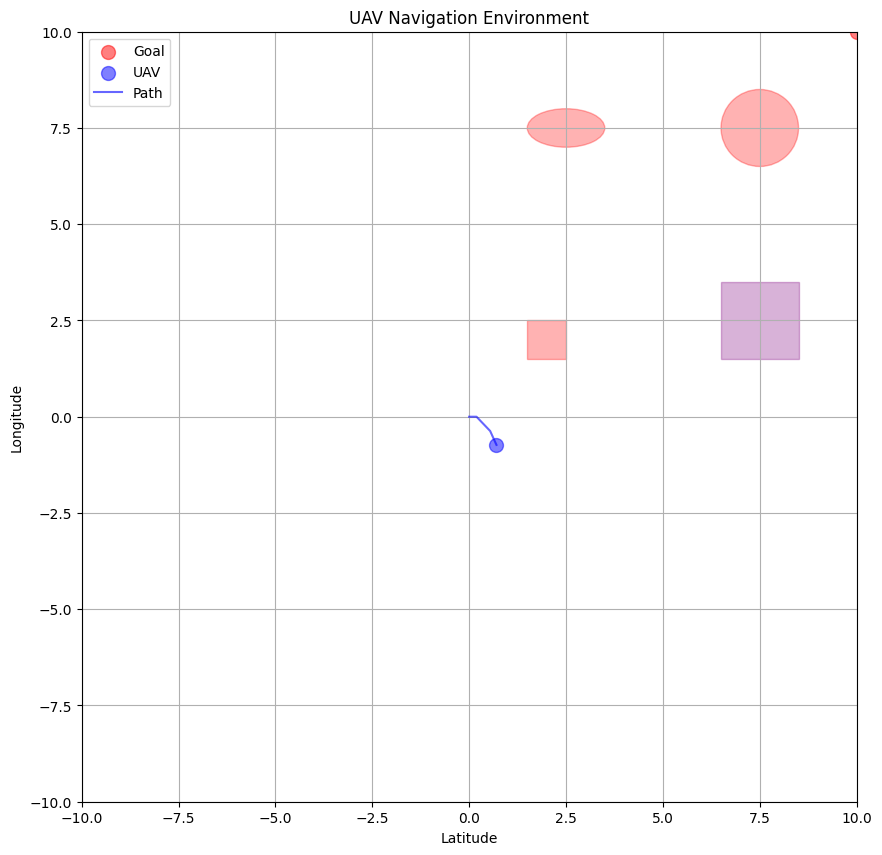

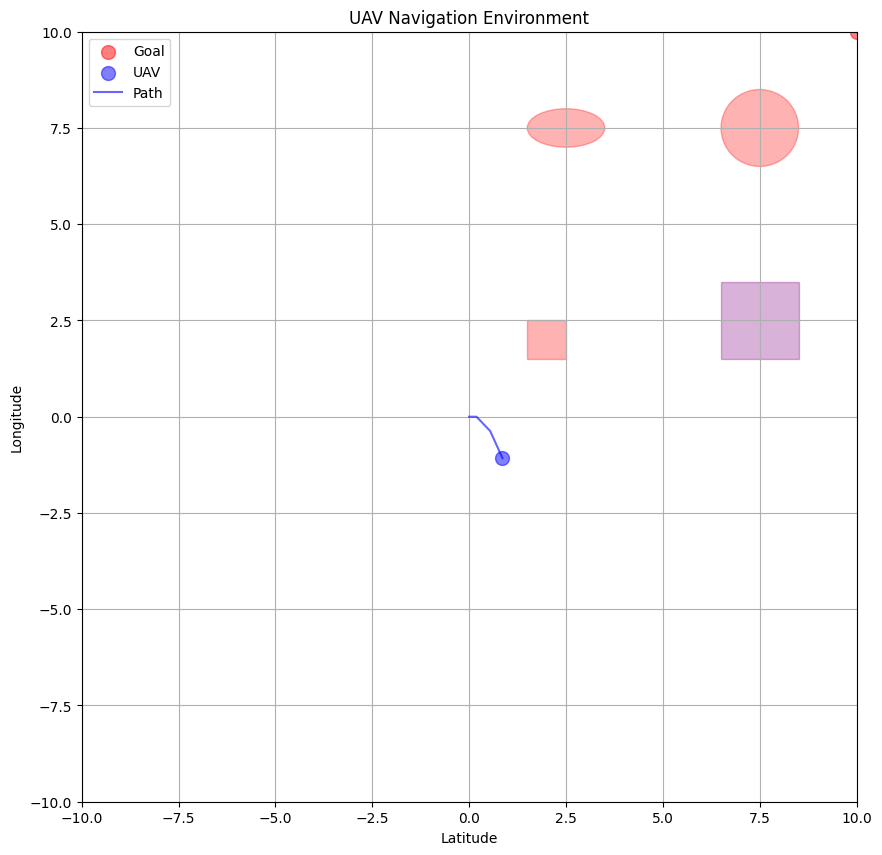

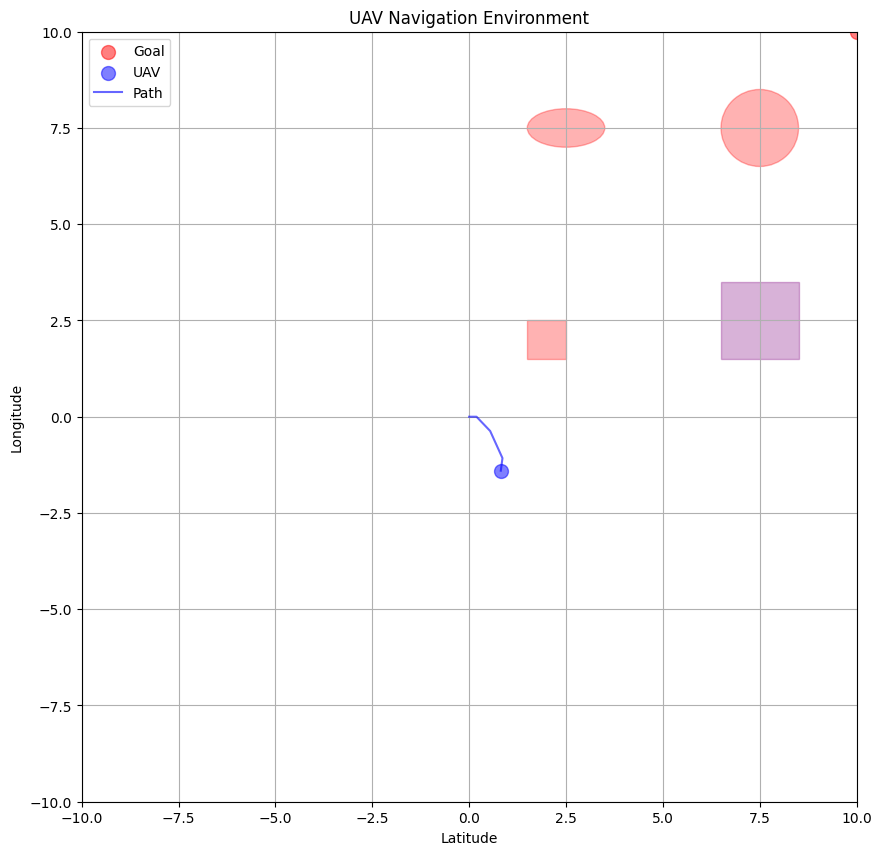

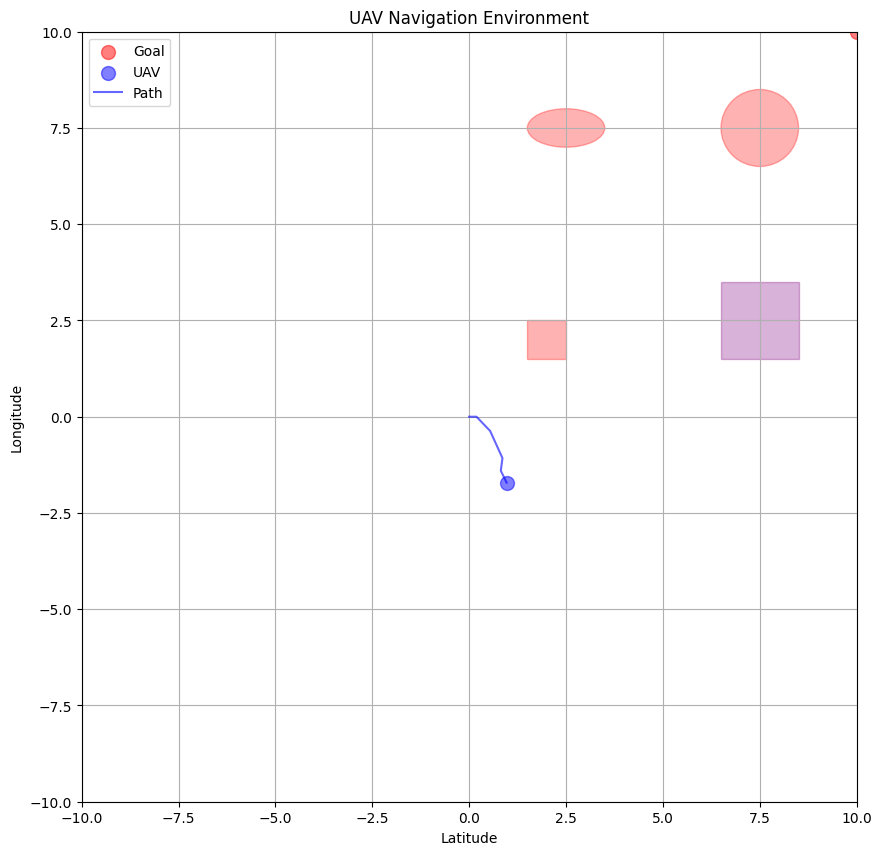

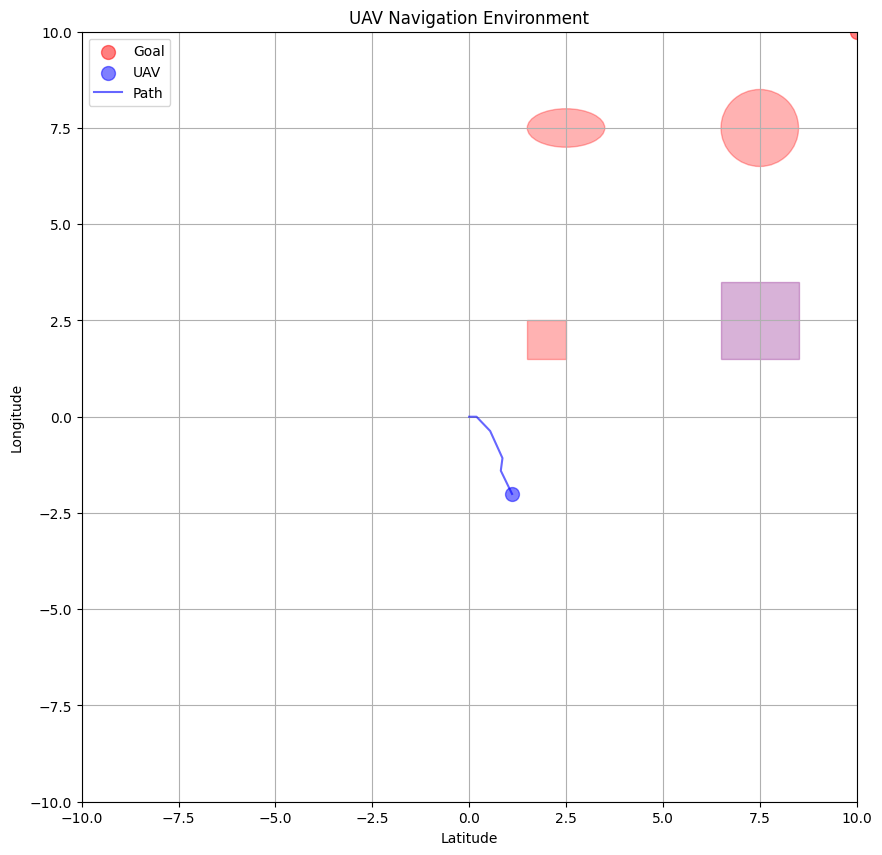

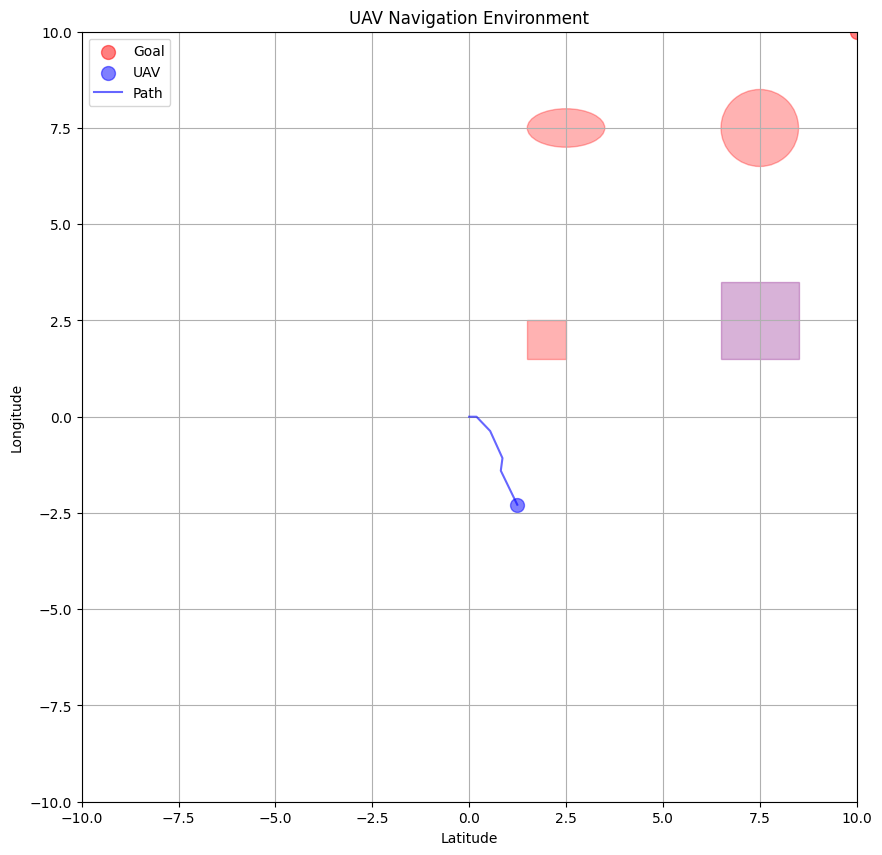

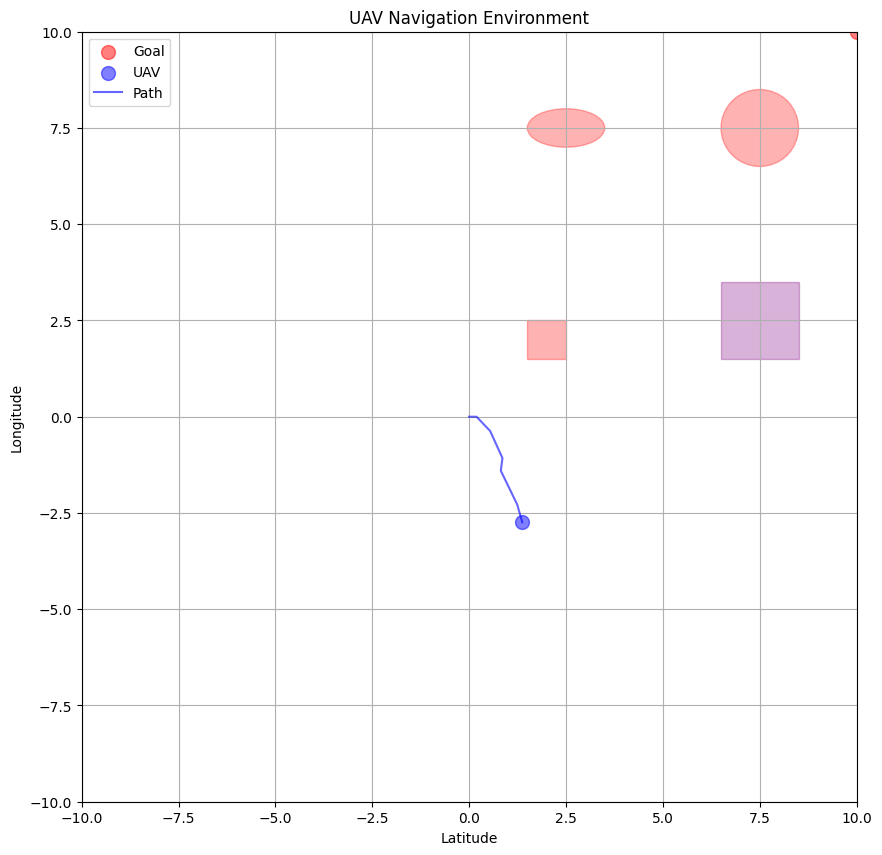

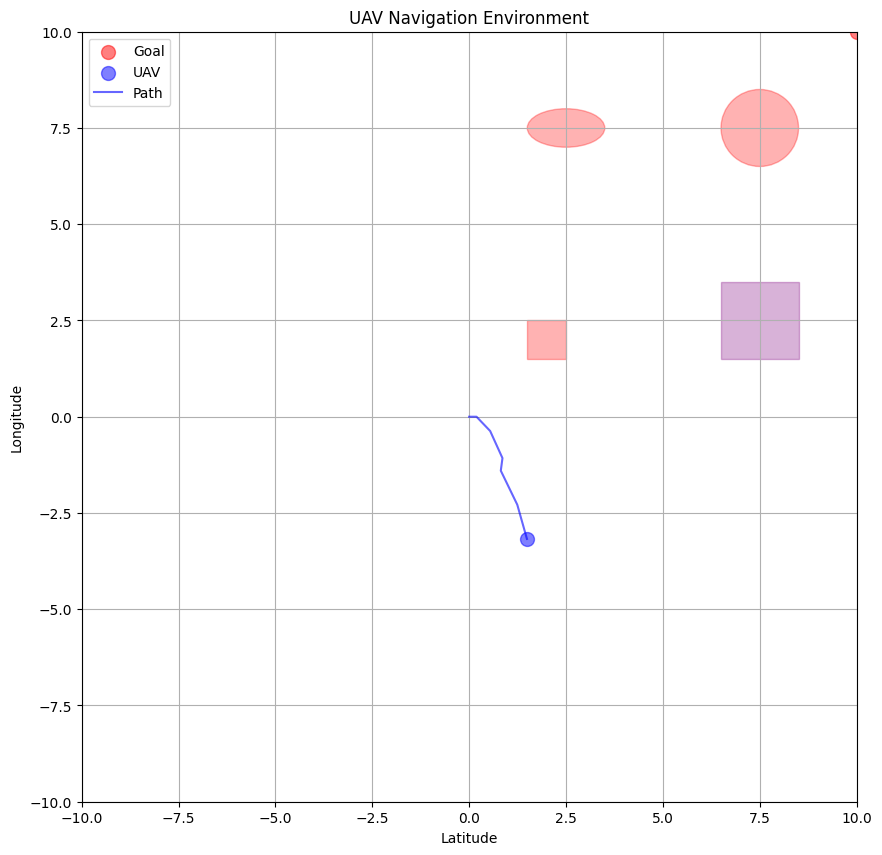

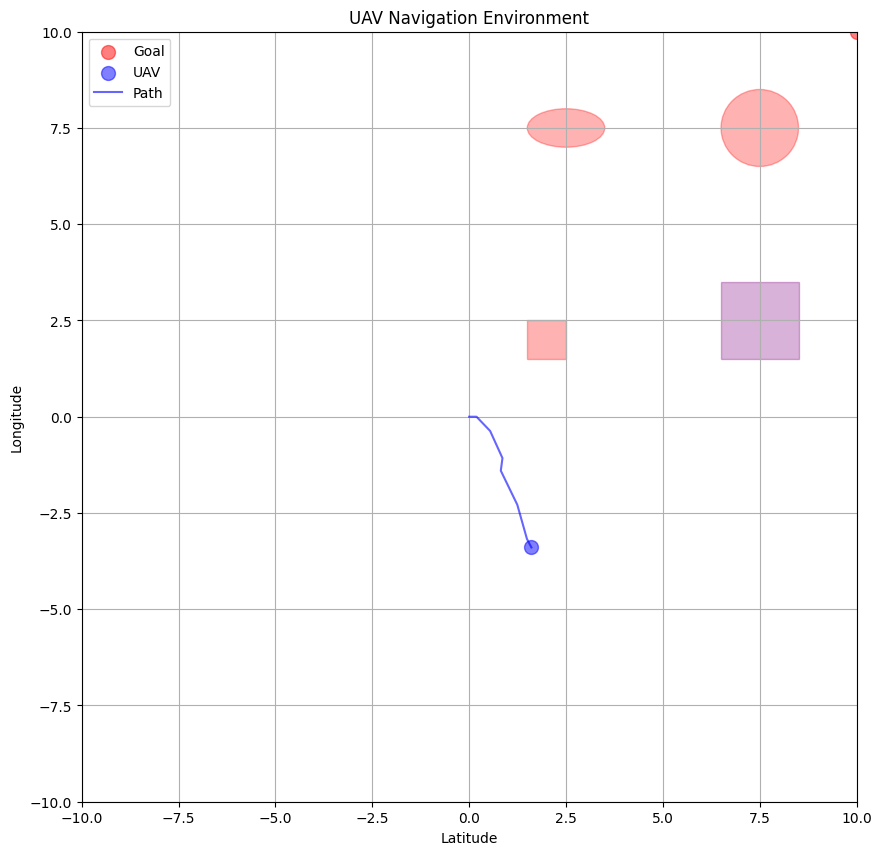

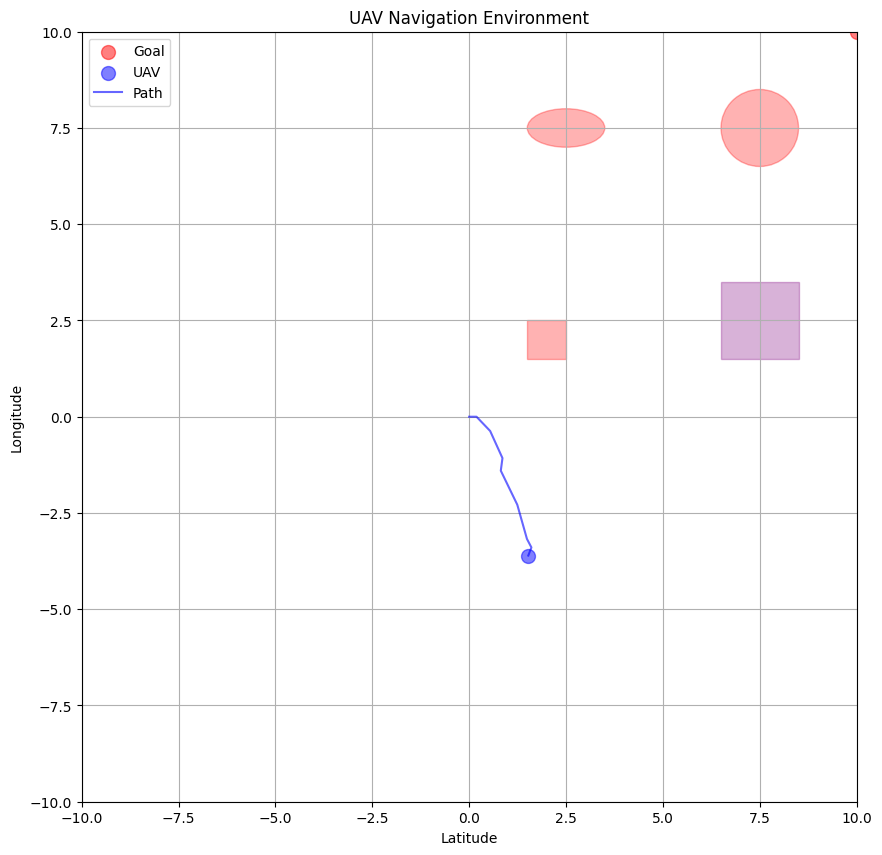

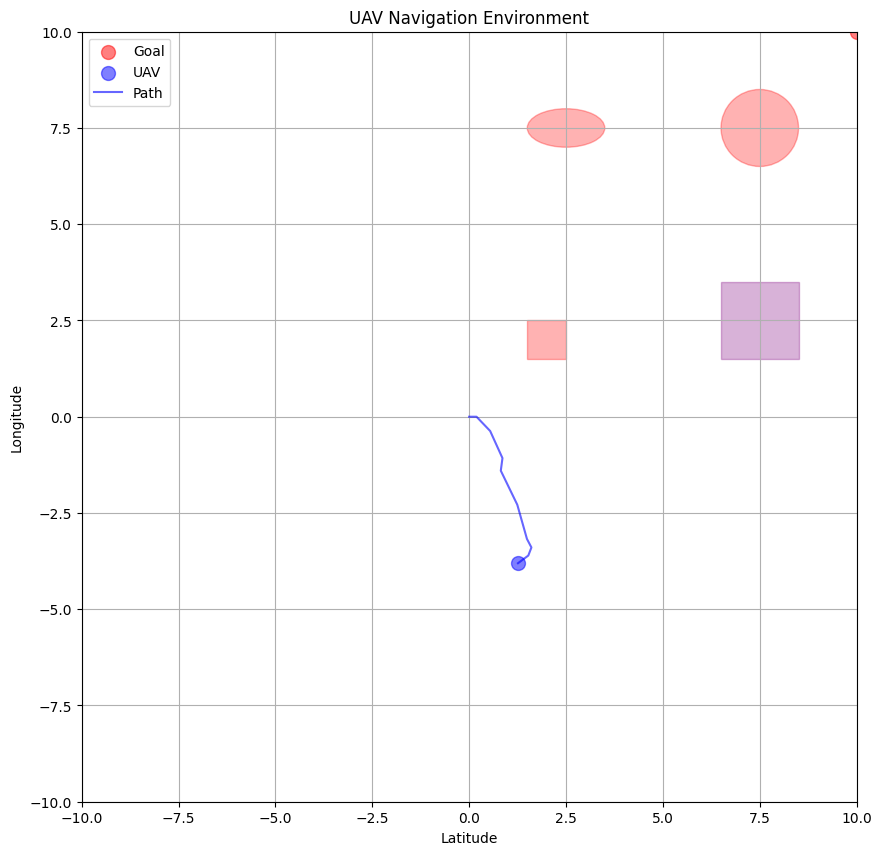

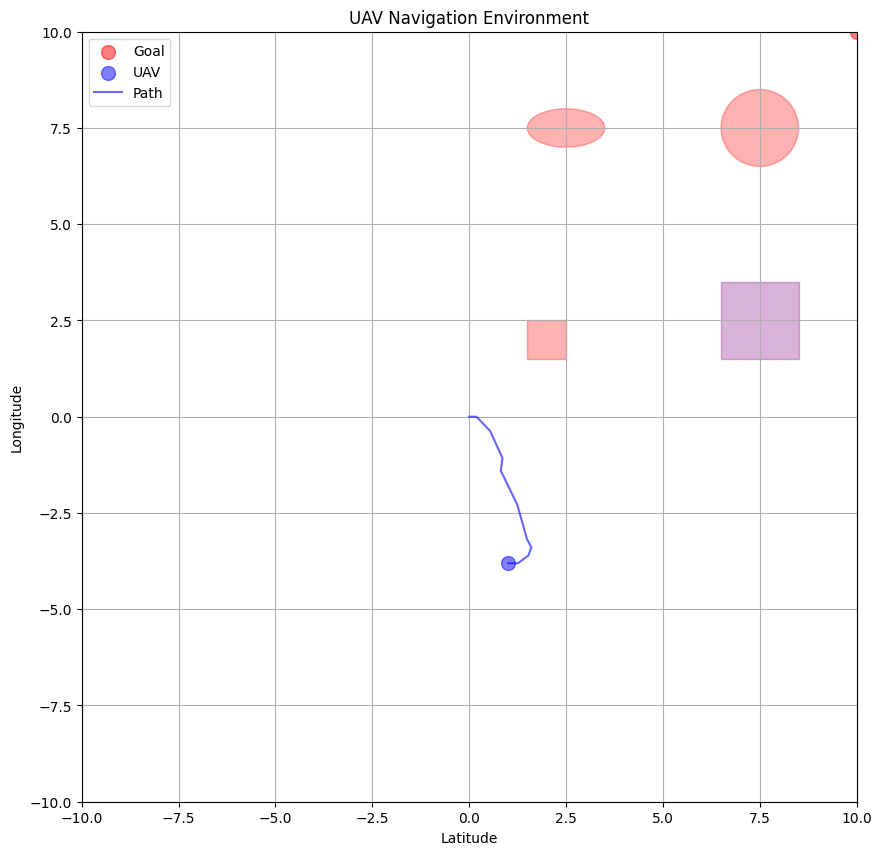

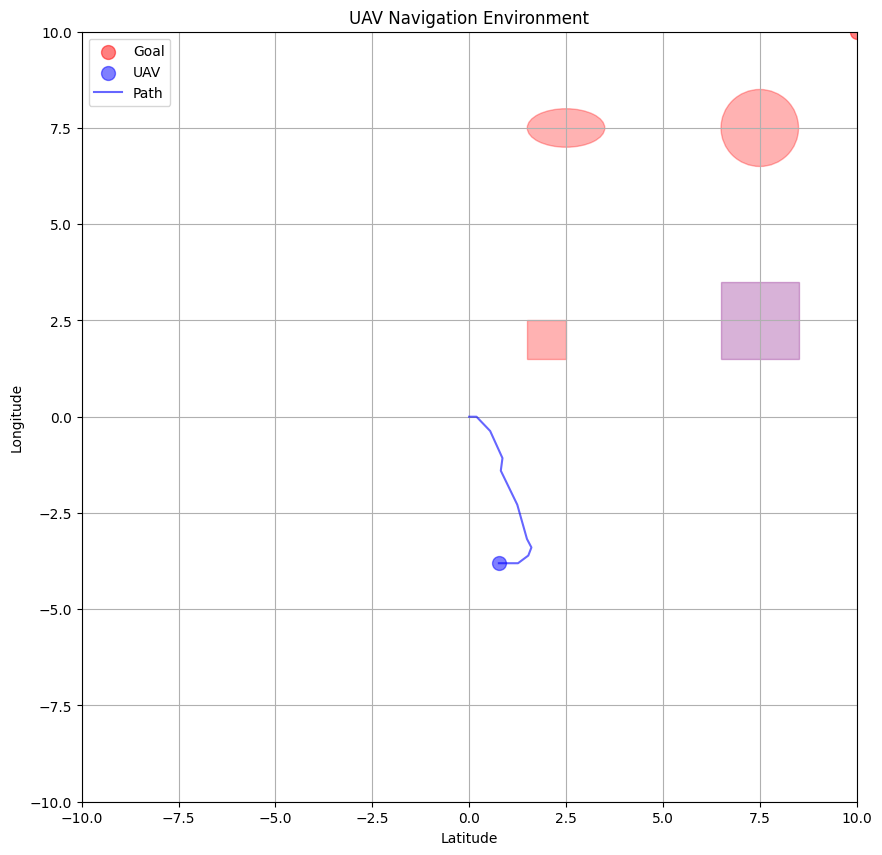

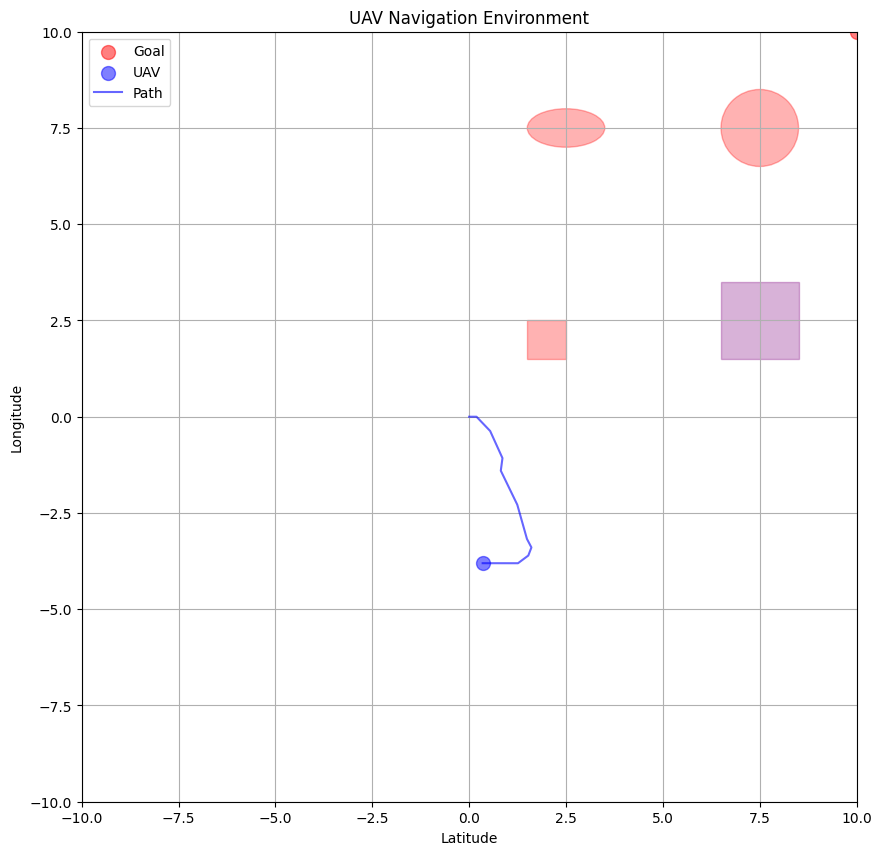

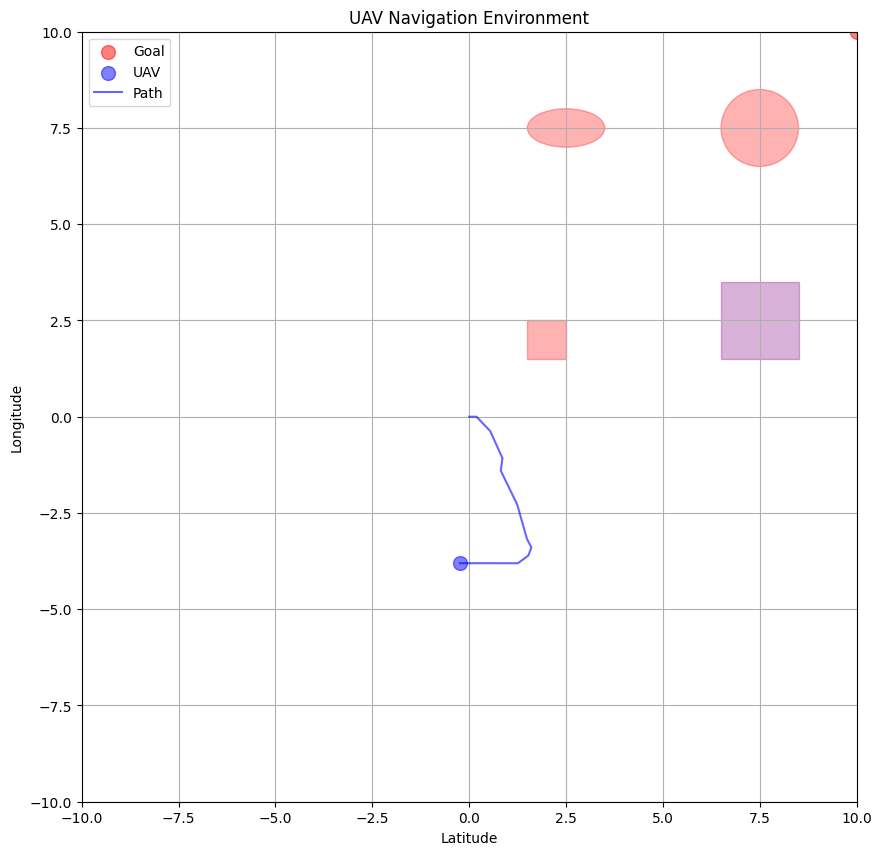

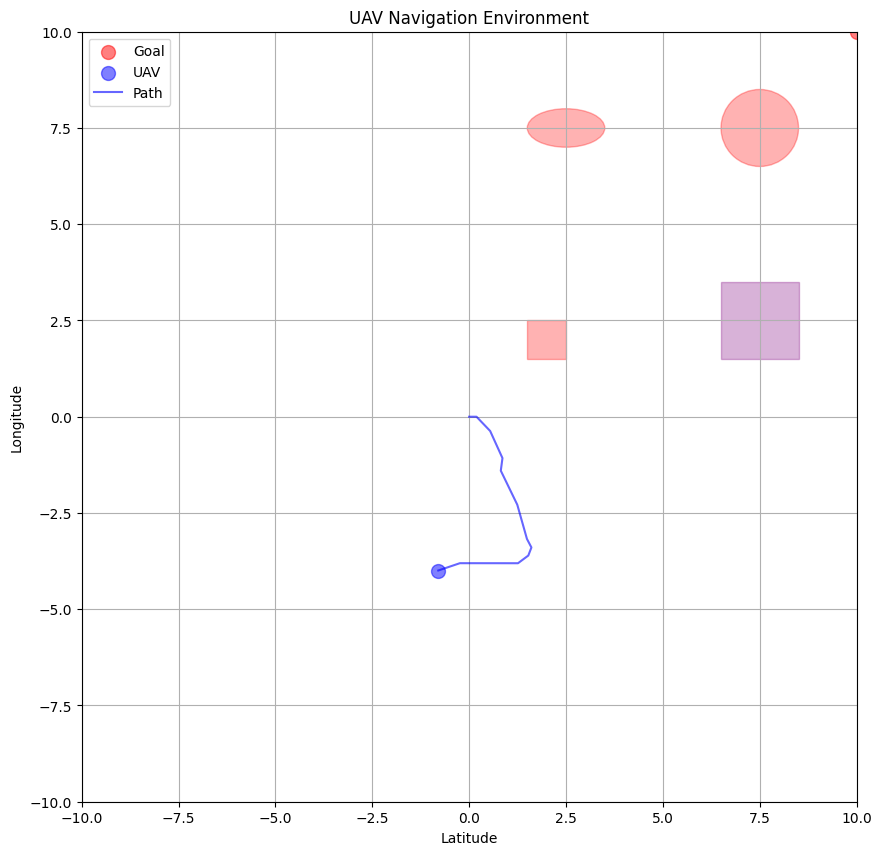

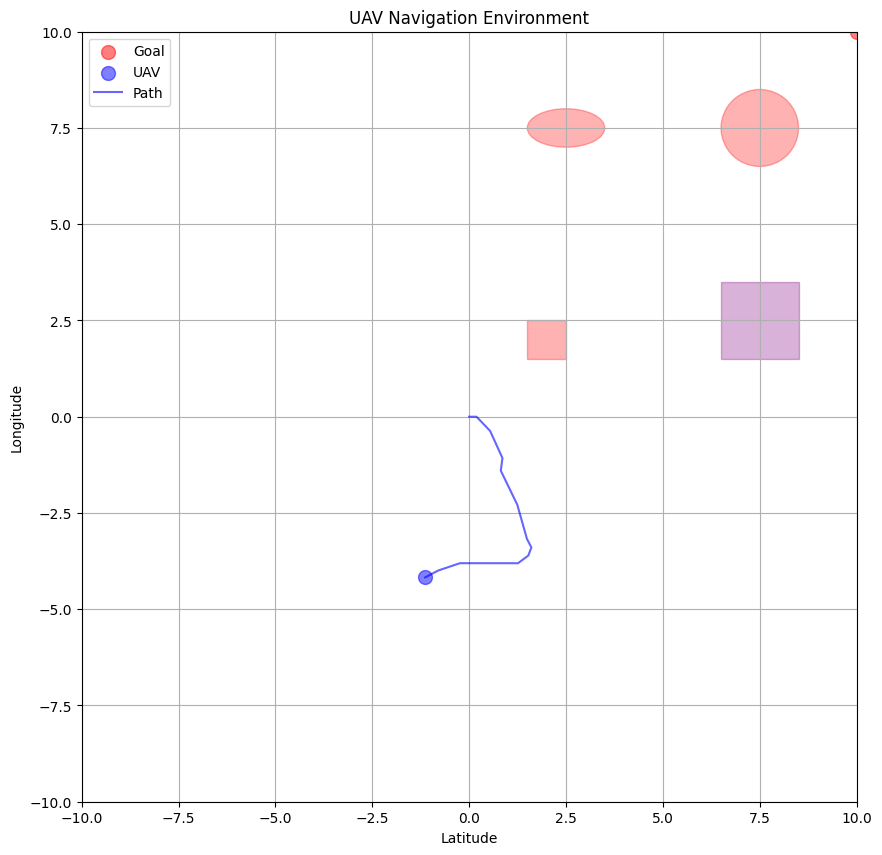

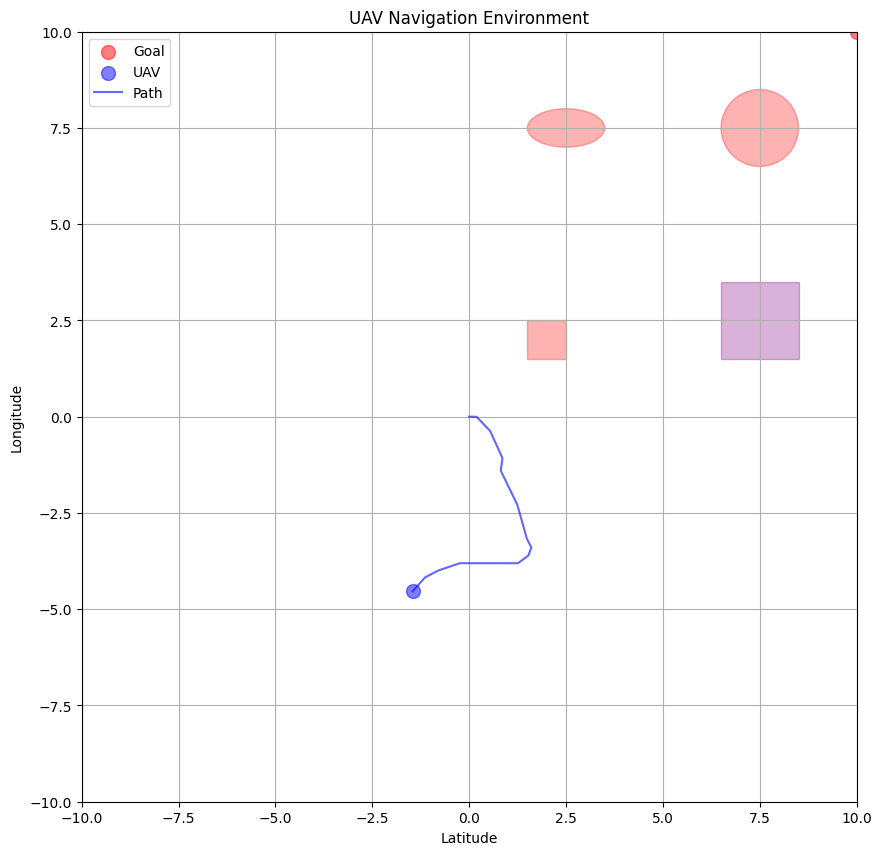

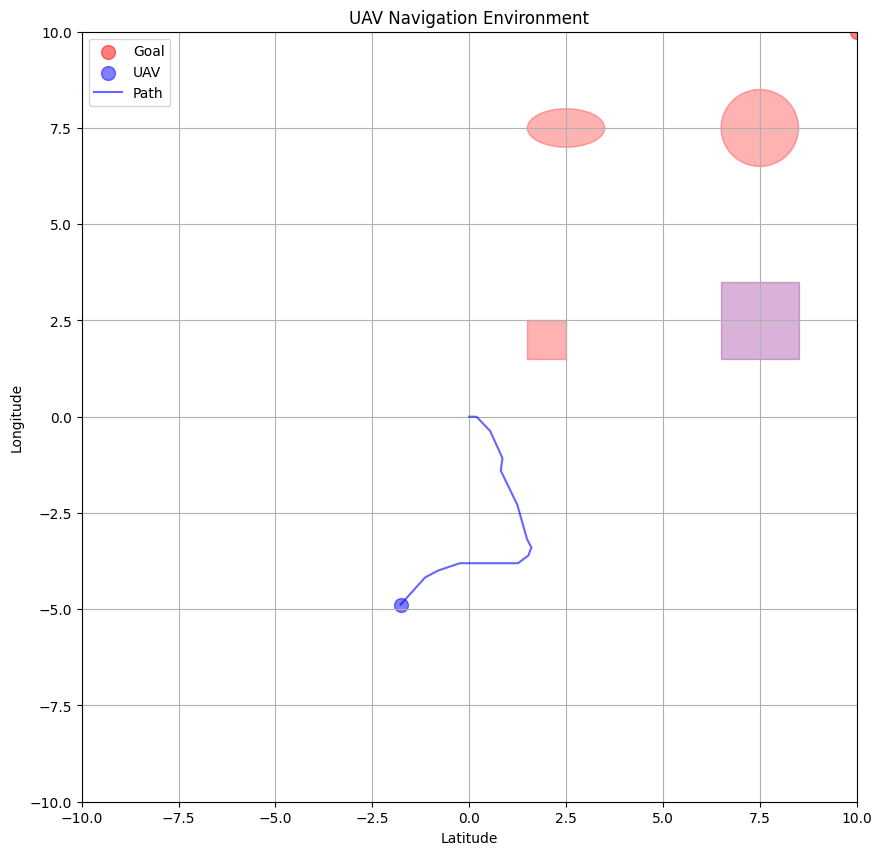

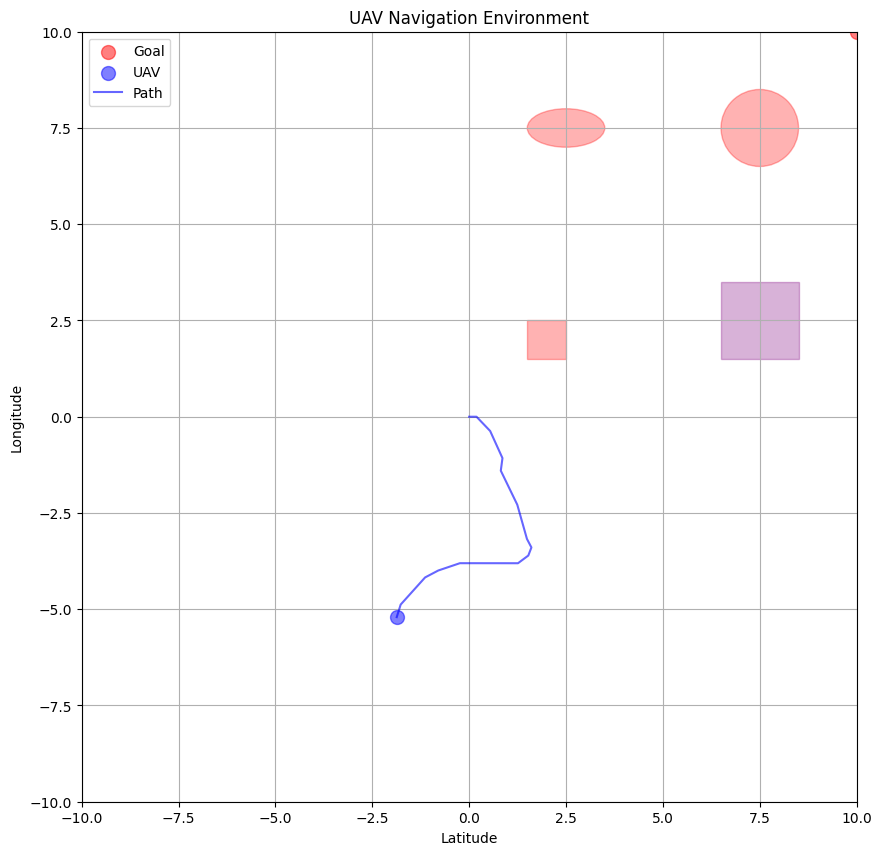

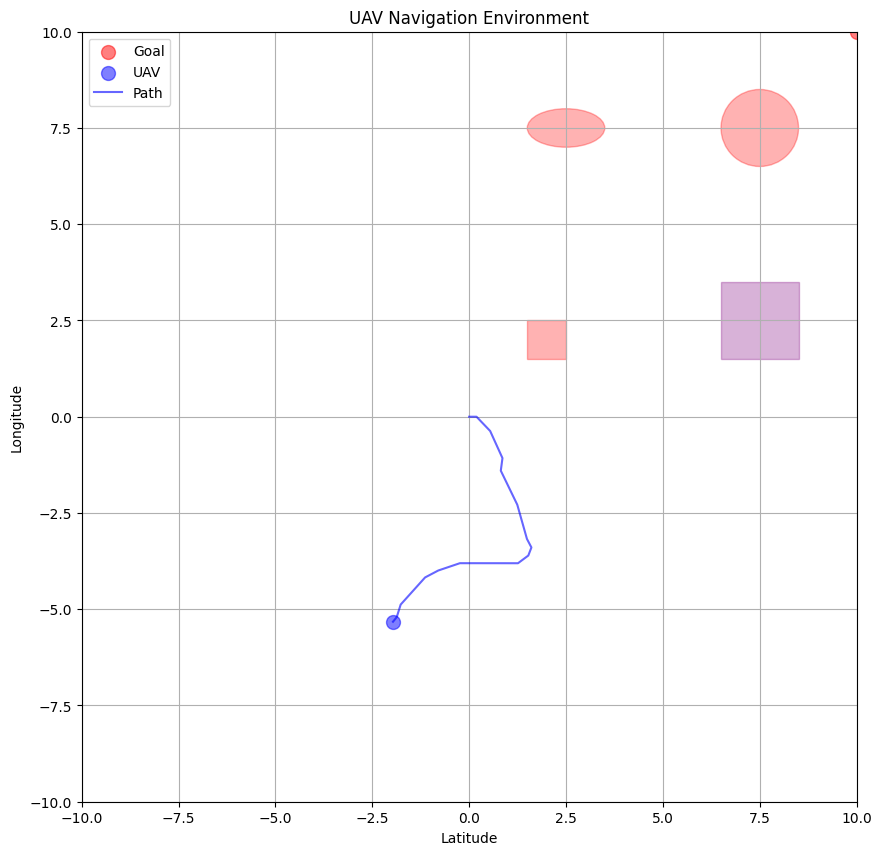

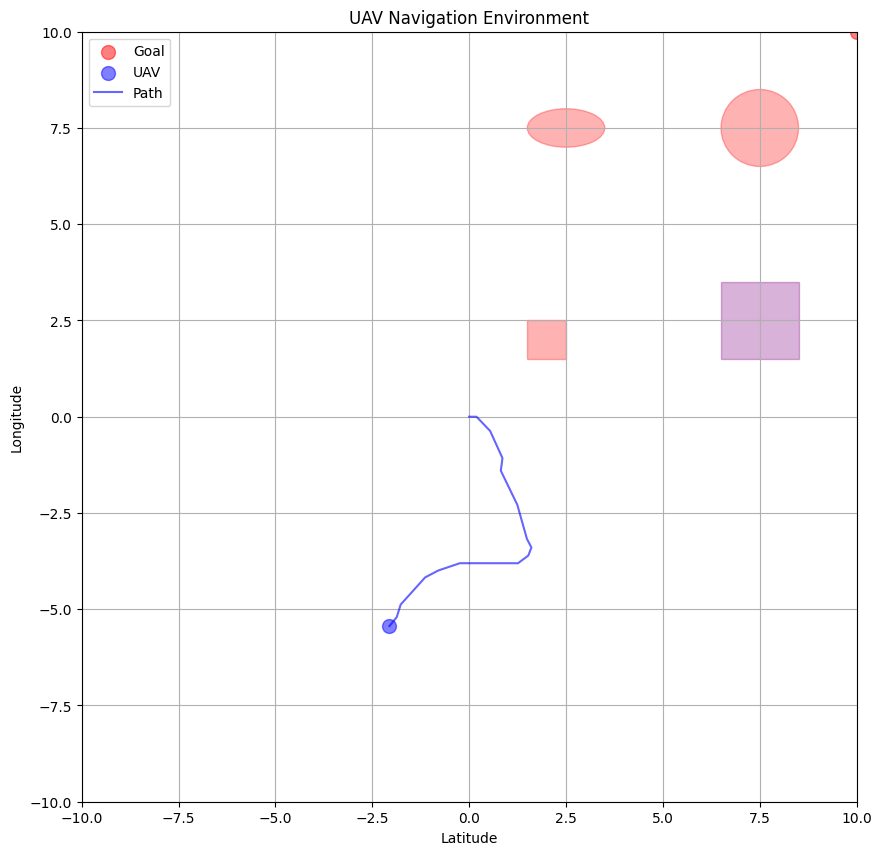

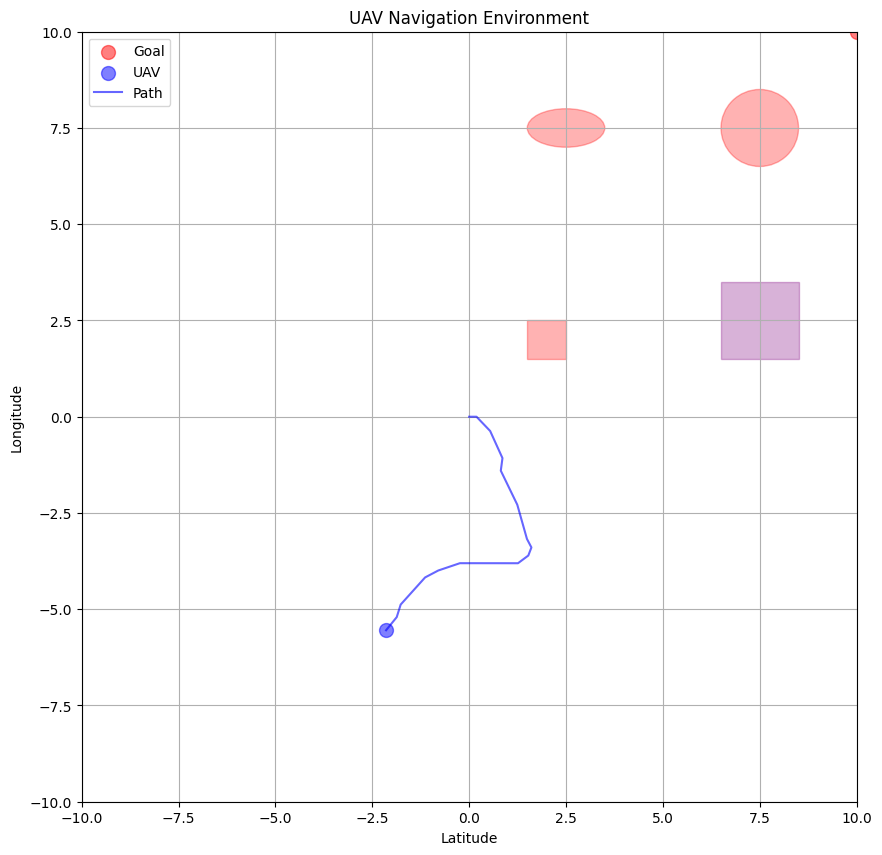

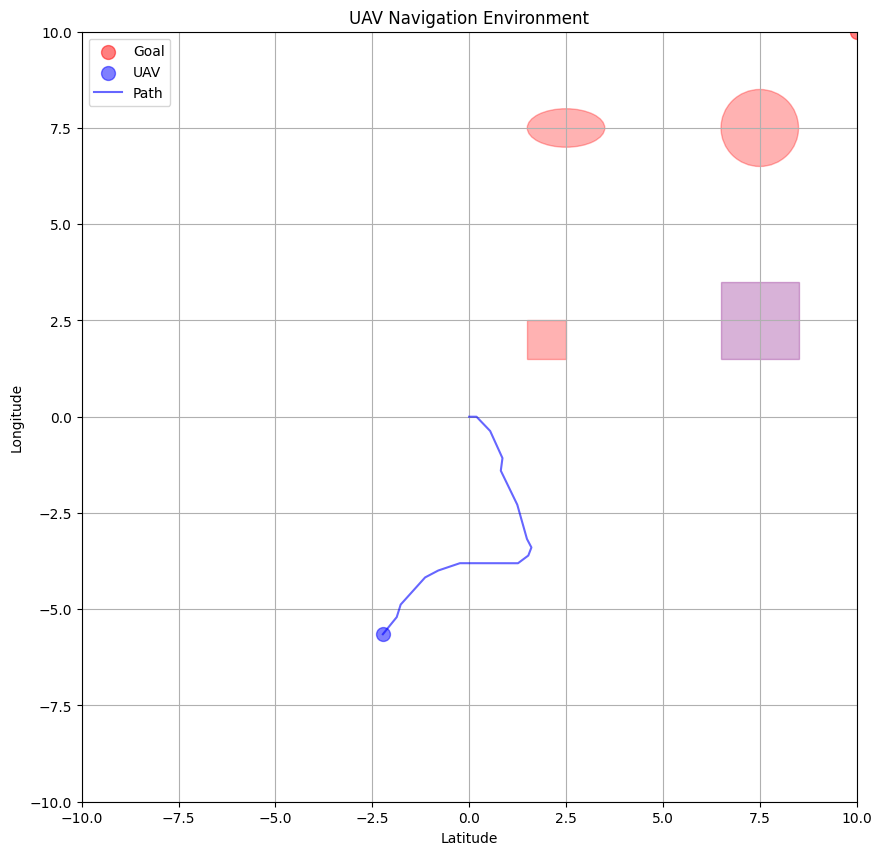

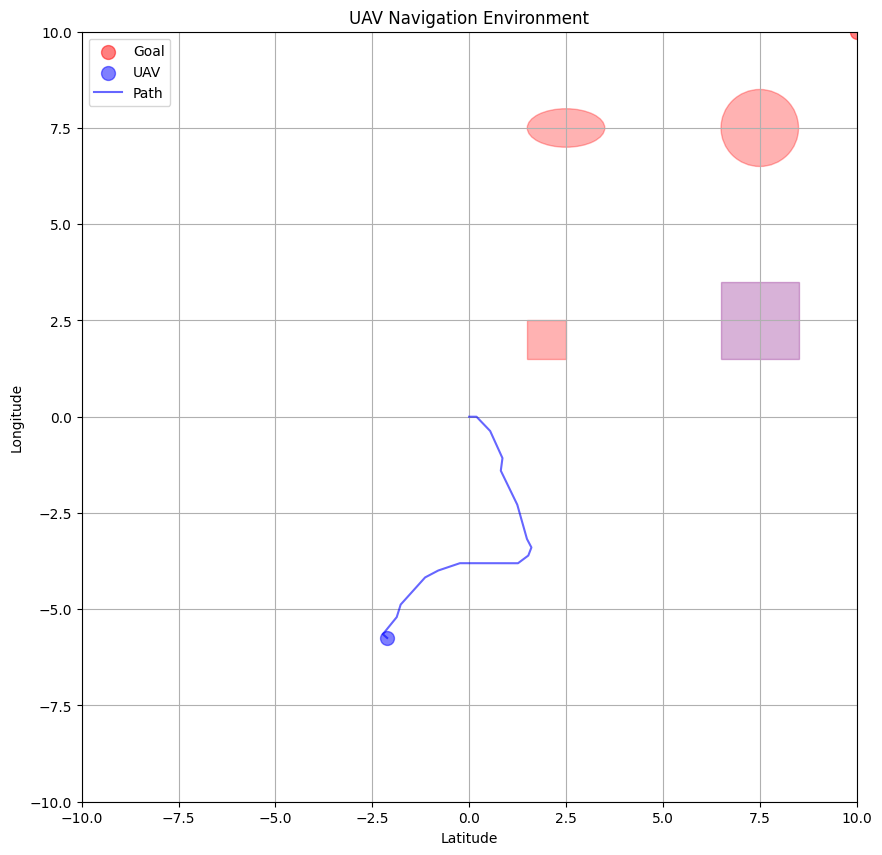

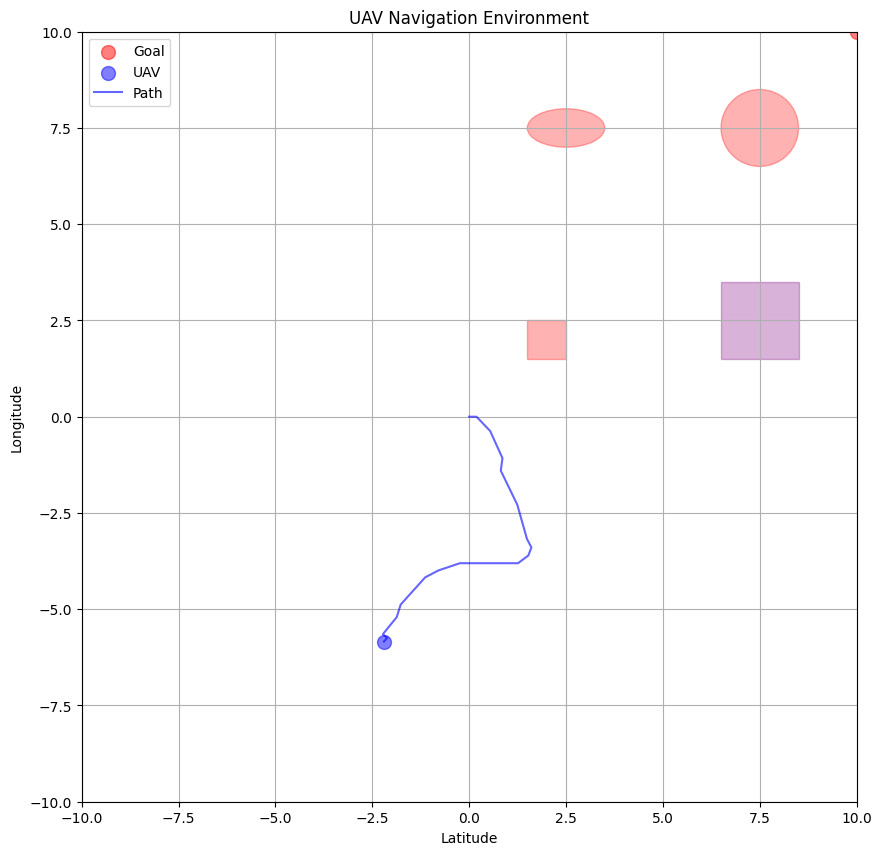

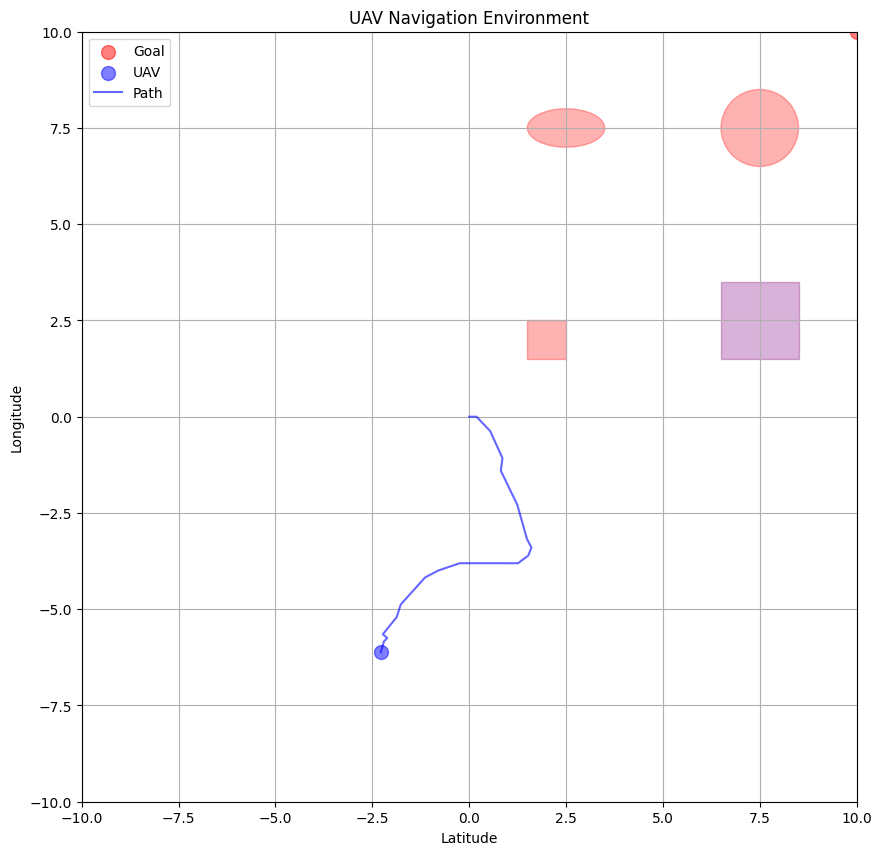

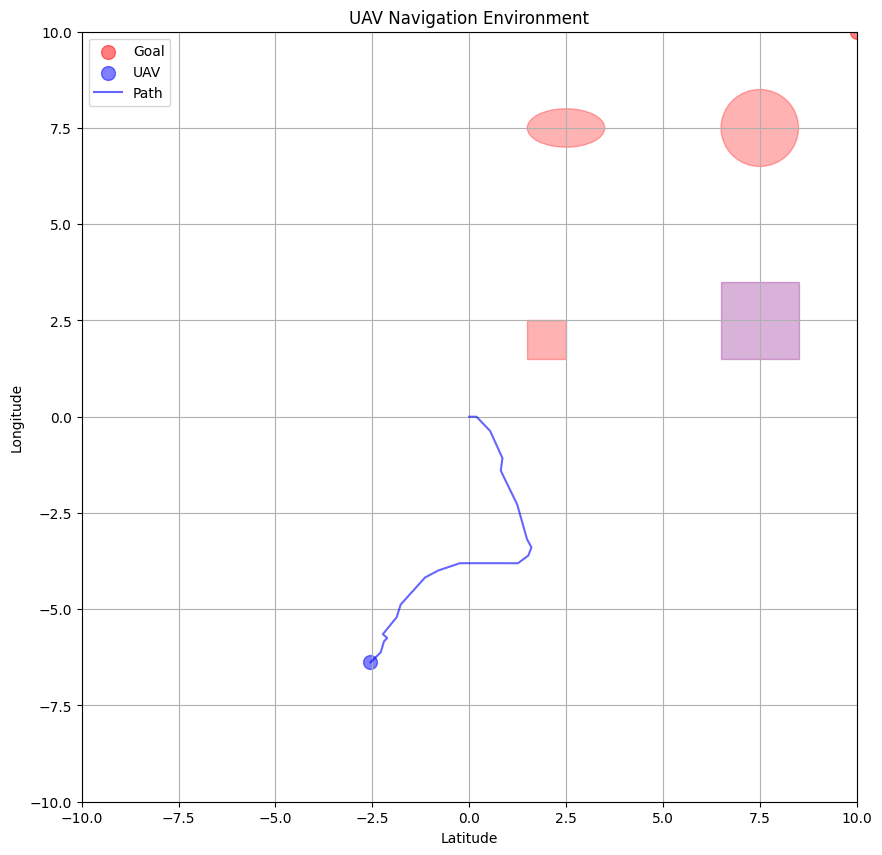

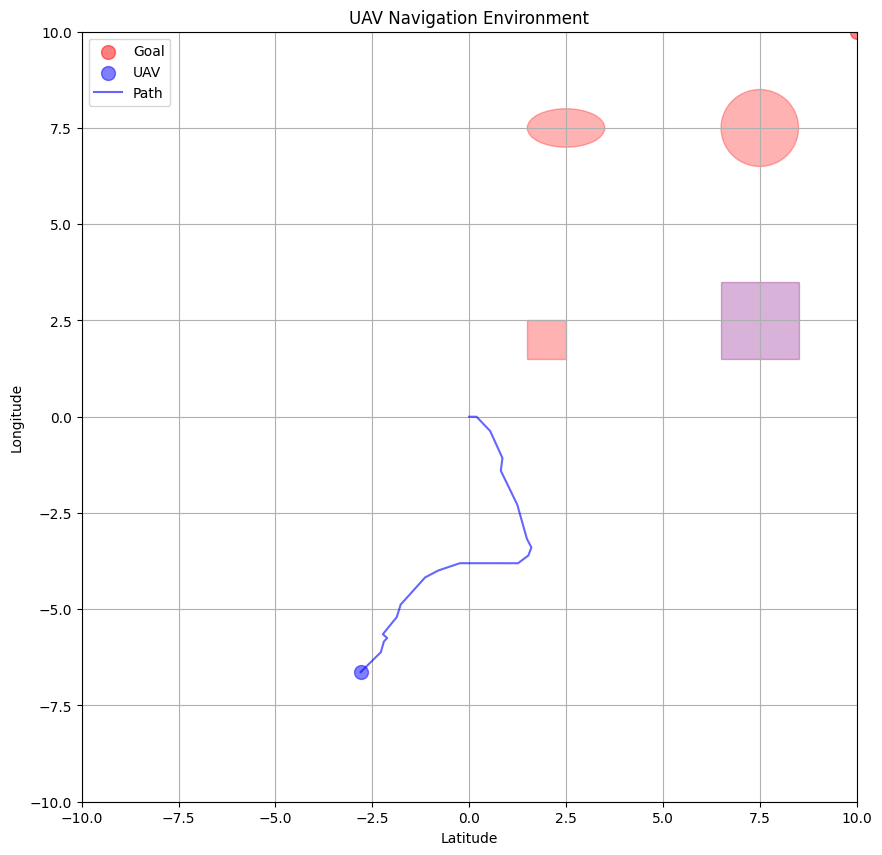

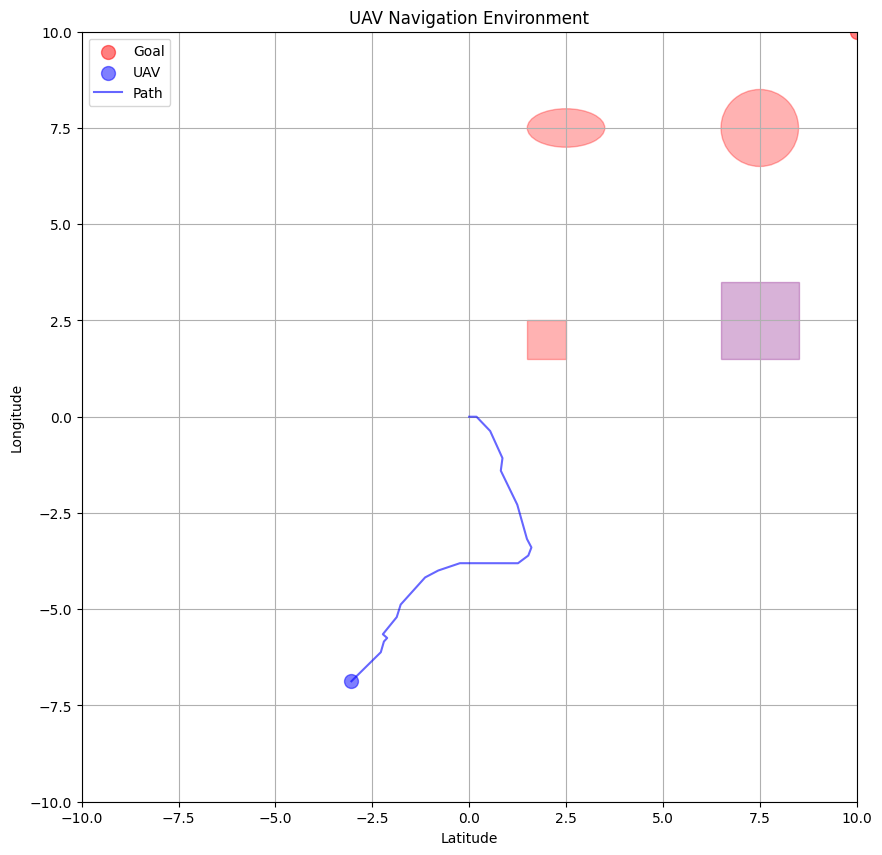

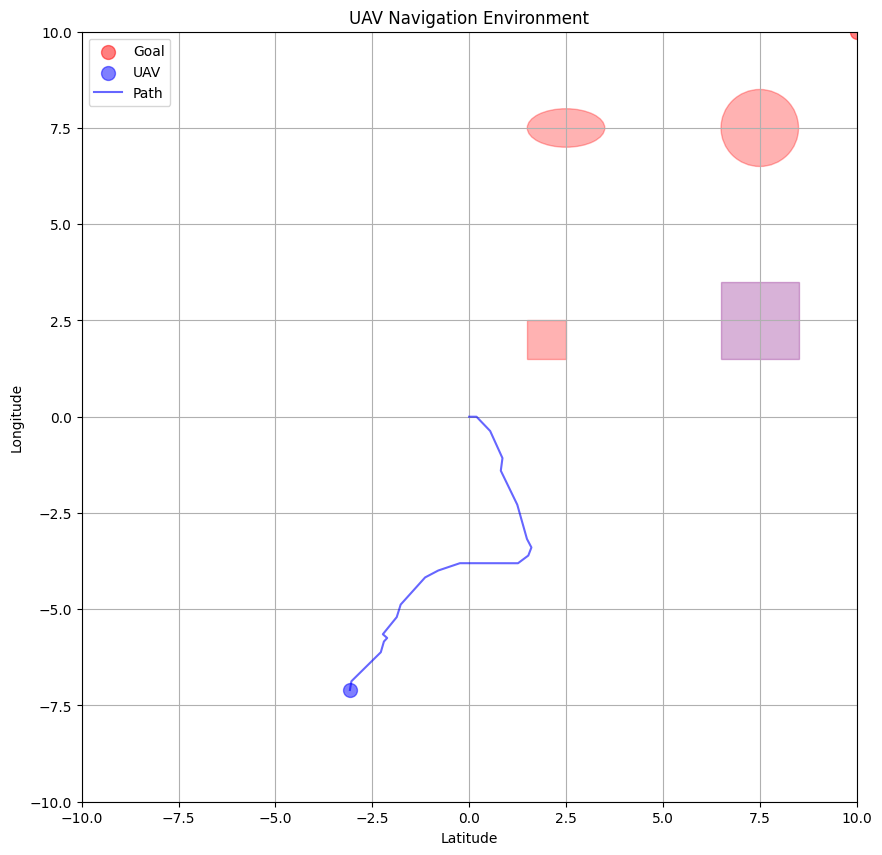

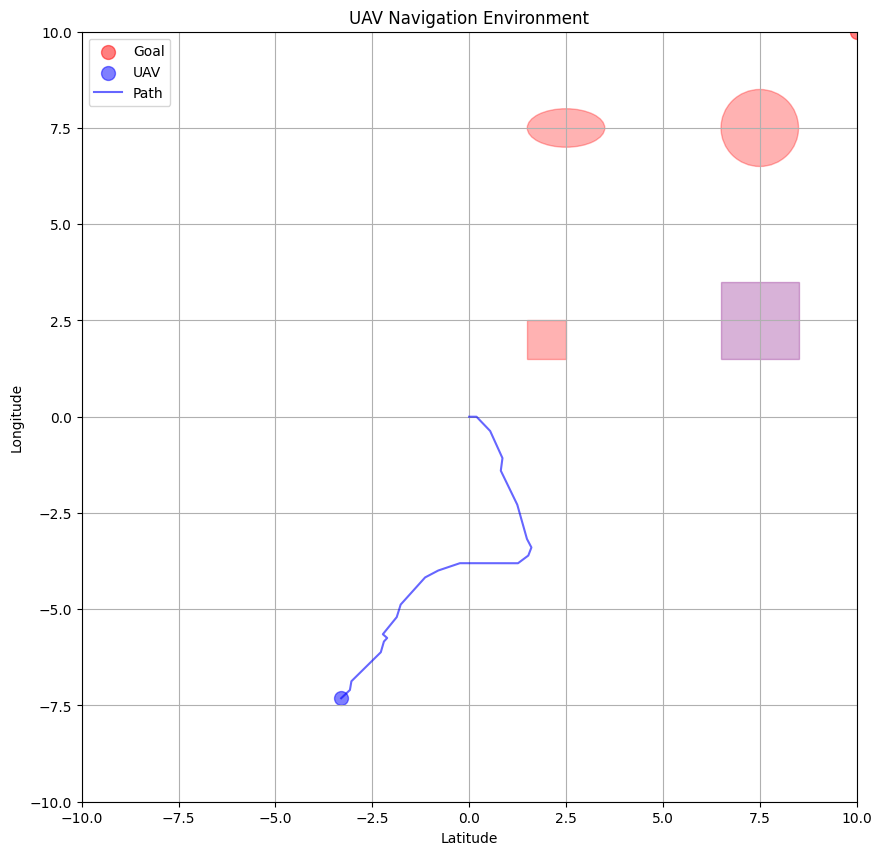

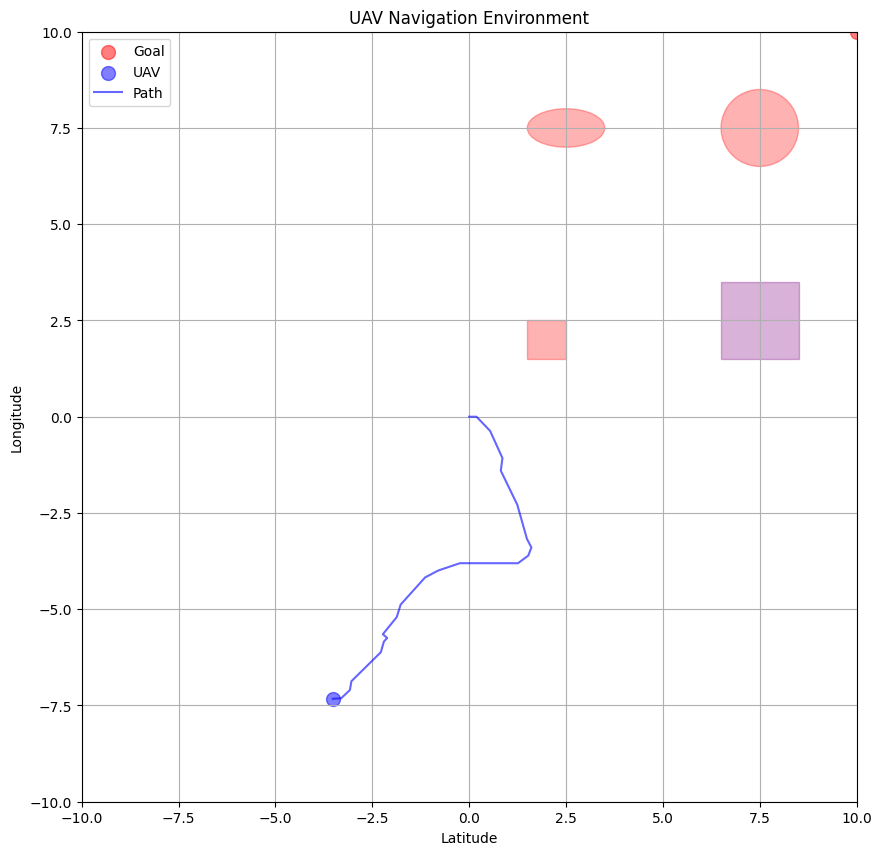

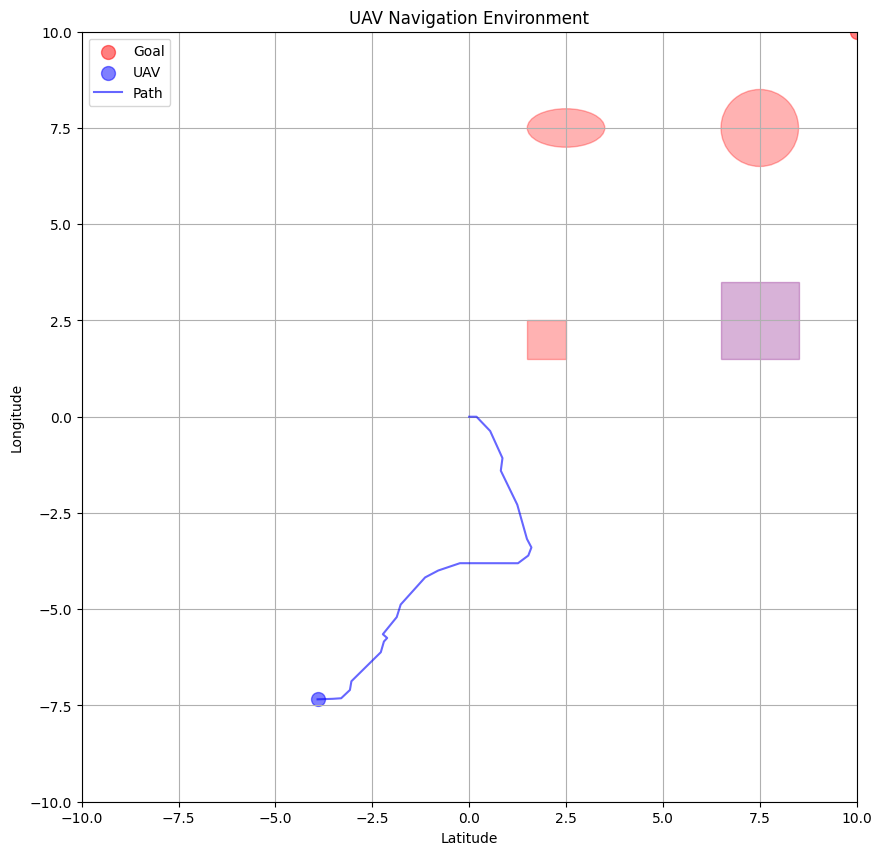

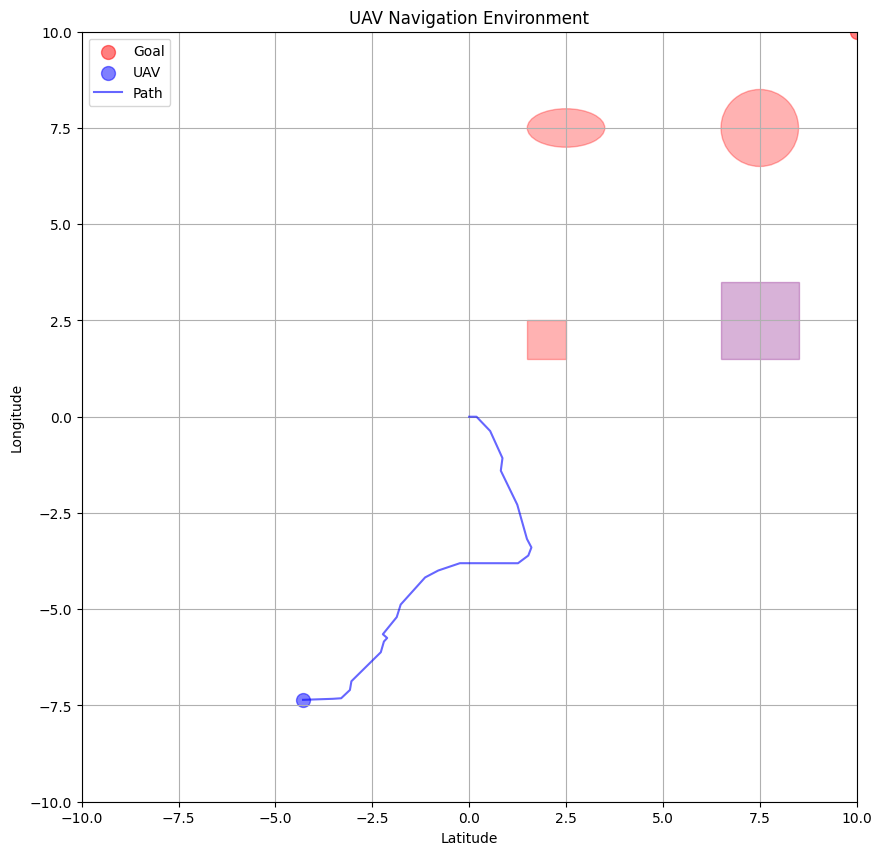

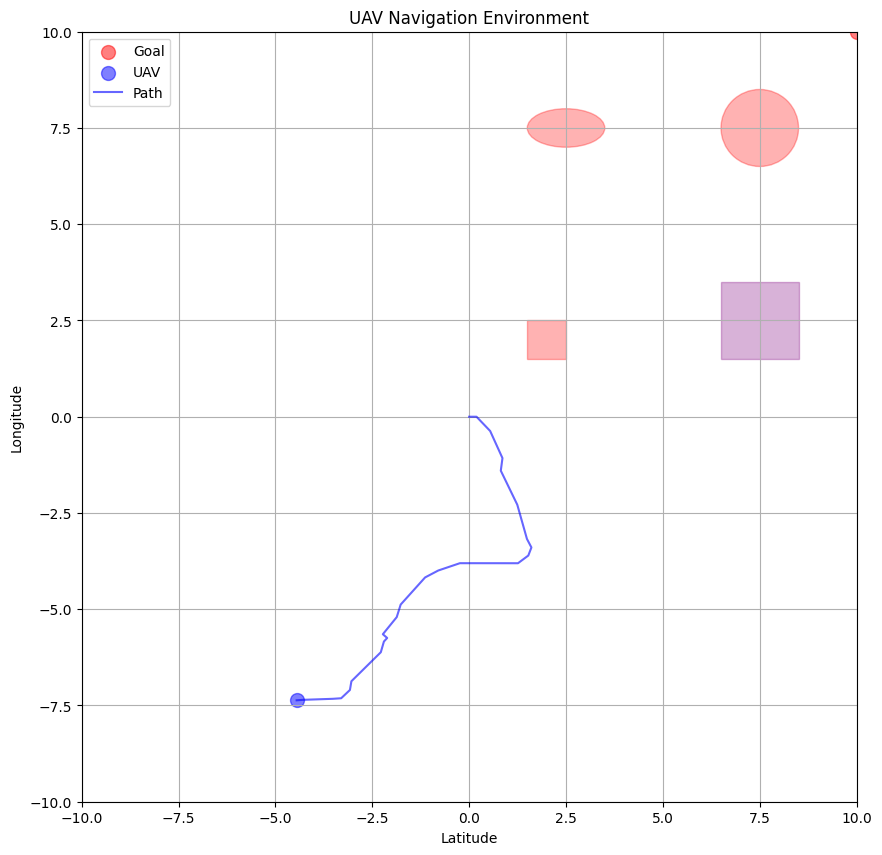

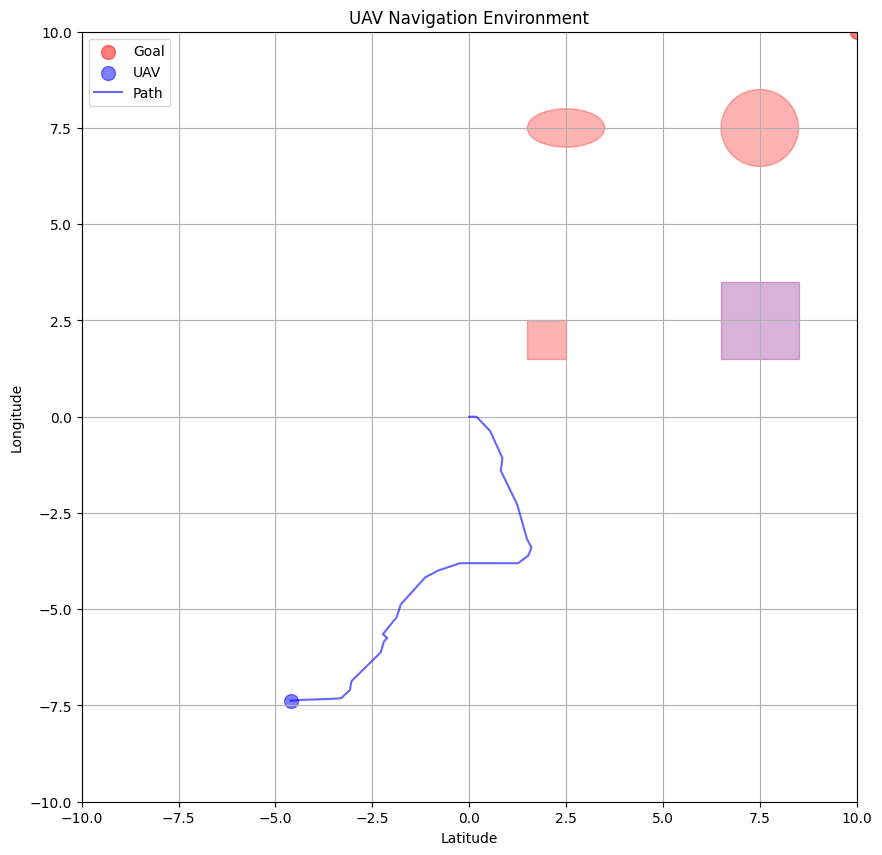

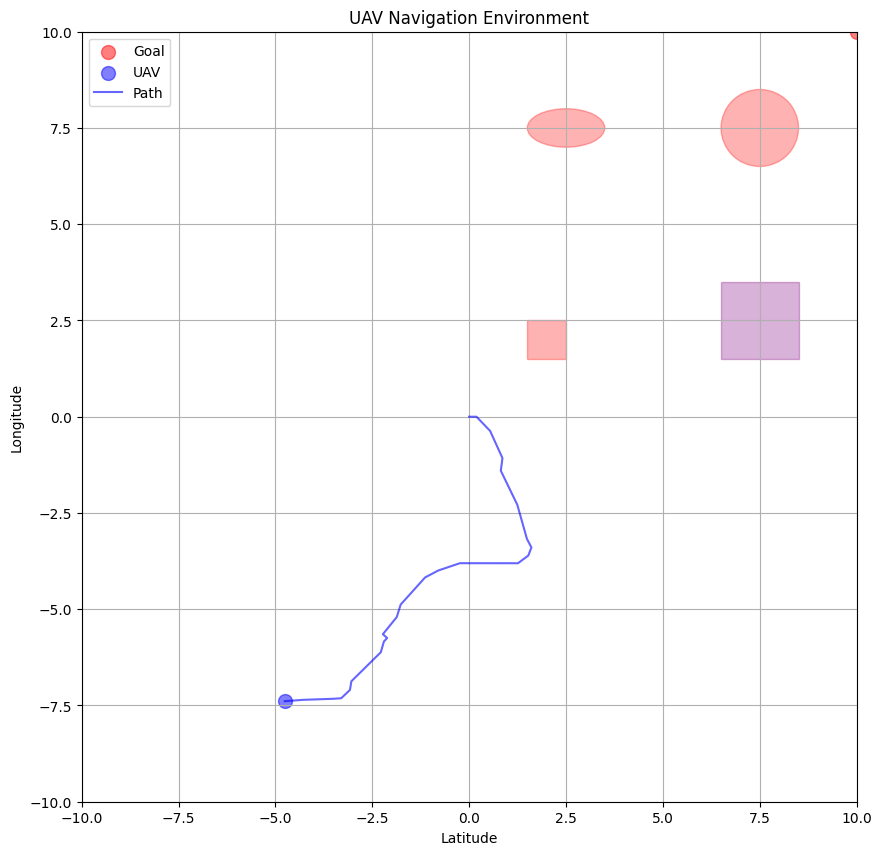

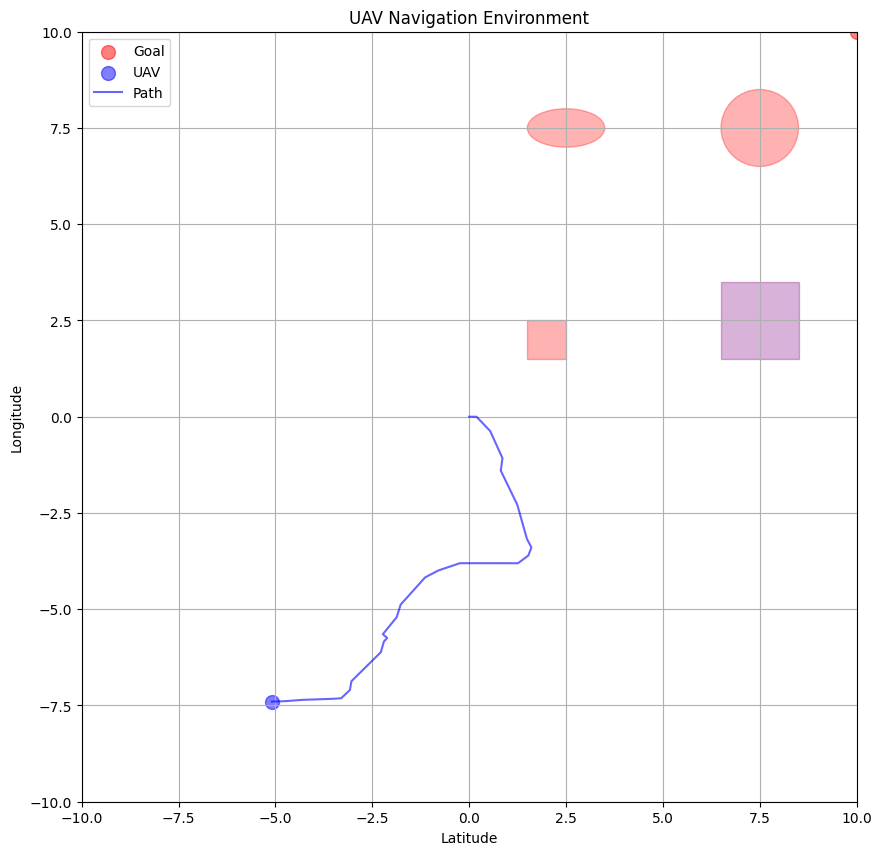

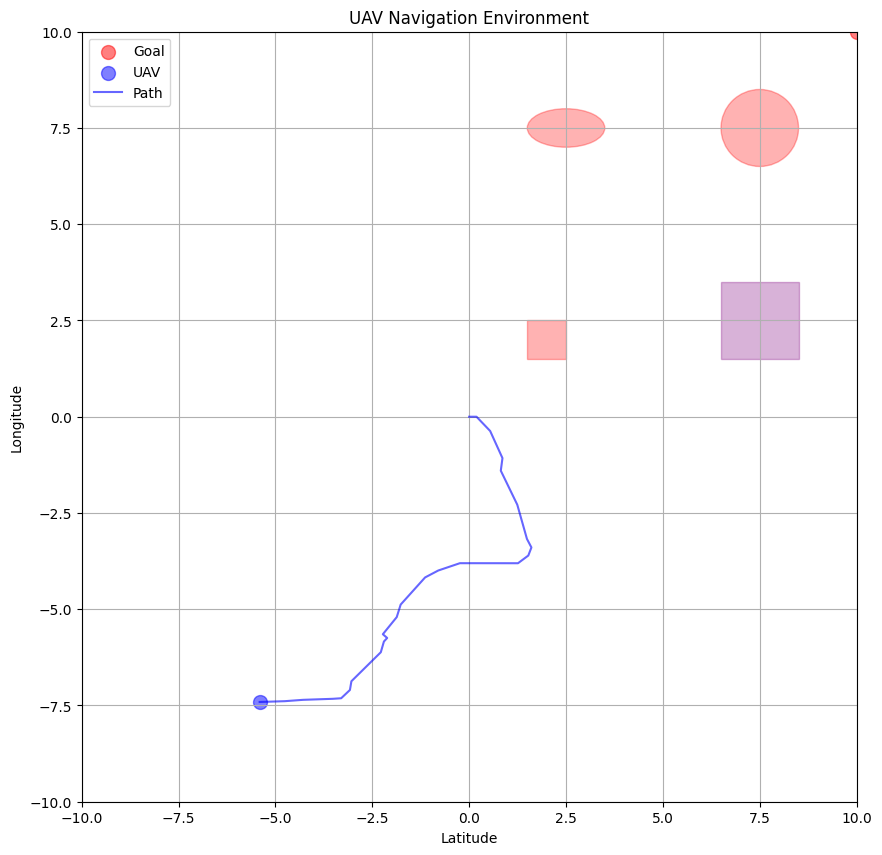

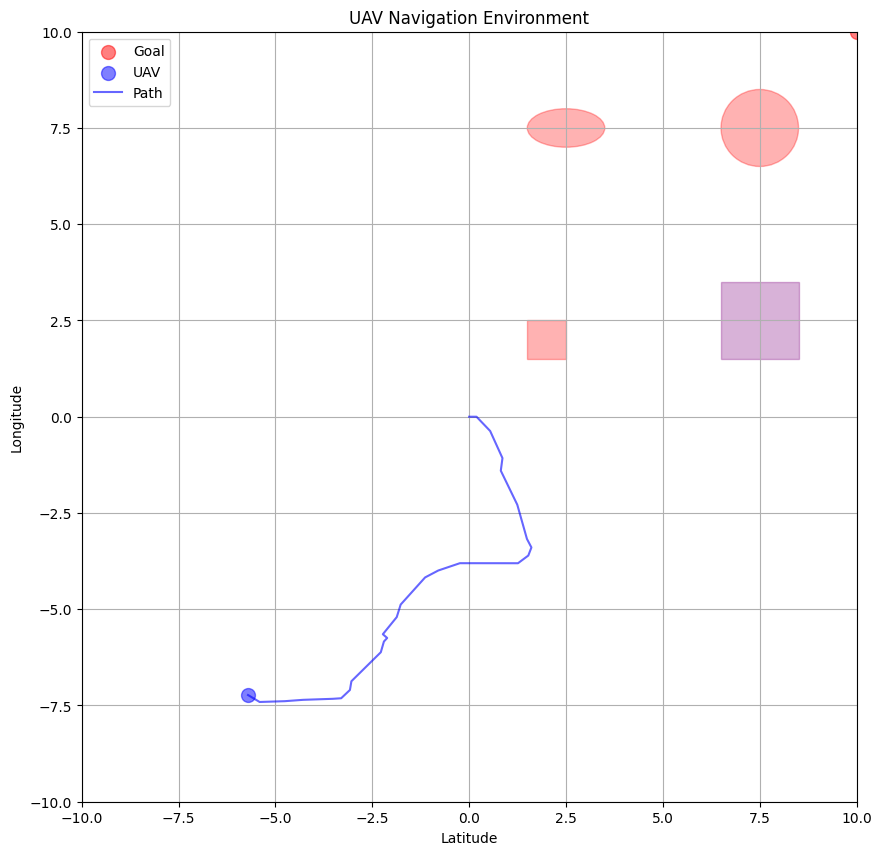

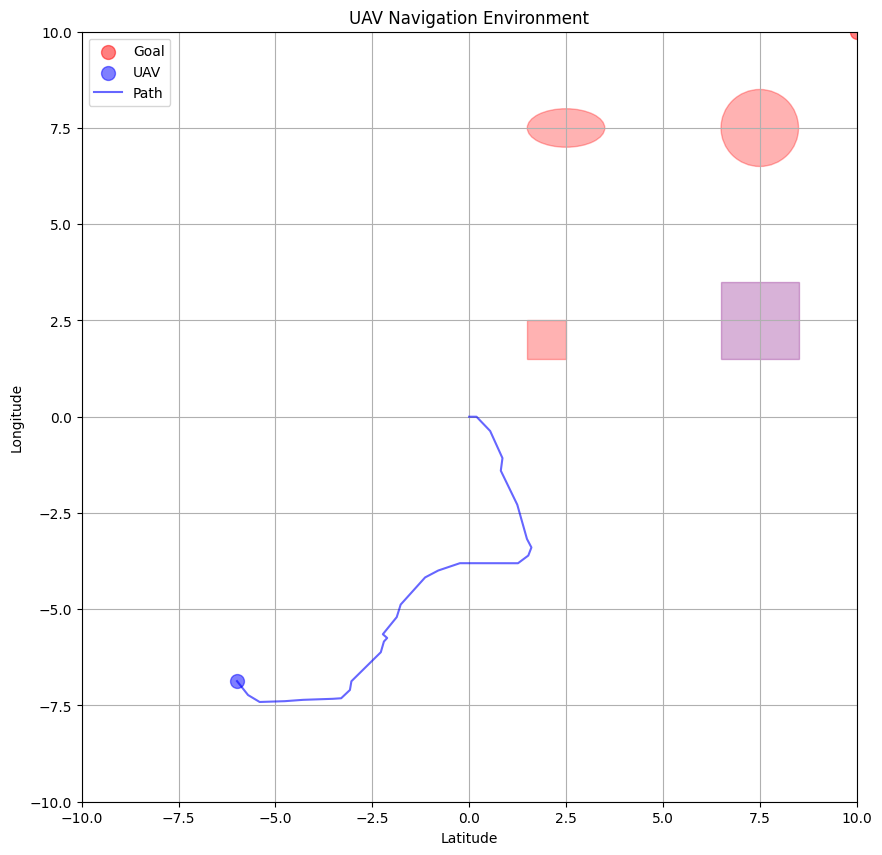

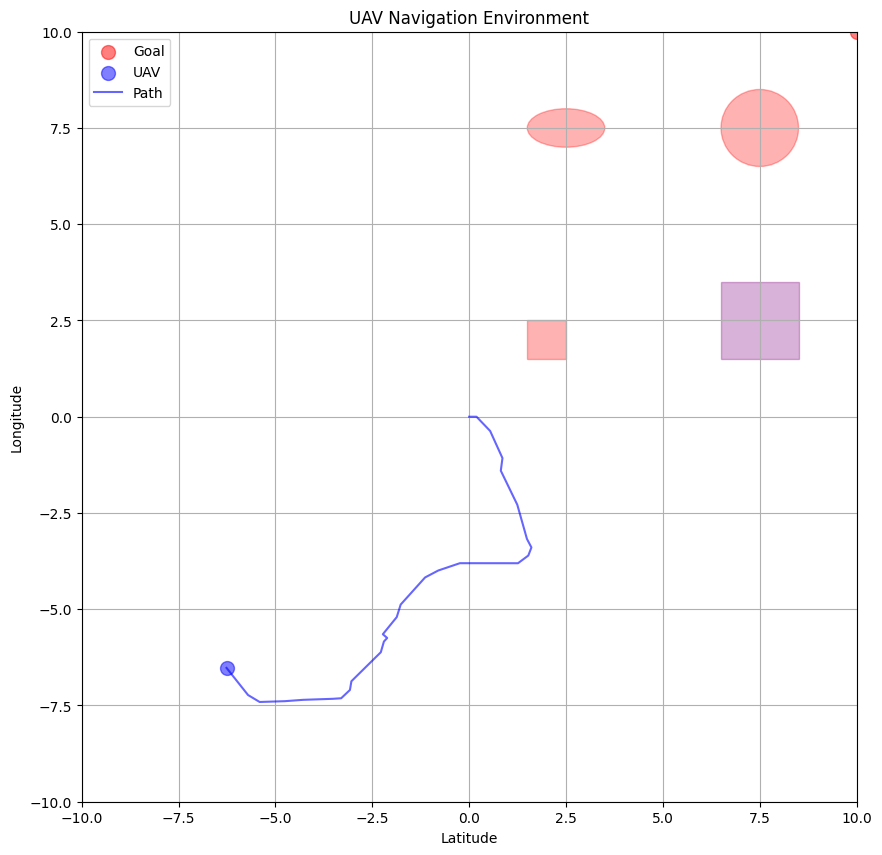

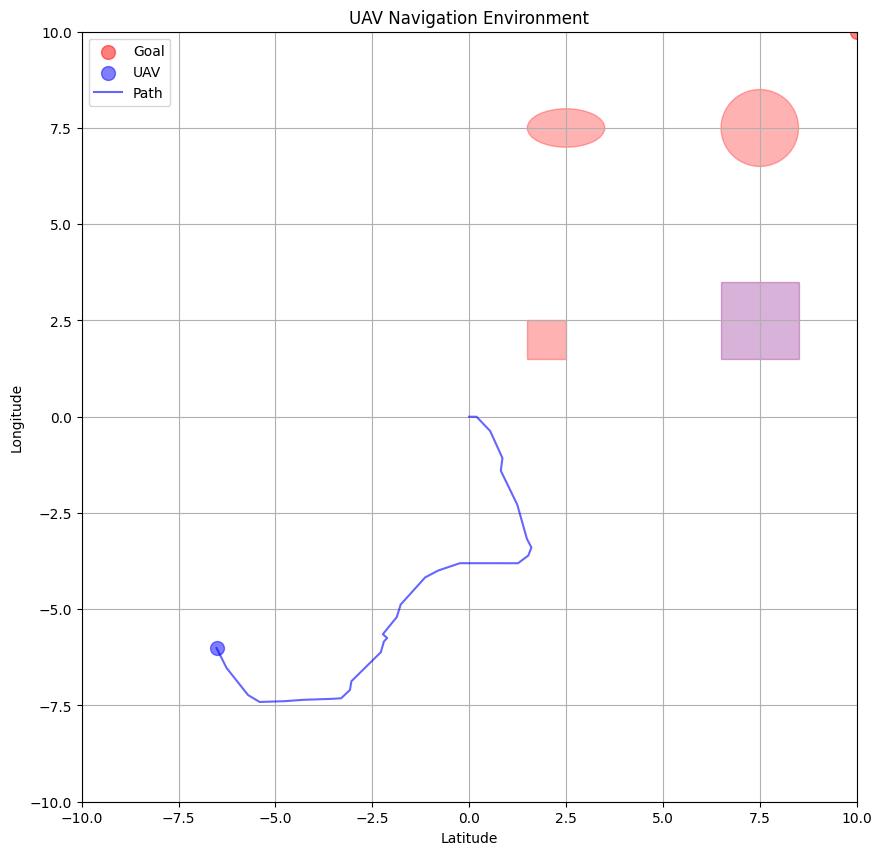

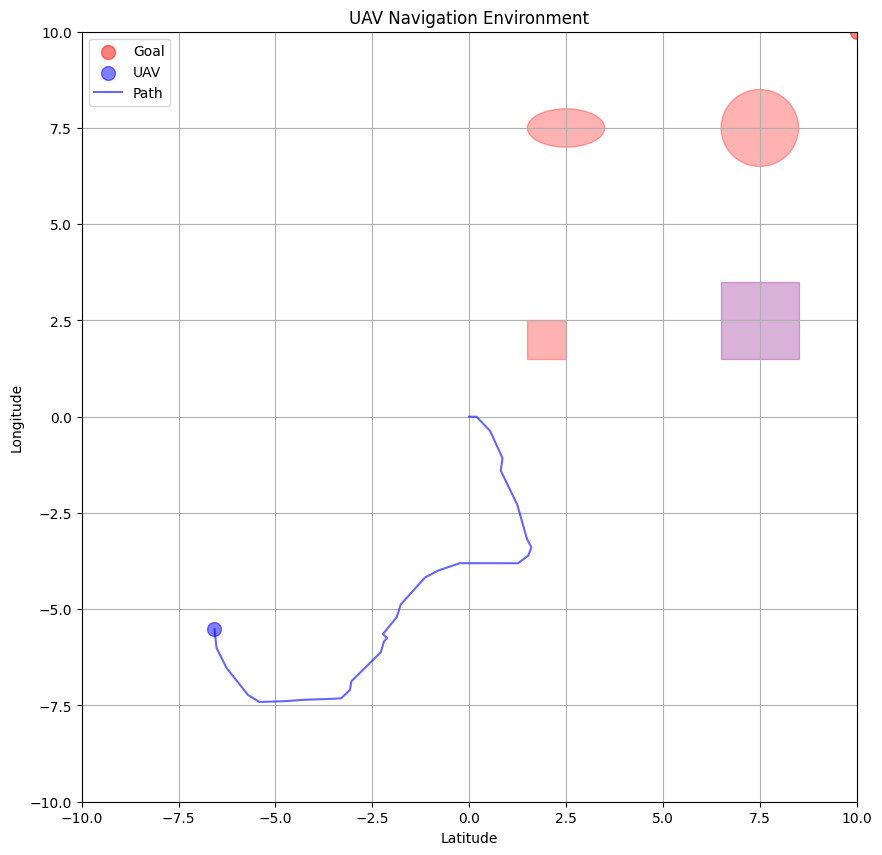

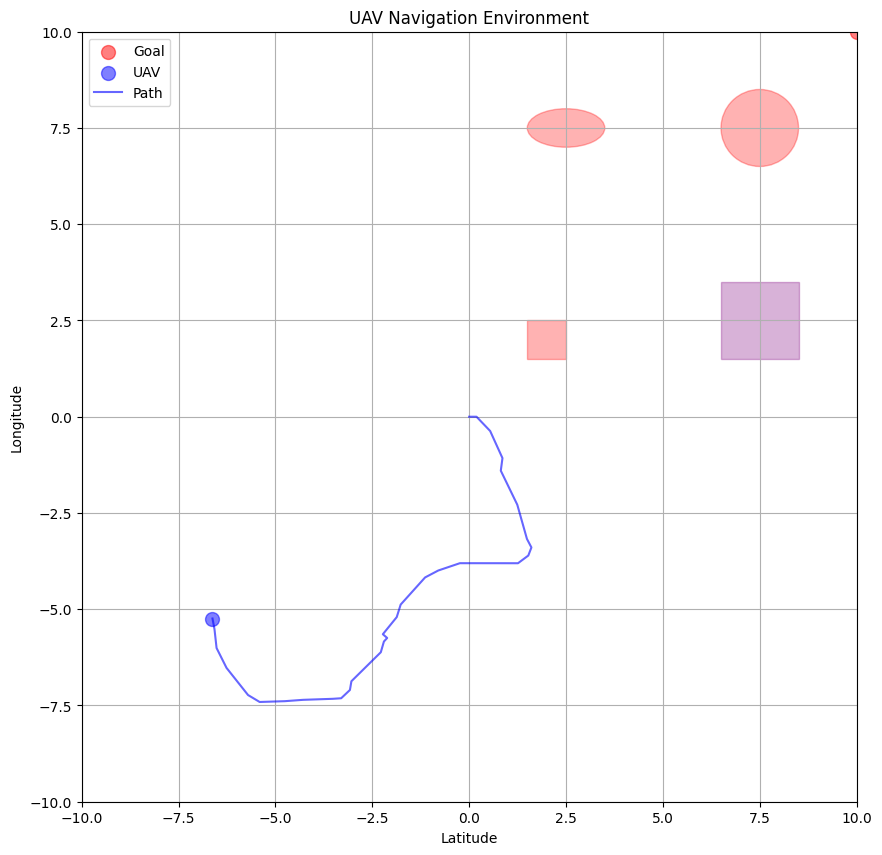

In [6]:
# Usage of the UAVEnv environment

# Create an instance of the UAVEnv environment
env = UAVEnv()

# Reset the environment and get the initial state
state = env.reset()

# Iterate through a predefined number of steps (e.g., 50)
for _ in range(50):
    # Sample a random action from the action space
    action = env.action_space.sample()

    # Take a step in the environment using the sampled action
    state, reward, done, info = env.step(action)

    # Render the environment to visualize the UAV's navigation
    env.render()

    # Check if the episode is done
    if done:
        break

In [7]:
# Creating a vectorized environment with 4 parallel environments
env = make_vec_env(lambda: UAVEnv(), n_envs=4)

# Assuming you have your environment `env` already set up
# Initializing the PPO model with the MlpPolicy
model = PPO("MlpPolicy", 
            env, 
            learning_rate=0.0003805913356107848, 
            n_steps=64, 
            batch_size=32, 
            verbose=1)

# Training the model, you might want to increase the number of timesteps
model.learn(total_timesteps=150000)

# Evaluating the trained agent
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward}")

# Close the environment when done
env.close()

Using cpu device
Collision detected! Taking avoidance measures.
Collision with an obstacle!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 3.15     |
| time/              |          |
|    fps             | 3109     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------


C:\Users\ammar\myuav\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 74          |
|    ep_rew_mean          | -16.4       |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.012844631 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.000381    |
|    loss                 | 2.25        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 5.25        |
-----------------------------------------
Collision detected! Taking avoidance m

*This code cell sets up a test environment and runs a simulation of the UAV navigating through the environment. It then visualizes the path of the UAV, including obstacles and no-fly zones, and saves the animation as a GIF file.*

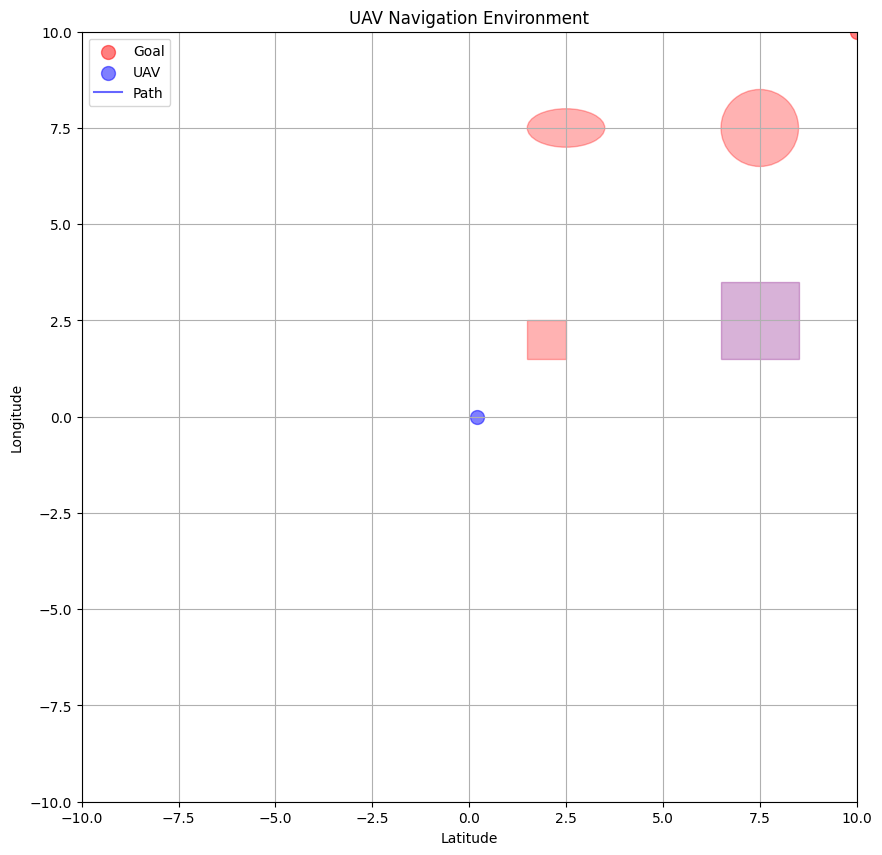

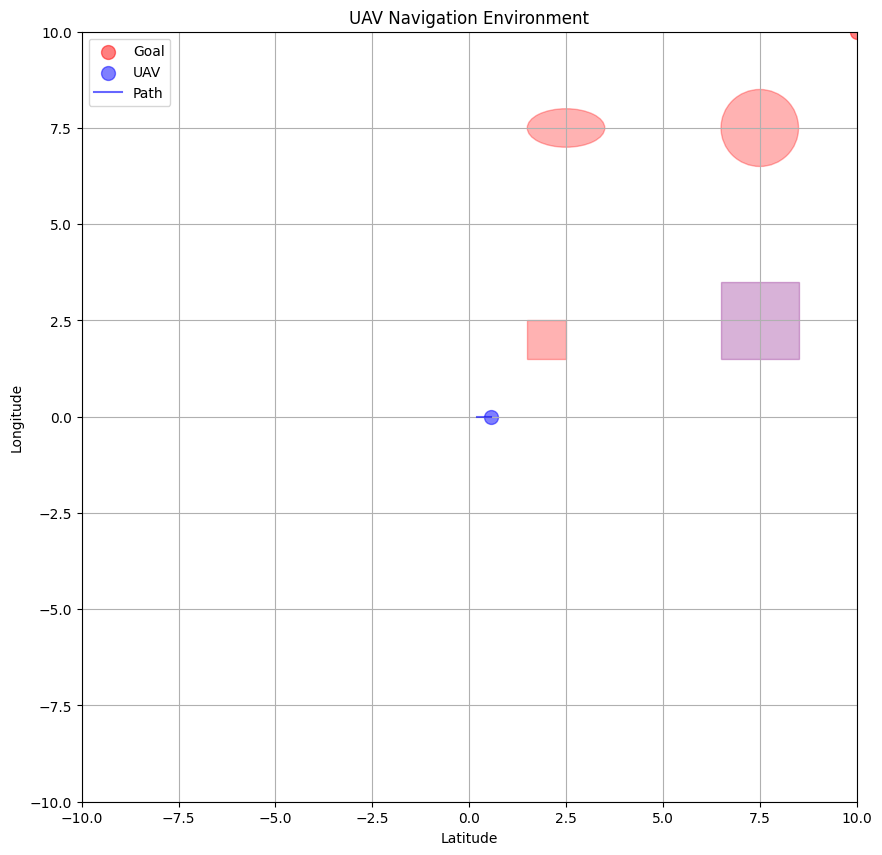

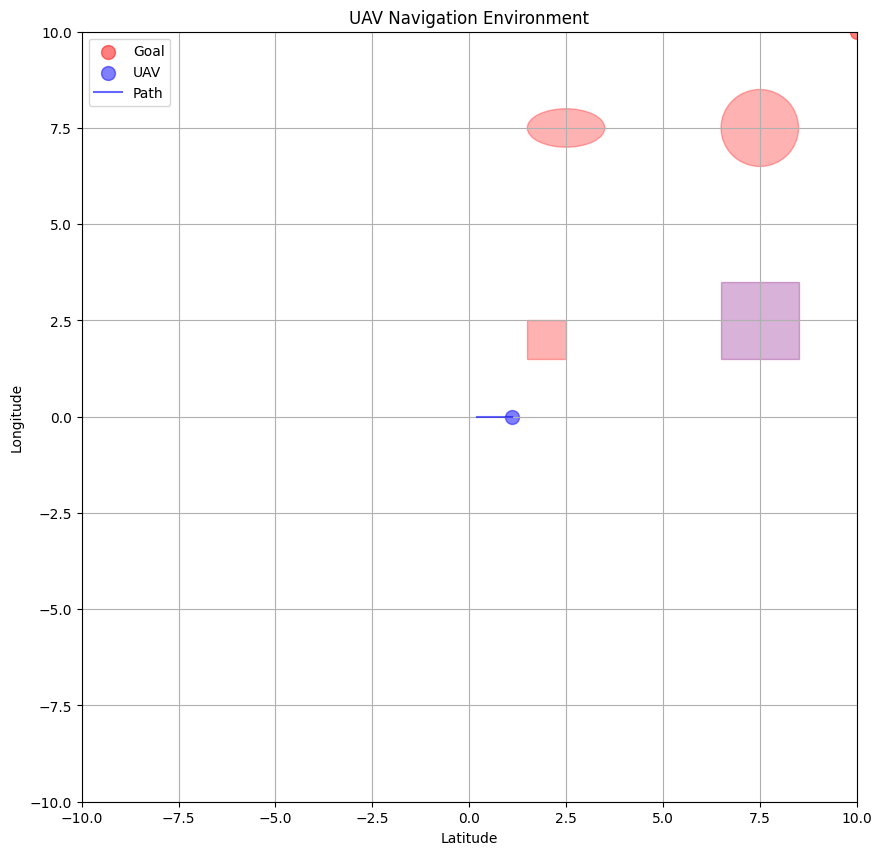

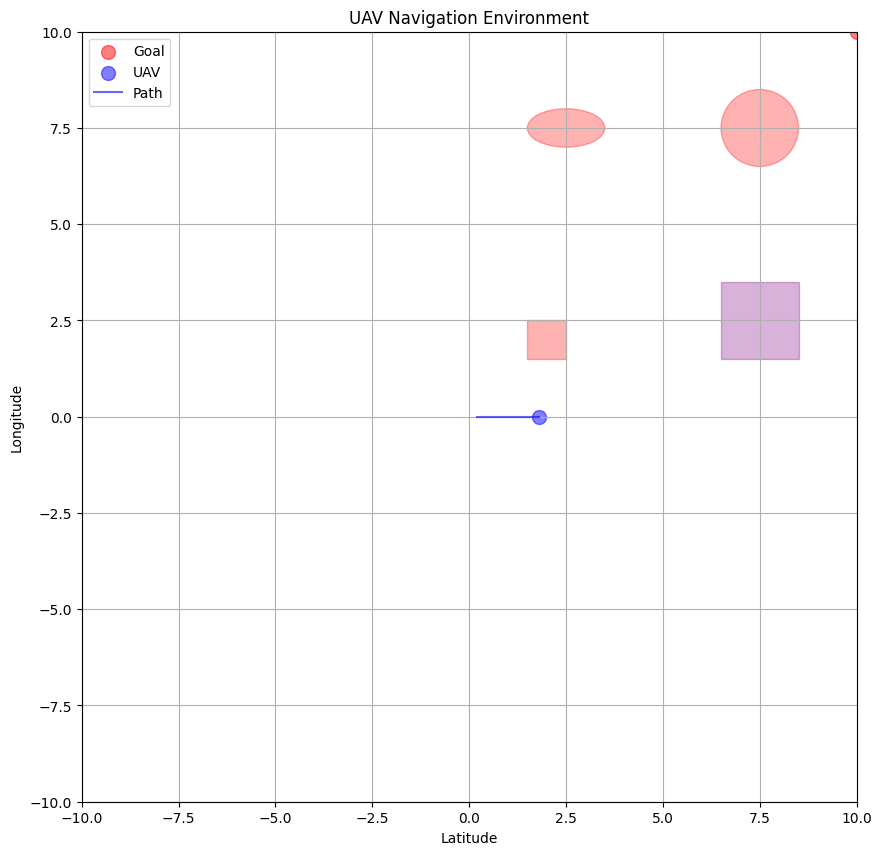

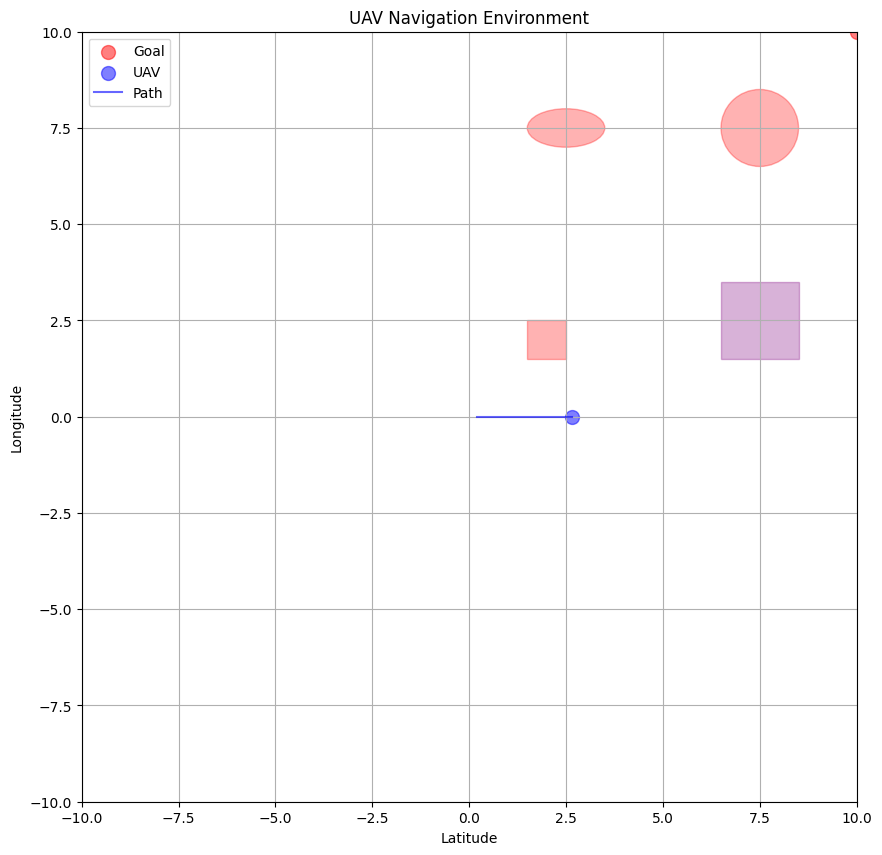

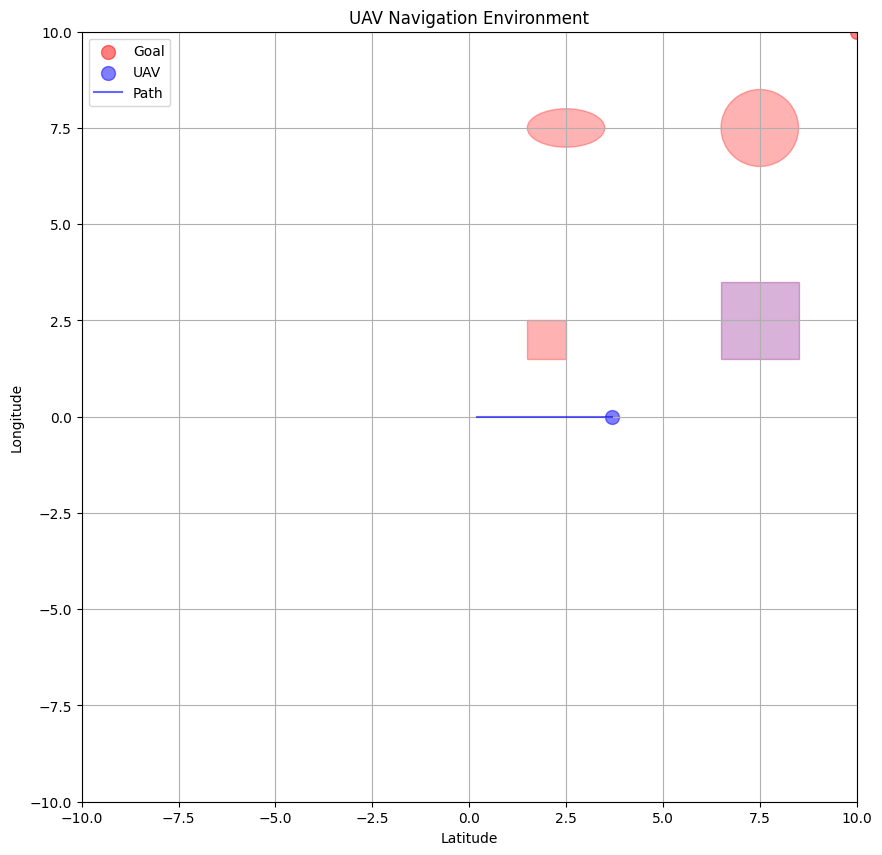

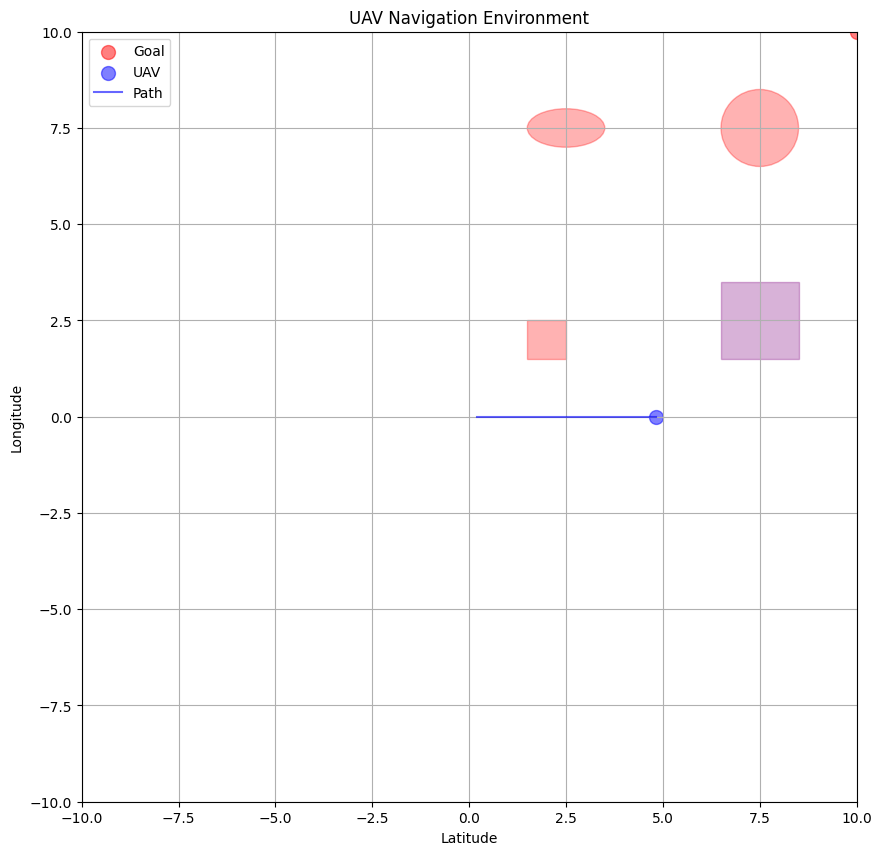

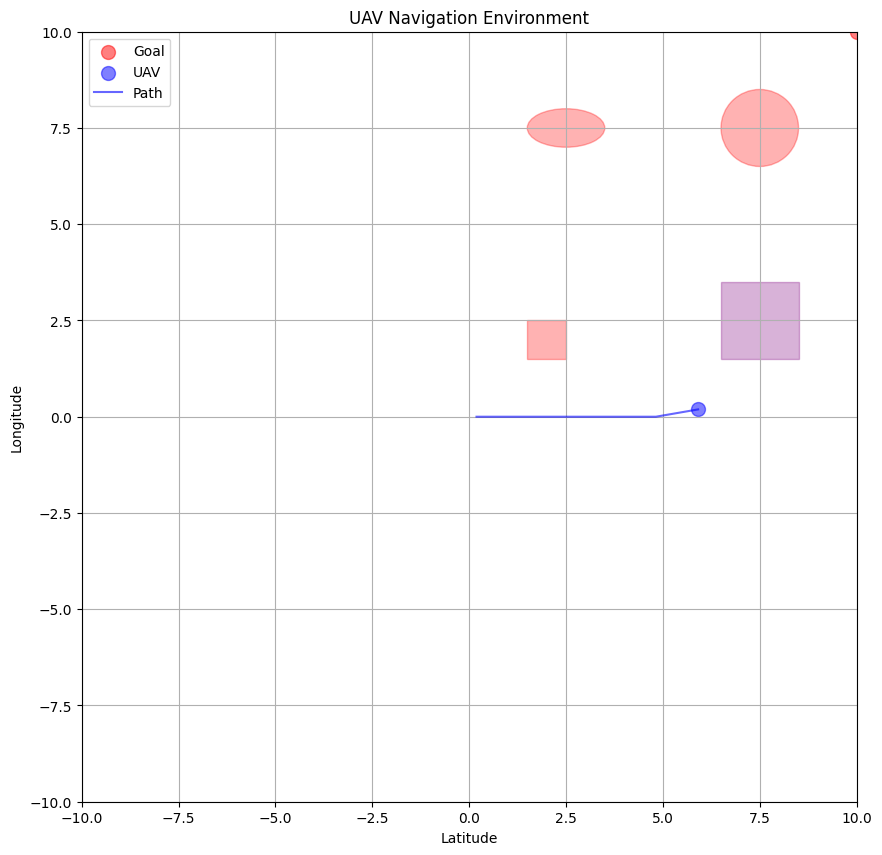

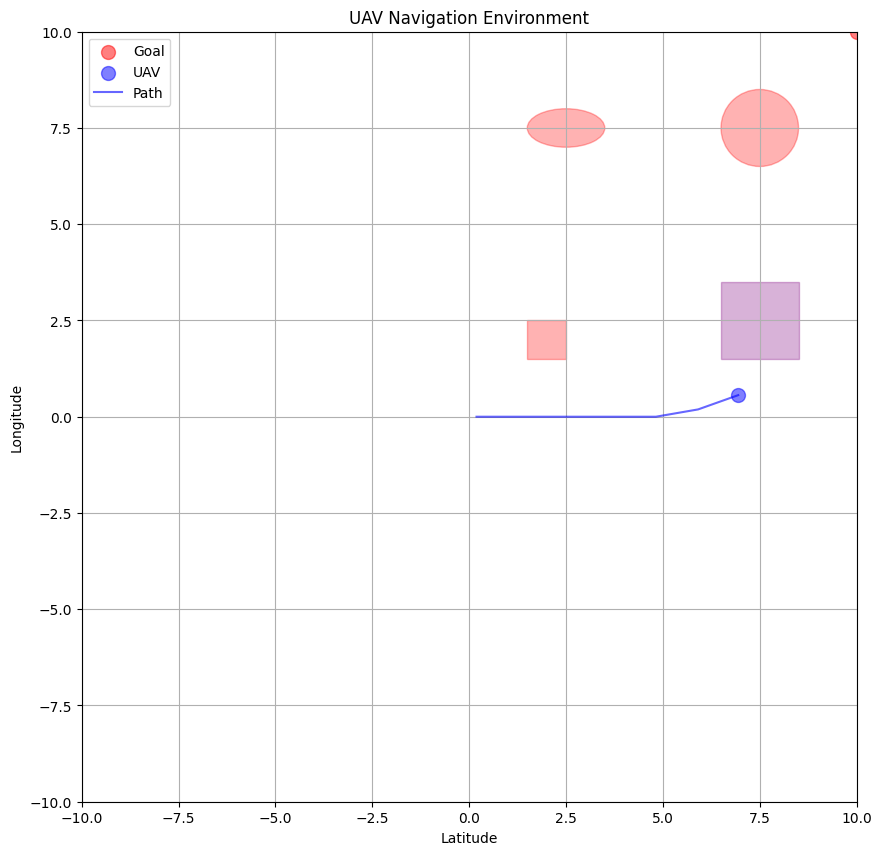

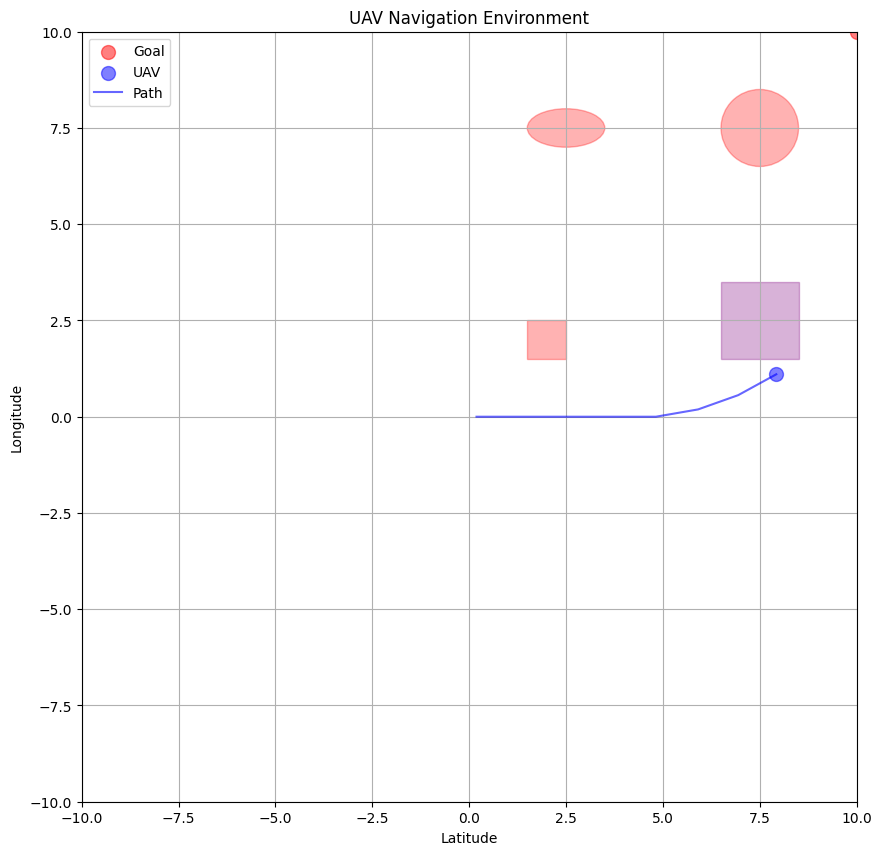

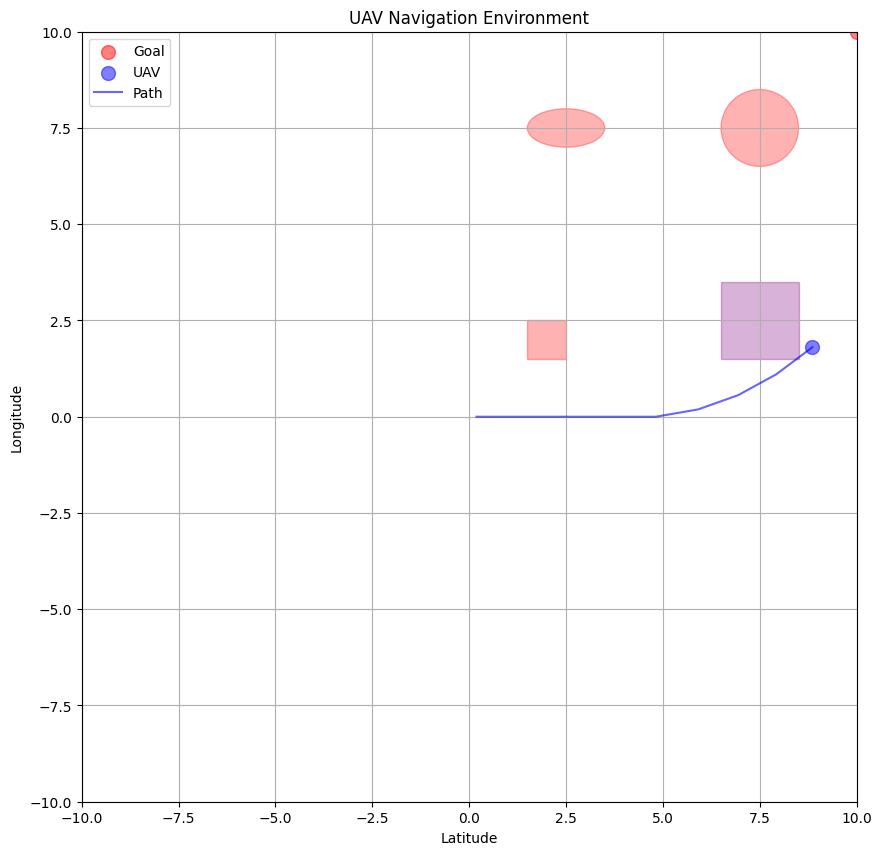

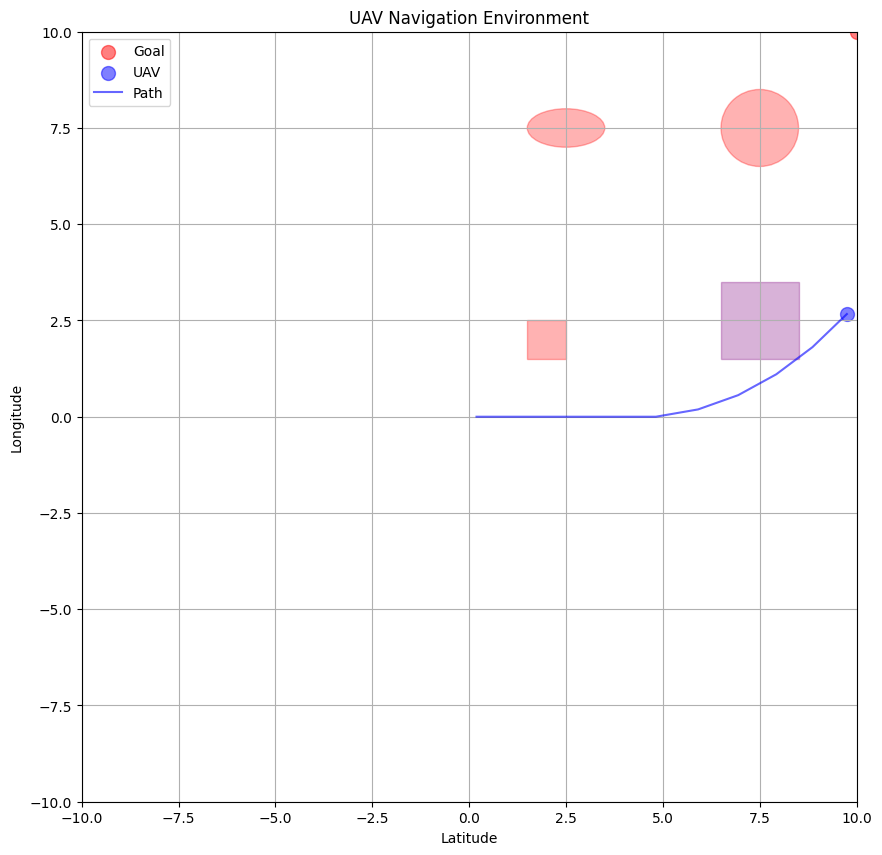

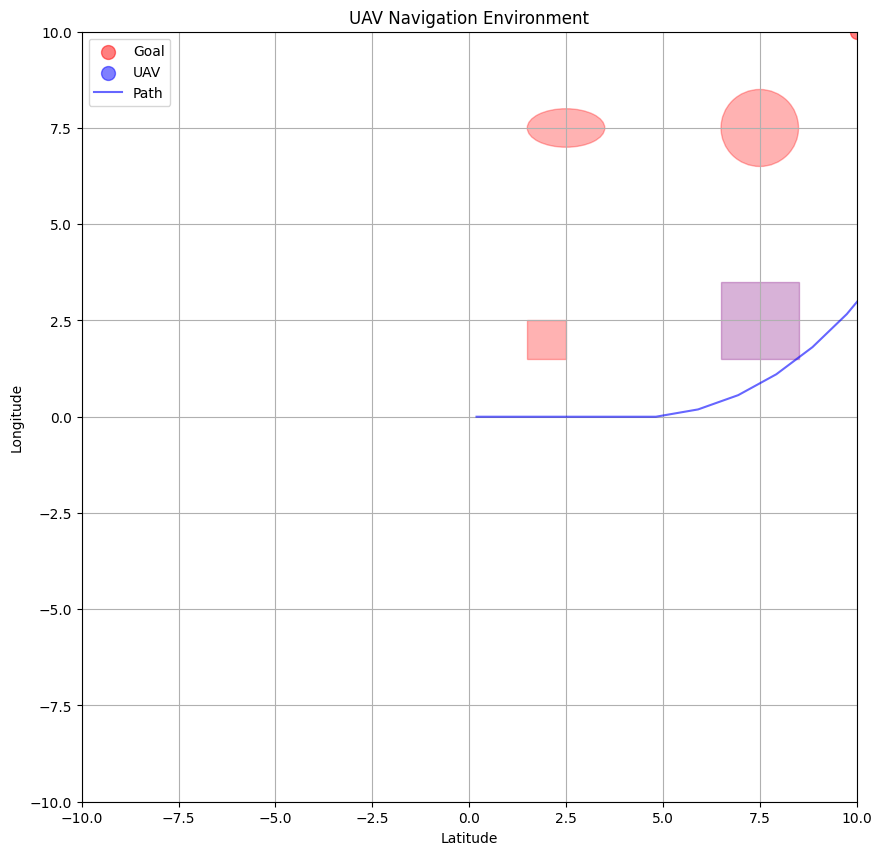

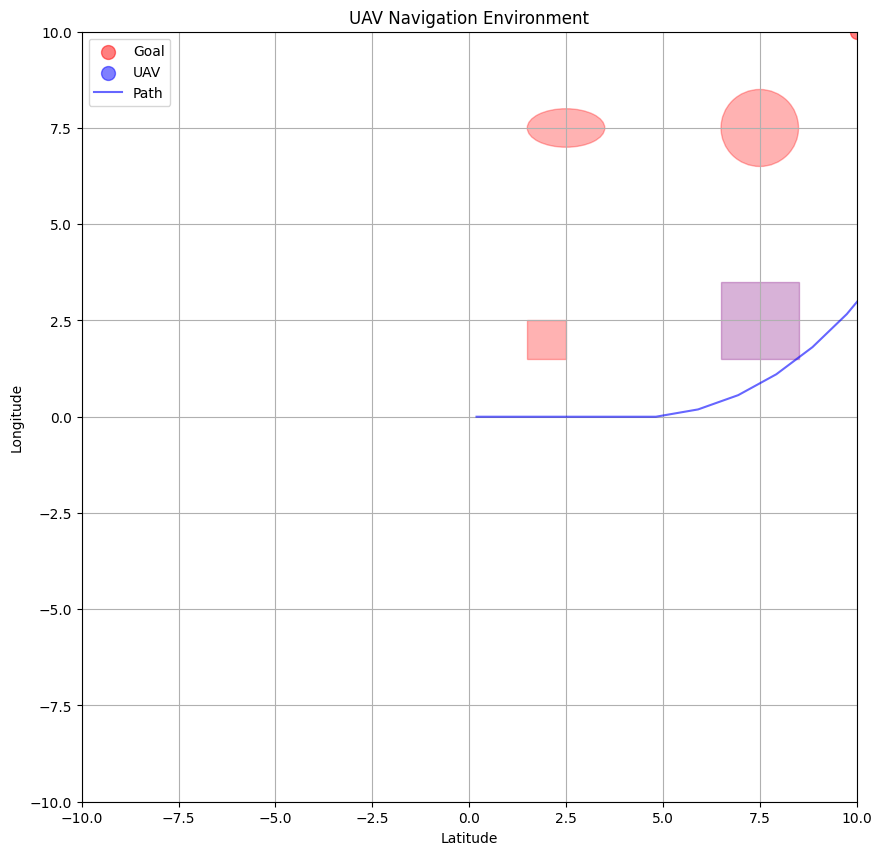

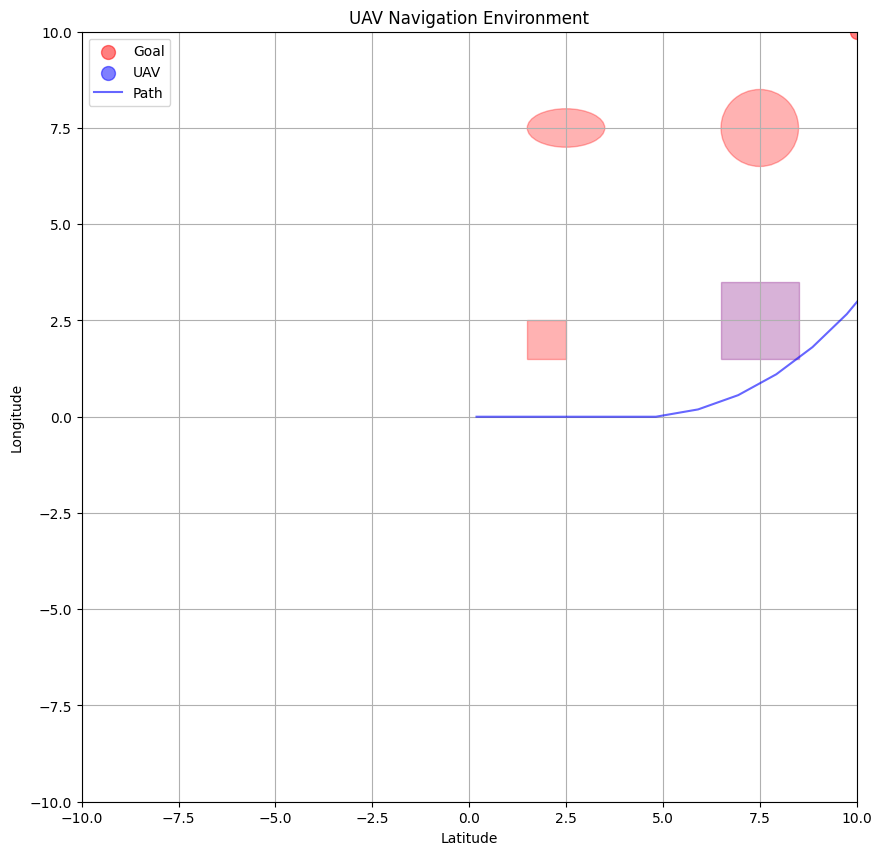

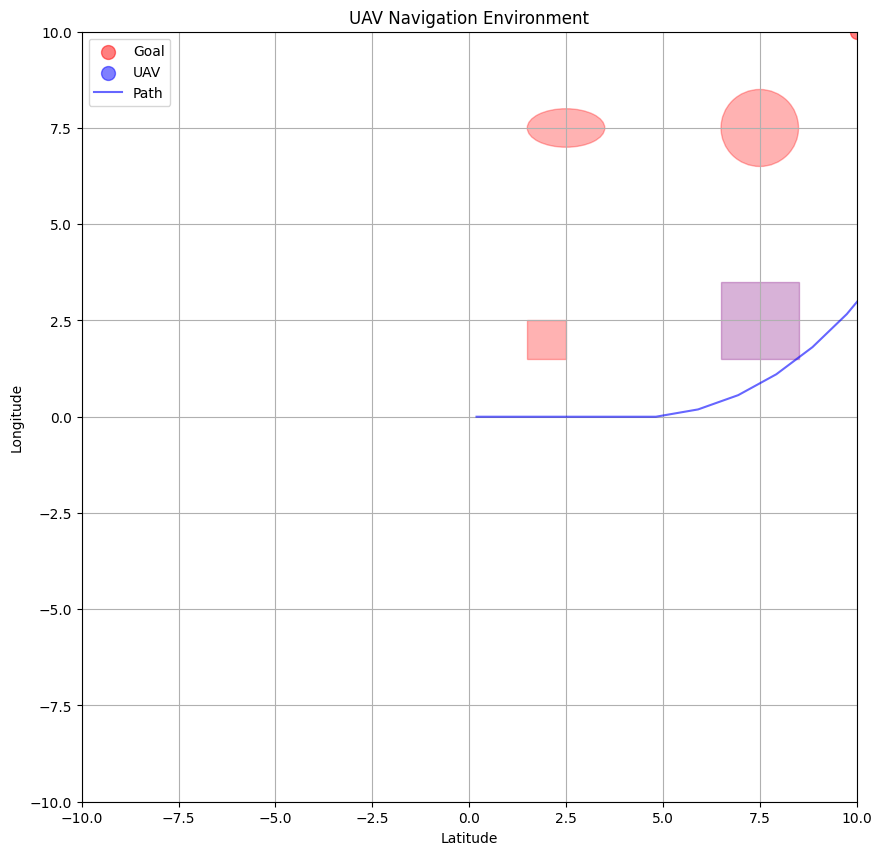

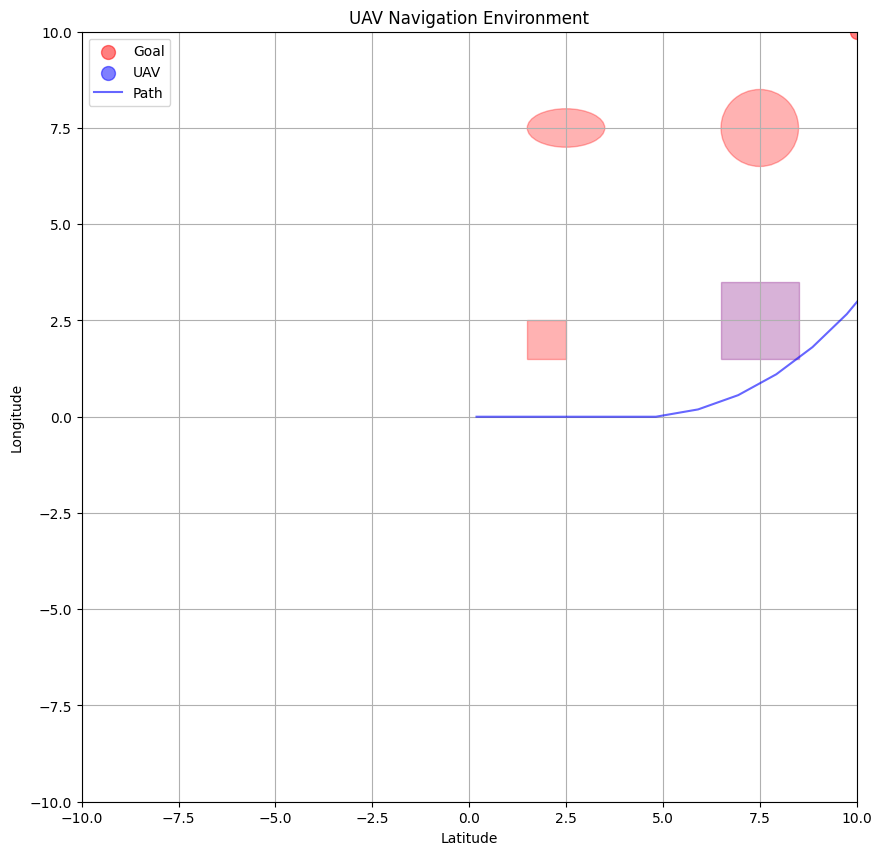

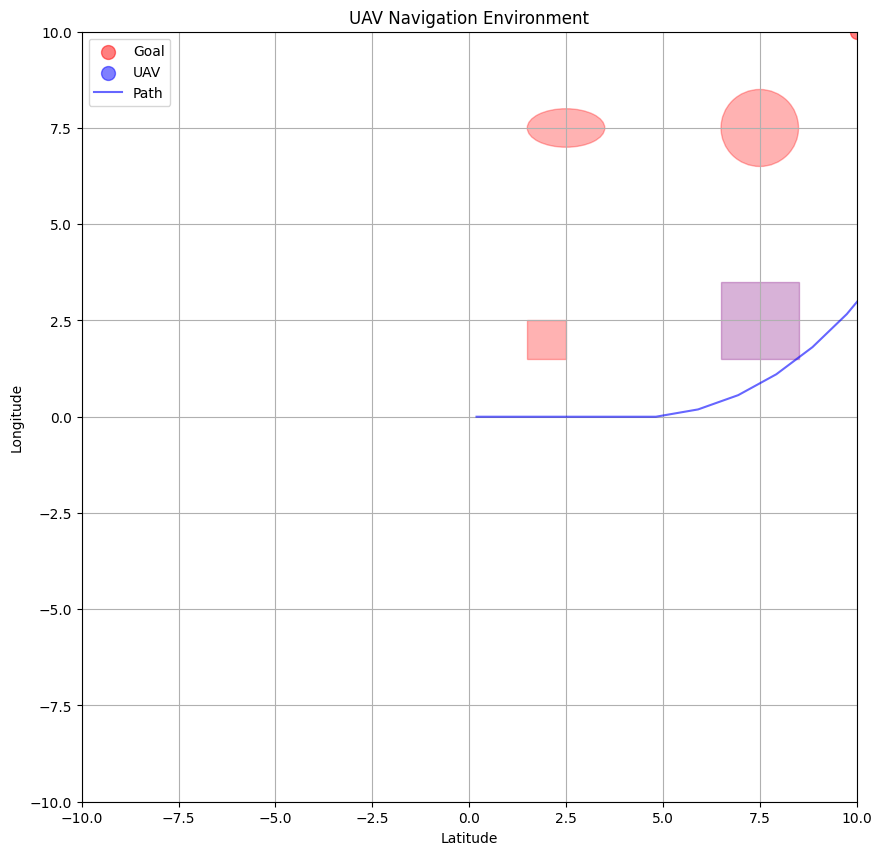

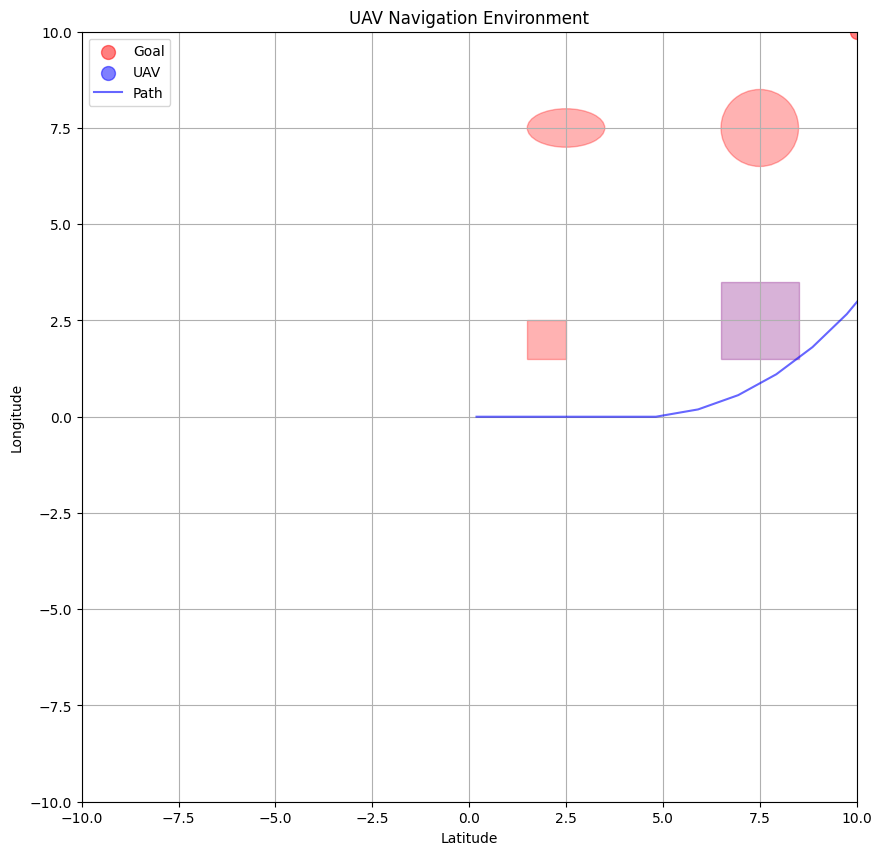

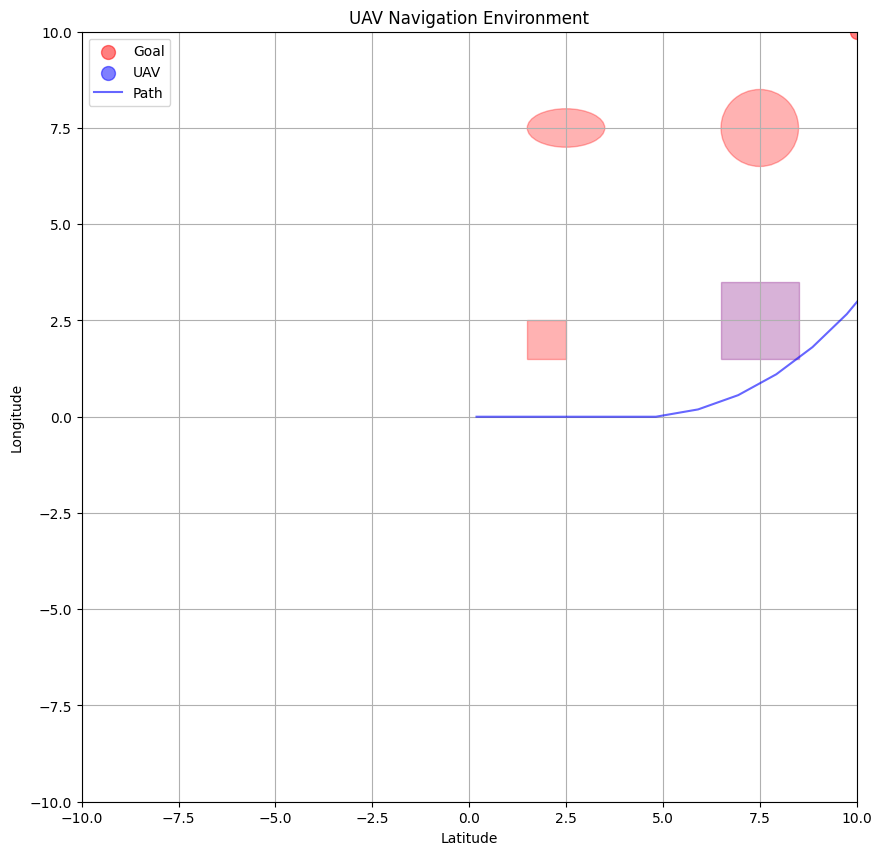

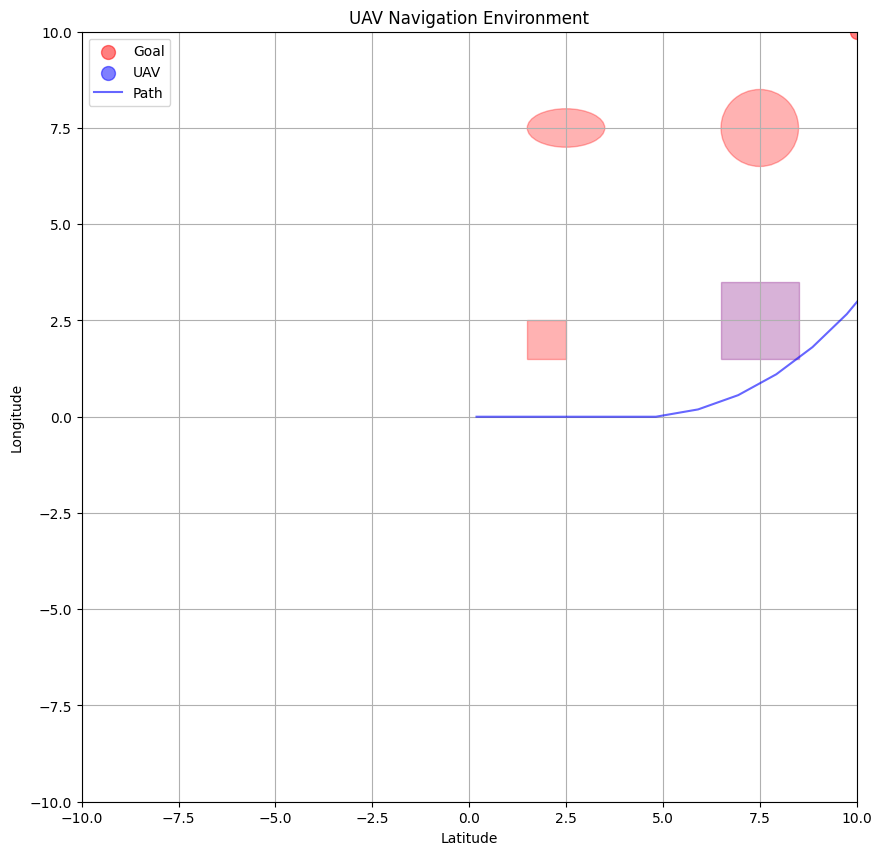

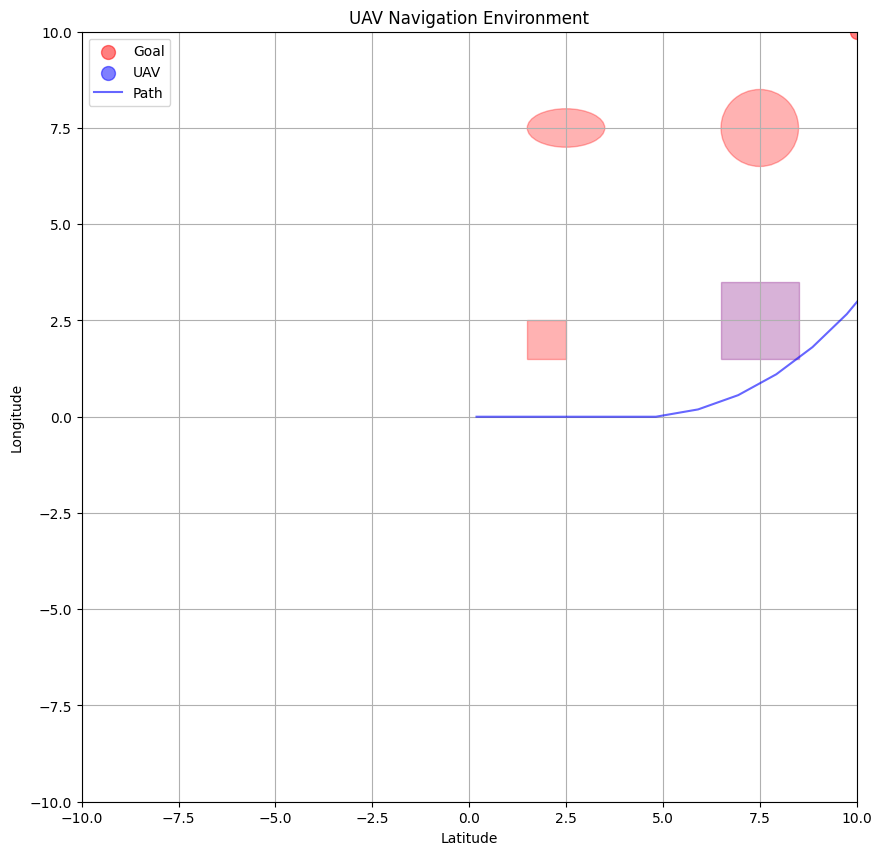

Goal reached!


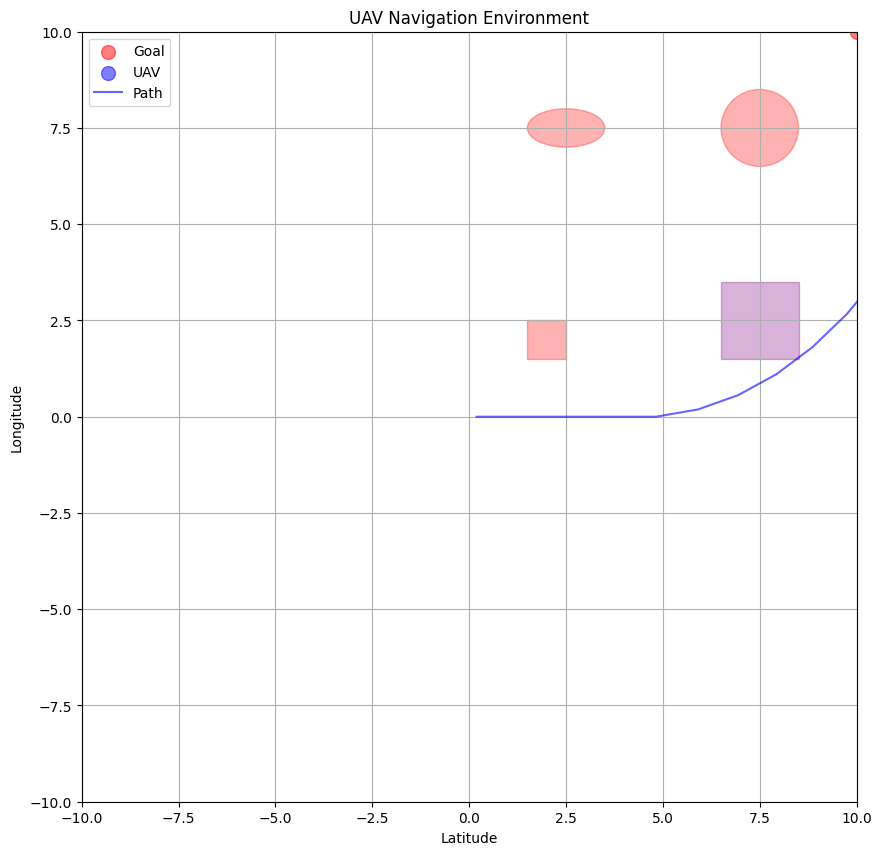

Episode finished after 23 timesteps


In [8]:
# Create a single environment instance for testing
test_env = UAVEnv()

# Reset the environment and get the initial observation
obs = test_env.reset()

# Prepare to collect UAV's path for visualization
path_x, path_y = [], []

# Set the number of steps you want to watch
num_steps = 1000

for step in range(num_steps):
    # Append current UAV position to path
    path_x.append(obs[0])
    path_y.append(obs[1])
    
    # Predict the action with the highest probability using your model
    action, _ = model.predict(obs, deterministic=True)
    
    # Take the action in the environment
    obs, reward, done, info = test_env.step(action)
    
    # Render the environment (optional here, only for visual feedback in Jupyter)
    test_env.render()
    
    # Break the loop if the episode is done
    if done:
        print(f"Episode finished after {step + 1} timesteps")
        break
    
    # Pause a bit between frames for easier visualization (optional)
    time.sleep(0.05)

# Function to update the plot for each frame of the animation
def update(frame):
    """Update function for the animation."""
    ax.clear()
    ax.set_xlim((0, test_env.env_bounds[0]))
    ax.set_ylim((0, test_env.env_bounds[1]))

    # Plot target position
    ax.plot(test_env.goal_position[0], test_env.goal_position[1], 'ro', label='Target')

    # Plot obstacles
    for obstacle in test_env.obstacles:
        if obstacle['type'] == 'rectangle':
            rect = patches.Rectangle((obstacle['position'][0] - obstacle['width'] / 2,
                                      obstacle['position'][1] - obstacle['height'] / 2),
                                     obstacle['width'], obstacle['height'],
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        elif obstacle['type'] == 'circle':
            circle = patches.Circle(obstacle['position'][:2], obstacle['radius'],
                                    linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(circle)
        elif obstacle['type'] == 'ellipse':
            ellipse = patches.Ellipse(obstacle['position'][:2], obstacle['width'],
                                      obstacle['height'], linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(ellipse)
            
            
        
    for zone in test_env.no_fly_zones:
        if zone['type'] == 'rectangle':
            rect = patches.Rectangle((zone['position'][0] - zone['width'] / 2,
                                      zone['position'][1] - zone['height'] / 2),
                                     zone['width'], zone['height'],
                                     linewidth=1, edgecolor='purple', facecolor='purple', alpha=0.5)
            ax.add_patch(rect)

    # Plot UAV path up to the current frame
    ax.plot(path_x[:frame], path_y[:frame], 'b-', label='UAV Path')
    ax.legend()

    return ax

# Create the animation
fig, ax = plt.subplots(figsize=(6, 6))
anim = FuncAnimation(fig, update, frames=min(num_steps, len(path_x)), blit=False)

# Save the animation as a .gif
anim.save('UAV-with-no-fly-zone-LLA.gif', writer='pillow', fps=5)

plt.close(fig)  # Close the figure to prevent it from displaying in the notebook


This code defines a Q-learning neural network architecture (`QNetwork`) using TensorFlow's Keras API. It also initializes the environment (`UAVEnv`), sets up the training parameters, and implements the training loop.

### Neural Network Architecture
The `QNetwork` class defines a neural network with two dense layers of 64 units each, followed by an output layer with `num_actions` units. ReLU activation functions are used for the hidden layers, while the output layer has no activation function.

### Initialization
- The environment (`env`) and the Q-network (`q_network`) are initialized.
- A target network (`target_network`) is created with the same architecture as the Q-network, and its weights are initialized to match those of the Q-network.

### Training Parameters
- Adam optimizer with a learning rate of 0.001 is used.
- The discount factor (`gamma`) is set to 0.99.
- The replay buffer (`replay_buffer`) is a deque with a maximum length of 10,000.
- The batch size for training (`batch_size`) is set to 32.

### Training Loop
- The training loop runs for `num_episodes` episodes.
- Within each episode:
  - The environment is reset (`env.reset()`), and the initial state is obtained.
  - The episode reward is initialized to 0, and the episode continues until termination.
  - Within each step of the episode:
    - An action is chosen using an epsilon-greedy policy.
    - The chosen action is applied to the environment, and the next state, reward, and termination signal are obtained.
    - The transition (state, action, reward, next_state, done) is stored in the replay buffer.
    - If the replay buffer contains enough transitions, a minibatch is sampled from it.
    - Target Q-values are computed using the target network.
    - The Q-network is updated using the sampled minibatch and target Q-values.
    - The target network is updated periodically by copying the weights from the Q-network.

### Episode Statistics
- After each episode, the episode number and the total reward accumulated during the episode are printed.



In [14]:
# Define neural network architecture
class QNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(QNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation=None)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize environment and neural network
env = UAVEnv()
num_actions = env.action_space.n
q_network = QNetwork(num_actions)
target_network = QNetwork(num_actions)
target_network.set_weights(q_network.get_weights())

# Define training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
gamma = 0.99  # Discount factor
batch_size = 32
replay_buffer = deque(maxlen=10000)

# Define the number of episodes for training
num_episodes = 1000

# Define exploration-exploitation trade-off parameter (epsilon)
epsilon = 0.1  # Adjust this as needed

# Initialize total steps counter
total_steps = 0

# Define the frequency of updating the target network
target_update_freq = 100  # Adjust this as needed

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.randint(num_actions)
        else:
            q_values = q_network(np.expand_dims(state, axis=0))
            action = np.argmax(q_values)

        # Take action
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        # Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state

        # Ensure replay buffer contains enough transitions before sampling
        if len(replay_buffer) >= batch_size:
            # Sample minibatch from replay buffer
            minibatch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*minibatch)

            # Compute target Q-values
            next_q_values = target_network(np.array(next_states))
            max_next_q_values = np.max(next_q_values, axis=1)
            targets = np.array(rewards) + (1 - np.array(dones)) * gamma * max_next_q_values

            # Update Q-network
            with tf.GradientTape() as tape:
                q_values = q_network(np.array(states))
                selected_q_values = tf.reduce_sum(q_values * tf.one_hot(actions, num_actions), axis=1)
                loss = tf.reduce_mean(tf.square(targets - selected_q_values))
            grads = tape.gradient(loss, q_network.trainable_variables)
            optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

            # Update target network
            if total_steps % target_update_freq == 0:
                target_network.set_weights(q_network.get_weights())

    # Print episode statistics
    print(f"Episode: {episode}, Reward: {episode_reward}")


Max steps exceeded.
Episode: 0, Reward: 5.958962511243845
Max steps exceeded.
Episode: 1, Reward: -8.012164225947151
Max steps exceeded.
Episode: 2, Reward: -10.998350211588619
Max steps exceeded.
Episode: 3, Reward: -16.104047198036465
Max steps exceeded.
Episode: 4, Reward: -17.490106783605025
Max steps exceeded.
Episode: 5, Reward: -9.121707154917056
Max steps exceeded.
Episode: 6, Reward: -4.842007468359885
Max steps exceeded.
Episode: 7, Reward: -6.028315415305465
Max steps exceeded.
Episode: 8, Reward: -10.42256926347196
Max steps exceeded.
Episode: 9, Reward: -7.916505128070455
Max steps exceeded.
Episode: 10, Reward: 4.513449038204132
Max steps exceeded.
Episode: 11, Reward: 0.44579202318341676
Goal reached!
Episode: 12, Reward: 112.04137999269321
Max steps exceeded.
Episode: 13, Reward: -3.6350544969118985
Max steps exceeded.
Episode: 14, Reward: -5.542932783602734
Max steps exceeded.
Episode: 15, Reward: 1.231143295171348
Max steps exceeded.
Episode: 16, Reward: -2.0169021409

This code defines an objective function `objective(trial)` for hyperparameter optimization using Optuna. The objective function aims to find optimal hyperparameters for the Q-learning algorithm implemented in the context of the `UAVEnv` environment and the `QNetwork` neural network architecture.

### Objective Function
- The `objective` function takes a `trial` object as input, which is used to suggest hyperparameter values for optimization.
- Hyperparameters to be optimized:
  - Learning rate (`learning_rate`): Suggested within a log-uniform distribution between 1e-5 and 1e-2.
  - Batch size (`batch_size`): Suggested from a categorical set of values `[32, 64, 128]`.
  - Epsilon (`epsilon`): Suggested within a uniform distribution between 0.01 and 0.2.
  - Gamma (`gamma`): Suggested within a uniform distribution between 0.9 and 0.99.

### Model Setup
- The `UAVEnv` environment is initialized, and the number of actions (`num_actions`) is obtained from the environment.
- `QNetwork` and `target_network` instances are created based on the `QNetwork` class.
- The weights of the `target_network` are set to match those of the `q_network`.

### Training Setup
- Adam optimizer with the suggested learning rate is used.
- A replay buffer (`replay_buffer`) of maximum length 10,000 is created.
- `total_steps` and `target_update_freq` variables are initialized for training control.
- The number of episodes (`num_episodes`) is set to 50 for faster trials.

### Training Loop
- The training loop runs for `num_episodes` episodes.
- Within each episode:
  - The environment is reset, and the initial state is obtained.
  - The episode continues until termination, and within each step:
    - An action is chosen using an epsilon-greedy policy.
    - The chosen action is applied to the environment, and the next state, reward, and termination signal are obtained.
    - Transitions are stored in the replay buffer.
    - If the replay buffer contains enough transitions, a minibatch is sampled, and the Q-network is updated.
    - The target network is periodically updated to match the Q-network.

### Objective Evaluation
- The objective function returns the average reward over the last 10 episodes (`average_reward`) as the optimization metric.



In [17]:
# Assuming UAVEnv and QNetwork are already defined as per your existing code.

def objective(trial):
    # Environment setup
    env = UAVEnv()
    num_actions = env.action_space.n

    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epsilon = trial.suggest_uniform('epsilon', 0.01, 0.2)
    gamma = trial.suggest_uniform('gamma', 0.9, 0.99)

    # Model setup
    q_network = QNetwork(num_actions)
    target_network = QNetwork(num_actions)
    target_network.set_weights(q_network.get_weights())

    # Optimizer setup
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    replay_buffer = deque(maxlen=10000)
    total_steps = 0
    target_update_freq = 100
    num_episodes = 50  # Reduced number of episodes for faster trials

    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = np.random.randint(num_actions)
            else:
                q_values = q_network(np.expand_dims(state, axis=0))
                action = np.argmax(q_values)

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward

            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state

            if len(replay_buffer) >= batch_size:
                minibatch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                next_q_values = target_network(np.array(next_states))
                max_next_q_values = np.max(next_q_values, axis=1)
                targets = np.array(rewards) + (1 - np.array(dones)) * gamma * max_next_q_values

                with tf.GradientTape() as tape:
                    q_values = q_network(np.array(states))
                    selected_q_values = tf.reduce_sum(q_values * tf.one_hot(actions, num_actions), axis=1)
                    loss = tf.reduce_mean(tf.square(targets - selected_q_values))
                grads = tape.gradient(loss, q_network.trainable_variables)
                optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

                if total_steps % target_update_freq == 0:
                    target_network.set_weights(q_network.get_weights())

            total_steps += 1

        episode_rewards.append(episode_reward)

    average_reward = np.mean(episode_rewards[-10:])  # Focus on the last 10 episodes' performance
    return average_reward


This code block initializes an Optuna study object, conducts hyperparameter optimization using the defined objective function, and prints the best trial along with its corresponding hyperparameters.

### Hyperparameter Optimization
- A study object named `study` is created using `optuna.create_study()`, specifying the optimization direction as 'maximize' since the objective function aims to maximize the average reward.
- Optimization is performed using the `study.optimize()` function, which takes the defined `objective` function as input and conducts a specified number of trials (`n_trials`).
- In each trial, the objective function is executed with suggested hyperparameters, and the average reward is used as the optimization metric.

### Best Trial Information
- After optimization, the best trial information is printed.
- The best trial is obtained using `study.best_trial`.
- The value of the best trial (i.e., the maximum average reward achieved) is printed.
- The hyperparameters corresponding to the best trial are printed, showing each hyperparameter's name and value.

In [18]:
# Create a study object and perform optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')

print('Best hyperparameters:')
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2024-04-30 17:40:53,234] A new study created in memory with name: no-name-21338303-8546-4aa7-8736-93bc97d1c8c2
C:\Users\ammar\myuav\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\ammar\AppData\Local\Temp\ipykernel_21324\2010009686.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\ammar\AppData\Local\Temp\ipykernel_21324\2010009686.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform('epsilon', 0.01, 0.2)
C:\Users\ammar\AppData\Loc

Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obs

[I 2024-04-30 17:42:38,522] Trial 0 finished with value: 2.541343690102162 and parameters: {'learning_rate': 3.323992718342429e-05, 'batch_size': 64, 'epsilon': 0.0538072715617546, 'gamma': 0.900839143031443}. Best is trial 0 with value: 2.541343690102162.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Co

[I 2024-04-30 17:44:13,596] Trial 1 finished with value: 4.188442443999274 and parameters: {'learning_rate': 4.2730017607200704e-05, 'batch_size': 128, 'epsilon': 0.0374368669757426, 'gamma': 0.924465489649662}. Best is trial 1 with value: 4.188442443999274.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Max steps exceeded.


[I 2024-04-30 17:46:06,799] Trial 2 finished with value: -6.102661279556038 and parameters: {'learning_rate': 1.853862159603044e-05, 'batch_size': 64, 'epsilon': 0.10322008464502383, 'gamma': 0.9670866906797358}. Best is trial 1 with value: 4.188442443999274.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exc

[I 2024-04-30 17:48:12,720] Trial 3 finished with value: 41.952776229707716 and parameters: {'learning_rate': 0.0003284879844988309, 'batch_size': 128, 'epsilon': 0.03116170747631085, 'gamma': 0.9886187264407758}. Best is trial 3 with value: 41.952776229707716.


Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with a

[I 2024-04-30 17:50:01,346] Trial 4 finished with value: 0.0073158866512909706 and parameters: {'learning_rate': 0.0014434834006460864, 'batch_size': 32, 'epsilon': 0.0607987159172077, 'gamma': 0.914161646935573}. Best is trial 3 with value: 41.952776229707716.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceed

[I 2024-04-30 17:52:22,921] Trial 5 finished with value: -3.8572870018670797 and parameters: {'learning_rate': 0.006994072727973096, 'batch_size': 32, 'epsilon': 0.09486251072150116, 'gamma': 0.9760351005367399}. Best is trial 3 with value: 41.952776229707716.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidan

[I 2024-04-30 17:54:16,924] Trial 6 finished with value: 16.02577845566247 and parameters: {'learning_rate': 0.0011534908070651557, 'batch_size': 32, 'epsilon': 0.03824722270784672, 'gamma': 0.9720010646243435}. Best is trial 3 with value: 41.952776229707716.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures

[I 2024-04-30 17:56:13,459] Trial 7 finished with value: -12.621910573597315 and parameters: {'learning_rate': 0.003297061335190021, 'batch_size': 32, 'epsilon': 0.1753101664595651, 'gamma': 0.9735072339186551}. Best is trial 3 with value: 41.952776229707716.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exce

[I 2024-04-30 17:57:54,168] Trial 8 finished with value: 7.294953737410114 and parameters: {'learning_rate': 5.4033233261380666e-05, 'batch_size': 128, 'epsilon': 0.01837831566213371, 'gamma': 0.9243330136515272}. Best is trial 3 with value: 41.952776229707716.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Goal reached!
Collision detected! Taking avoidance measures.
Collision

[I 2024-04-30 17:59:30,143] Trial 9 finished with value: -29.83824999099604 and parameters: {'learning_rate': 0.0016268073582716553, 'batch_size': 64, 'epsilon': 0.11857280877706965, 'gamma': 0.9291249229036302}. Best is trial 3 with value: 41.952776229707716.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle

[I 2024-04-30 18:01:01,837] Trial 10 finished with value: 38.09249431513065 and parameters: {'learning_rate': 0.00021726593856637313, 'batch_size': 128, 'epsilon': 0.1924915114641669, 'gamma': 0.9889809452897844}. Best is trial 3 with value: 41.952776229707716.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taki

[I 2024-04-30 18:02:13,776] Trial 11 finished with value: 3.2384290688976387 and parameters: {'learning_rate': 0.0002375623337884694, 'batch_size': 128, 'epsilon': 0.19574744431357993, 'gamma': 0.9518407959090085}. Best is trial 3 with value: 41.952776229707716.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance m

[I 2024-04-30 18:03:07,340] Trial 12 finished with value: 18.623133547540352 and parameters: {'learning_rate': 0.0002521375874222203, 'batch_size': 128, 'epsilon': 0.1476366653572418, 'gamma': 0.9860749479095015}. Best is trial 3 with value: 41.952776229707716.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an 

[I 2024-04-30 18:04:58,699] Trial 13 finished with value: 37.64292086684794 and parameters: {'learning_rate': 0.000516349432427948, 'batch_size': 128, 'epsilon': 0.1568226019868642, 'gamma': 0.9897336160729128}. Best is trial 3 with value: 41.952776229707716.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Coll

[I 2024-04-30 18:06:40,013] Trial 14 finished with value: 0.01690550816699843 and parameters: {'learning_rate': 0.00011402387277022082, 'batch_size': 128, 'epsilon': 0.07955220426192797, 'gamma': 0.9541080673057464}. Best is trial 3 with value: 41.952776229707716.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance m

[I 2024-04-30 18:08:28,110] Trial 15 finished with value: 0.9435532471055957 and parameters: {'learning_rate': 0.000503224547981665, 'batch_size': 128, 'epsilon': 0.12873142132230894, 'gamma': 0.9600594399988248}. Best is trial 3 with value: 41.952776229707716.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected

[I 2024-04-30 18:09:08,716] Trial 16 finished with value: 3.2903242841749334 and parameters: {'learning_rate': 0.00011920934931527719, 'batch_size': 128, 'epsilon': 0.19649156313162042, 'gamma': 0.9399303307386195}. Best is trial 3 with value: 41.952776229707716.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Collision detected! Takin

[I 2024-04-30 18:10:51,409] Trial 17 finished with value: 103.51136896541998 and parameters: {'learning_rate': 0.00014352750758708725, 'batch_size': 128, 'epsilon': 0.015618328831480208, 'gamma': 0.9820779029669962}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Colli

[I 2024-04-30 18:13:18,858] Trial 18 finished with value: 1.0439237042184621 and parameters: {'learning_rate': 9.423891018398736e-05, 'batch_size': 128, 'epsilon': 0.013867053853221931, 'gamma': 0.9816386038756694}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an ob

[I 2024-04-30 18:13:48,507] Trial 19 finished with value: 3.614326873357041 and parameters: {'learning_rate': 0.00047093564786919115, 'batch_size': 64, 'epsilon': 0.06927993104626914, 'gamma': 0.9647566218748923}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps ex

[I 2024-04-30 18:15:22,628] Trial 20 finished with value: -6.350547114591586 and parameters: {'learning_rate': 1.9712505778056756e-05, 'batch_size': 128, 'epsilon': 0.042012836453282035, 'gamma': 0.941897090874601}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max

[I 2024-04-30 18:17:47,067] Trial 21 finished with value: 33.29635283198782 and parameters: {'learning_rate': 0.00020874715756289387, 'batch_size': 128, 'epsilon': 0.023155331803841394, 'gamma': 0.981439246718739}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoid

[I 2024-04-30 18:19:43,358] Trial 22 finished with value: 67.65642300369225 and parameters: {'learning_rate': 0.0008245984152443265, 'batch_size': 128, 'epsilon': 0.08383897619762389, 'gamma': 0.9882083988494945}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision d

[I 2024-04-30 18:21:41,485] Trial 23 finished with value: 58.42109639929555 and parameters: {'learning_rate': 0.0008275596389403889, 'batch_size': 128, 'epsilon': 0.08399070080565452, 'gamma': 0.9786386439278418}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measure

[I 2024-04-30 18:23:02,176] Trial 24 finished with value: 20.289801775427975 and parameters: {'learning_rate': 0.0009229907957776254, 'batch_size': 128, 'epsilon': 0.08439360313460675, 'gamma': 0.9782221933014579}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.


[I 2024-04-30 18:25:03,001] Trial 25 finished with value: 4.367773986138848 and parameters: {'learning_rate': 0.002519483563293386, 'batch_size': 128, 'epsilon': 0.11816812390928003, 'gamma': 0.9675809615434232}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected

[I 2024-04-30 18:26:42,076] Trial 26 finished with value: 6.408888340322461 and parameters: {'learning_rate': 0.0008197780148716592, 'batch_size': 128, 'epsilon': 0.0815625009569482, 'gamma': 0.9570103178628493}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.


[I 2024-04-30 18:28:53,028] Trial 27 finished with value: 1.8977120767403828 and parameters: {'learning_rate': 0.005292157223725979, 'batch_size': 128, 'epsilon': 0.052911847011698515, 'gamma': 0.9815560334876064}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded

[I 2024-04-30 18:31:09,157] Trial 28 finished with value: -3.449754343256191 and parameters: {'learning_rate': 0.0032124142399941277, 'batch_size': 32, 'epsilon': 0.14083233783219967, 'gamma': 0.9711926824598781}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.


[I 2024-04-30 18:41:17,574] Trial 29 finished with value: 37.669484321145816 and parameters: {'learning_rate': 7.211520735748959e-05, 'batch_size': 64, 'epsilon': 0.06250372544970716, 'gamma': 0.9492319260196087}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measure

[I 2024-04-30 18:43:16,512] Trial 30 finished with value: 39.04004128741892 and parameters: {'learning_rate': 0.009974437513356953, 'batch_size': 64, 'epsilon': 0.0946716119453484, 'gamma': 0.9053983650372305}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with 

[I 2024-04-30 18:45:21,787] Trial 31 finished with value: 0.6280609786857589 and parameters: {'learning_rate': 0.00036060476244419506, 'batch_size': 128, 'epsilon': 0.047489805866608836, 'gamma': 0.9860488977415202}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.

[I 2024-04-30 18:47:47,863] Trial 32 finished with value: -0.6739577375471372 and parameters: {'learning_rate': 0.00016345653239389563, 'batch_size': 128, 'epsilon': 0.03280245934607619, 'gamma': 0.981953641846349}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures

[I 2024-04-30 18:49:51,261] Trial 33 finished with value: 0.4427903193833821 and parameters: {'learning_rate': 0.0006289853286653383, 'batch_size': 128, 'epsilon': 0.030291437700895263, 'gamma': 0.9899875575697993}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!

[I 2024-04-30 18:51:35,662] Trial 34 finished with value: 60.471786068493245 and parameters: {'learning_rate': 0.001909709886958341, 'batch_size': 128, 'epsilon': 0.06965441331052777, 'gamma': 0.9640307061908026}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.


[I 2024-04-30 18:53:11,161] Trial 35 finished with value: 13.806910851558262 and parameters: {'learning_rate': 0.001905472538504771, 'batch_size': 128, 'epsilon': 0.10856370551126164, 'gamma': 0.9612075742853038}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance me

[I 2024-04-30 18:56:08,320] Trial 36 finished with value: 3.6322629663443293 and parameters: {'learning_rate': 1.0101647157423713e-05, 'batch_size': 128, 'epsilon': 0.06622638017960841, 'gamma': 0.967375274867939}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
C

[I 2024-04-30 19:47:40,639] Trial 37 finished with value: -4.291794353542074 and parameters: {'learning_rate': 0.0010629808768909197, 'batch_size': 32, 'epsilon': 0.09580977143218118, 'gamma': 0.9737699505710448}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance 

[I 2024-04-30 19:49:20,100] Trial 38 finished with value: 90.86730246932076 and parameters: {'learning_rate': 0.0007725613168891772, 'batch_size': 128, 'epsilon': 0.07303995315794069, 'gamma': 0.9762275269232752}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision d

[I 2024-04-30 19:51:04,739] Trial 39 finished with value: -12.727630110703398 and parameters: {'learning_rate': 0.0023070333971313035, 'batch_size': 64, 'epsilon': 0.07063156301683957, 'gamma': 0.9708351708470444}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measure

[I 2024-04-30 19:52:04,772] Trial 40 finished with value: 0.4681101362474996 and parameters: {'learning_rate': 0.00518371740053638, 'batch_size': 32, 'epsilon': 0.10425463785925818, 'gamma': 0.9619242925526736}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max step

[I 2024-04-30 19:54:21,439] Trial 41 finished with value: -4.44134888128877 and parameters: {'learning_rate': 0.0013169383722679224, 'batch_size': 128, 'epsilon': 0.054195691154264154, 'gamma': 0.9767014462230056}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoid

[I 2024-04-30 19:56:01,373] Trial 42 finished with value: 52.3727503081159 and parameters: {'learning_rate': 0.000724540899839583, 'batch_size': 128, 'epsilon': 0.07504381815740195, 'gamma': 0.9776846359681098}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.

[I 2024-04-30 19:58:04,293] Trial 43 finished with value: -14.031474530983013 and parameters: {'learning_rate': 0.0014813619000757427, 'batch_size': 128, 'epsilon': 0.0883054688695203, 'gamma': 0.9854002084330344}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!


[I 2024-04-30 20:00:12,872] Trial 44 finished with value: 48.77528880671513 and parameters: {'learning_rate': 0.00037162878430636816, 'batch_size': 128, 'epsilon': 0.05594071063937654, 'gamma': 0.9783456298488546}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Goal reached!
Goal reached!


[I 2024-04-30 20:01:42,743] Trial 45 finished with value: 52.33576575946654 and parameters: {'learning_rate': 0.0011157126198083562, 'batch_size': 128, 'epsilon': 0.11090647802187965, 'gamma': 0.9832638595357069}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision wi

[I 2024-04-30 20:03:45,145] Trial 46 finished with value: 1.1410216549182521 and parameters: {'learning_rate': 0.0006210328501160952, 'batch_size': 128, 'epsilon': 0.09640042562885724, 'gamma': 0.9699105286573236}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measu

[I 2024-04-30 20:05:49,697] Trial 47 finished with value: -4.598699819199713 and parameters: {'learning_rate': 0.002219384242704628, 'batch_size': 128, 'epsilon': 0.08783978559194255, 'gamma': 0.9743018923966609}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measur

[I 2024-04-30 20:08:01,903] Trial 48 finished with value: 11.833810167778596 and parameters: {'learning_rate': 0.0003190646112354884, 'batch_size': 32, 'epsilon': 0.04608559453870615, 'gamma': 0.932149412144612}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision

[I 2024-04-30 20:10:07,662] Trial 49 finished with value: 11.299777140922519 and parameters: {'learning_rate': 3.5544296839133816e-05, 'batch_size': 128, 'epsilon': 0.07589812109679955, 'gamma': 0.9855362972158854}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision w

[I 2024-04-30 20:13:49,186] Trial 50 finished with value: 1.8657389682979884 and parameters: {'learning_rate': 0.003751813549329757, 'batch_size': 128, 'epsilon': 0.12782945428399642, 'gamma': 0.9651928820232397}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected

[I 2024-04-30 20:16:04,606] Trial 51 finished with value: -9.503763025529999 and parameters: {'learning_rate': 0.0007329966036761544, 'batch_size': 128, 'epsilon': 0.07078382552146661, 'gamma': 0.9790794209594088}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidanc

[I 2024-04-30 20:18:00,561] Trial 52 finished with value: 5.785170337621157 and parameters: {'learning_rate': 0.0004155061385013788, 'batch_size': 128, 'epsilon': 0.07725933084875036, 'gamma': 0.9764968606112964}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected!

[I 2024-04-30 20:20:13,016] Trial 53 finished with value: 25.990518976662628 and parameters: {'learning_rate': 0.0016494312005972042, 'batch_size': 128, 'epsilon': 0.010969336161233356, 'gamma': 0.9738648909786494}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision

[I 2024-04-30 20:20:36,384] Trial 54 finished with value: 13.38737079520765 and parameters: {'learning_rate': 0.0005854350884887027, 'batch_size': 128, 'epsilon': 0.08999867350283189, 'gamma': 0.9865076609498825}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal 

[I 2024-04-30 20:22:11,852] Trial 55 finished with value: 47.89821574905962 and parameters: {'learning_rate': 0.0008436393063154956, 'batch_size': 128, 'epsilon': 0.05948890514262936, 'gamma': 0.979413926295515}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance

[I 2024-04-30 20:24:19,475] Trial 56 finished with value: 40.029878869703985 and parameters: {'learning_rate': 0.0002687028056309291, 'batch_size': 128, 'epsilon': 0.0724765784297269, 'gamma': 0.9690713437991423}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Goal reached!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidanc

[I 2024-04-30 20:25:46,730] Trial 57 finished with value: -28.21953495703898 and parameters: {'learning_rate': 0.0009197397928441169, 'batch_size': 64, 'epsilon': 0.10012037723467423, 'gamma': 0.9836353458570183}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstac

[I 2024-04-30 20:27:21,288] Trial 58 finished with value: 93.54341225226828 and parameters: {'learning_rate': 0.0001793464237977374, 'batch_size': 128, 'epsilon': 0.0802724038579101, 'gamma': 0.9632870403885371}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.


[I 2024-04-30 20:29:00,368] Trial 59 finished with value: 2.218970694471143 and parameters: {'learning_rate': 0.0001709519673349812, 'batch_size': 128, 'epsilon': 0.023453832416016458, 'gamma': 0.9459006878833988}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Col

[I 2024-04-30 20:31:04,299] Trial 60 finished with value: 21.813362380658532 and parameters: {'learning_rate': 0.00013360877630305318, 'batch_size': 128, 'epsilon': 0.16684043539009152, 'gamma': 0.9578306489023677}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision 

[I 2024-04-30 20:33:29,662] Trial 61 finished with value: -16.06686777549928 and parameters: {'learning_rate': 8.792453296230227e-05, 'batch_size': 128, 'epsilon': 0.0808993165629406, 'gamma': 0.9648240642698341}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected

[I 2024-04-30 20:34:34,049] Trial 62 finished with value: -7.731821262112892 and parameters: {'learning_rate': 5.220396828434818e-05, 'batch_size': 128, 'epsilon': 0.06635020555242886, 'gamma': 0.9545059954623317}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance m

[I 2024-04-30 20:36:02,572] Trial 63 finished with value: 17.36322146568657 and parameters: {'learning_rate': 0.00047705333715746467, 'batch_size': 128, 'epsilon': 0.08678757909330967, 'gamma': 0.9876756305429716}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Coll

[I 2024-04-30 20:36:44,856] Trial 64 finished with value: 15.647895520470692 and parameters: {'learning_rate': 0.00018945974778623154, 'batch_size': 128, 'epsilon': 0.06165623747623657, 'gamma': 0.9801835874927499}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoida

[I 2024-04-30 20:38:01,160] Trial 65 finished with value: -46.46853937849592 and parameters: {'learning_rate': 0.001186360366375836, 'batch_size': 128, 'epsilon': 0.11527604911209832, 'gamma': 0.9746722556518493}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision 

[I 2024-04-30 20:40:06,014] Trial 66 finished with value: 26.005577129046152 and parameters: {'learning_rate': 0.00025238943807883525, 'batch_size': 128, 'epsilon': 0.07653119937663824, 'gamma': 0.9720800943882686}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking

[I 2024-04-30 20:41:06,407] Trial 67 finished with value: 3.795500053447527 and parameters: {'learning_rate': 0.0006953851266017563, 'batch_size': 32, 'epsilon': 0.036373531170839926, 'gamma': 0.9837681138529905}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obsta

[I 2024-04-30 20:42:11,206] Trial 68 finished with value: -14.01527581775172 and parameters: {'learning_rate': 0.00043877526241437617, 'batch_size': 64, 'epsilon': 0.08262289471067327, 'gamma': 0.9194997006276918}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected!

[I 2024-04-30 20:43:36,081] Trial 69 finished with value: 1.626718631152905 and parameters: {'learning_rate': 0.00014141076051009136, 'batch_size': 128, 'epsilon': 0.10039715804270541, 'gamma': 0.9764293537773252}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measur

[I 2024-04-30 20:45:35,390] Trial 70 finished with value: -2.0632684819774454 and parameters: {'learning_rate': 0.0001031813101938635, 'batch_size': 128, 'epsilon': 0.04826132265248673, 'gamma': 0.9629564383343998}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
M

[I 2024-04-30 20:48:07,699] Trial 71 finished with value: -11.175435954533043 and parameters: {'learning_rate': 0.0010744237211450455, 'batch_size': 128, 'epsilon': 0.12858635735787313, 'gamma': 0.9827718682345552}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detec

[I 2024-04-30 20:50:09,904] Trial 72 finished with value: 5.434105368225654 and parameters: {'learning_rate': 0.0019141443094148763, 'batch_size': 128, 'epsilon': 0.11168238901036791, 'gamma': 0.9839194043393874}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!


[I 2024-04-30 20:51:39,908] Trial 73 finished with value: 59.13665746922381 and parameters: {'learning_rate': 0.0013775350550166176, 'batch_size': 128, 'epsilon': 0.0919198325589303, 'gamma': 0.9800219276880677}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision

[I 2024-04-30 20:53:43,187] Trial 74 finished with value: -12.652896915330755 and parameters: {'learning_rate': 0.0015228466131055817, 'batch_size': 128, 'epsilon': 0.0930151288950011, 'gamma': 0.9879939214059436}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected

[I 2024-04-30 20:55:48,499] Trial 75 finished with value: -7.076415591568589 and parameters: {'learning_rate': 0.0031981013282369394, 'batch_size': 128, 'epsilon': 0.06558531916159993, 'gamma': 0.989872115946026}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max step

[I 2024-04-30 20:58:17,337] Trial 76 finished with value: -9.490320398758271 and parameters: {'learning_rate': 0.0008200101991525664, 'batch_size': 128, 'epsilon': 0.07437253726071211, 'gamma': 0.9803731678238823}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps ex

[I 2024-04-30 21:00:57,156] Trial 77 finished with value: 92.72760224748563 and parameters: {'learning_rate': 0.0005305617604517057, 'batch_size': 128, 'epsilon': 0.08381310060515379, 'gamma': 0.9774233931928731}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Goal

[I 2024-04-30 21:02:51,866] Trial 78 finished with value: 73.58581611050518 and parameters: {'learning_rate': 0.0002894805397998357, 'batch_size': 128, 'epsilon': 0.08402163967826068, 'gamma': 0.9682913275005023}. Best is trial 17 with value: 103.51136896541998.


Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exc

[I 2024-04-30 21:04:54,641] Trial 79 finished with value: 8.297197264130777 and parameters: {'learning_rate': 0.00028782029529506937, 'batch_size': 32, 'epsilon': 0.10405964147540722, 'gamma': 0.9675542781202435}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Ma

[I 2024-04-30 21:07:05,080] Trial 80 finished with value: 2.356277602765685 and parameters: {'learning_rate': 0.00021724635654415963, 'batch_size': 128, 'epsilon': 0.09076151058193839, 'gamma': 0.9589146151331731}. Best is trial 17 with value: 103.51136896541998.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!

[I 2024-04-30 21:09:25,346] Trial 81 finished with value: 13.71612282086934 and parameters: {'learning_rate': 7.799635995272419e-05, 'batch_size': 128, 'epsilon': 0.08404215745245341, 'gamma': 0.972355540676943}. Best is trial 17 with value: 103.51136896541998.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoida

[I 2024-04-30 21:10:46,238] Trial 82 finished with value: 104.371021661684 and parameters: {'learning_rate': 0.0005816786580355395, 'batch_size': 128, 'epsilon': 0.09940432873344196, 'gamma': 0.9701913302399167}. Best is trial 82 with value: 104.371021661684.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measure

[I 2024-04-30 21:11:16,878] Trial 83 finished with value: 4.067235399218982 and parameters: {'learning_rate': 0.0005966320867736729, 'batch_size': 128, 'epsilon': 0.09840492648177748, 'gamma': 0.9691023988451892}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Colli

[I 2024-04-30 21:11:57,181] Trial 84 finished with value: 3.9780202863725393 and parameters: {'learning_rate': 0.0003850937297822008, 'batch_size': 128, 'epsilon': 0.08035383630211862, 'gamma': 0.9635743268158832}. Best is trial 82 with value: 104.371021661684.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Goal reached!
Max steps exceeded.
Max steps exceed

[I 2024-04-30 21:13:34,669] Trial 85 finished with value: 12.89012152791839 and parameters: {'learning_rate': 0.0013014267179883073, 'batch_size': 128, 'epsilon': 0.1238111399078629, 'gamma': 0.9663212089857434}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Coll

[I 2024-04-30 21:14:24,133] Trial 86 finished with value: 4.854122313226368 and parameters: {'learning_rate': 0.0004824632317279077, 'batch_size': 64, 'epsilon': 0.10636378375832532, 'gamma': 0.975031507659929}. Best is trial 82 with value: 104.371021661684.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoi

[I 2024-04-30 21:16:24,143] Trial 87 finished with value: 3.1274871370035036 and parameters: {'learning_rate': 0.00032852920080900233, 'batch_size': 128, 'epsilon': 0.09292063729971194, 'gamma': 0.9710448531942121}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstac

[I 2024-04-30 21:17:56,230] Trial 88 finished with value: 38.605333826440365 and parameters: {'learning_rate': 0.0005752680027870236, 'batch_size': 128, 'epsilon': 0.0678720440197536, 'gamma': 0.9603031324417185}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceede

[I 2024-04-30 21:20:16,097] Trial 89 finished with value: -1.0799344649072729 and parameters: {'learning_rate': 0.00015985574924455844, 'batch_size': 128, 'epsilon': 0.08681224676636179, 'gamma': 0.9773685552656854}. Best is trial 82 with value: 104.371021661684.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance 

[I 2024-04-30 21:22:12,243] Trial 90 finished with value: -31.978990159018203 and parameters: {'learning_rate': 0.0009395014400309775, 'batch_size': 128, 'epsilon': 0.1375117898073395, 'gamma': 0.9499582297530761}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Goal reached!
Max 

[I 2024-04-30 21:24:00,553] Trial 91 finished with value: 104.2448685073761 and parameters: {'learning_rate': 0.0019297046162548499, 'batch_size': 128, 'epsilon': 0.18407096146646268, 'gamma': 0.9810540999766971}. Best is trial 82 with value: 104.371021661684.


Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exce

[I 2024-04-30 21:25:59,749] Trial 92 finished with value: -7.660043848381898 and parameters: {'learning_rate': 0.0017904551775201915, 'batch_size': 128, 'epsilon': 0.16557504674193024, 'gamma': 0.9556405665282405}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision 

[I 2024-04-30 21:27:39,595] Trial 93 finished with value: -7.371425309435056 and parameters: {'learning_rate': 0.002220651533764899, 'batch_size': 128, 'epsilon': 0.18501284982085642, 'gamma': 0.9809883676598805}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance m

[I 2024-04-30 21:29:07,252] Trial 94 finished with value: -23.487171233248404 and parameters: {'learning_rate': 0.0026231687959184335, 'batch_size': 128, 'epsilon': 0.09598800543605256, 'gamma': 0.9850998217225329}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance mea

[I 2024-04-30 21:30:39,621] Trial 95 finished with value: -7.633864636093132 and parameters: {'learning_rate': 0.0013360734837570309, 'batch_size': 128, 'epsilon': 0.1508035664987487, 'gamma': 0.9733343882095761}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision w

[I 2024-04-30 21:32:01,237] Trial 96 finished with value: 82.26400774653112 and parameters: {'learning_rate': 0.0009844424153672734, 'batch_size': 128, 'epsilon': 0.059277516477428974, 'gamma': 0.9687990077607629}. Best is trial 82 with value: 104.371021661684.


Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking a

[I 2024-04-30 21:34:34,839] Trial 97 finished with value: -5.252252937426171 and parameters: {'learning_rate': 0.004141230895536552, 'batch_size': 128, 'epsilon': 0.017715831997126195, 'gamma': 0.9693029568961776}. Best is trial 82 with value: 104.371021661684.


Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Goal reached!
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Max steps exceeded.
Goal reached!
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Goal reached!
Max steps exceeded.
Max steps exceeded.
Max steps exceeded.
Goal reached

[I 2024-04-30 21:36:23,898] Trial 98 finished with value: 61.98616833564355 and parameters: {'learning_rate': 0.0009864259353579135, 'batch_size': 32, 'epsilon': 0.057602776990385546, 'gamma': 0.9657546879424355}. Best is trial 82 with value: 104.371021661684.


Goal reached!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Collision 

[I 2024-04-30 21:36:40,748] Trial 99 finished with value: 3.4981532894282337 and parameters: {'learning_rate': 0.0006948263848002696, 'batch_size': 32, 'epsilon': 0.04218077977929275, 'gamma': 0.9760054632218698}. Best is trial 82 with value: 104.371021661684.


Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Best trial:
Value: 104.371021661684
Best hyperparameters:
learning_rate: 0.0005816786580355395
batch_size: 128
epsilon: 0.09940432873344196
gamma: 0.9701913302399167


This code block initializes the environment and the model with hyperparameters optimized through Optuna. It then proceeds to train the model using the optimized hyperparameters.

### Setting Optimized Hyperparameters
- The hyperparameters obtained from the optimization process are set:
  - Learning rate: 0.0005816786580355395
  - Batch size: 128
  - Epsilon (exploration-exploitation trade-off parameter): 0.09940432873344196
  - Gamma (discount factor): 0.9701913302399167

### Environment and Model Initialization
- The environment (`UAVEnv`) is initialized to set up the simulation.
- The Q-network model (`QNetwork`) is initialized with the number of possible actions in the environment.

### Optimizer Setup
- The Adam optimizer is configured with the optimized learning rate.

### Replay Buffer and Training Setups
- A replay buffer is initialized to store transitions for experience replay.
- Other variables such as total steps, target update frequency, and the number of episodes for training are set up.

### Training Loop
- The training loop iterates over the specified number of episodes.
- Within each episode, the environment is reset, and the agent interacts with it.
- The agent's action is selected based on an epsilon-greedy policy.
- Transitions are stored in the replay buffer, and if it contains enough transitions, the Q-network is updated using a mini-batch from the replay buffer.
- The target network is updated periodically to stabilize training.
- Episode rewards are printed for monitoring training progress.


In [19]:
# Set optimized hyperparameters
learning_rate = 0.0005816786580355395
batch_size = 128
epsilon = 0.09940432873344196
gamma = 0.9701913302399167

# Initialize environment and model with optimized parameters
env = UAVEnv()
num_actions = env.action_space.n
q_network = QNetwork(num_actions)
target_network = QNetwork(num_actions)
target_network.set_weights(q_network.get_weights())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Replay buffer and other setups
replay_buffer = deque(maxlen=10000)
total_steps = 0
target_update_freq = 100
num_episodes = 1000  # Number of episodes for extended training

# Training loop with optimized hyperparameters
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        if np.random.rand() < epsilon:
            action = np.random.randint(num_actions)
        else:
            q_values = q_network(np.expand_dims(state, axis=0))
            action = np.argmax(q_values)

        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state

        if len(replay_buffer) >= batch_size:
            minibatch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*minibatch)

            next_q_values = target_network(np.array(next_states))
            max_next_q_values = np.max(next_q_values, axis=1)
            targets = np.array(rewards) + (1 - np.array(dones)) * gamma * max_next_q_values

            with tf.GradientTape() as tape:
                q_values = q_network(np.array(states))
                selected_q_values = tf.reduce_sum(q_values * tf.one_hot(actions, num_actions), axis=1)
                loss = tf.reduce_mean(tf.square(targets - selected_q_values))
            grads = tape.gradient(loss, q_network.trainable_variables)
            optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

            if total_steps % target_update_freq == 0:
                target_network.set_weights(q_network.get_weights())

        total_steps += 1

    print(f"Episode: {episode}, Reward: {episode_reward}")


Max steps exceeded.
Episode: 0, Reward: 5.280459365151315
Episode: 1, Reward: -91.85527225848875
Max steps exceeded.
Episode: 2, Reward: -2.7356789254727345
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Episode: 3, Reward: 1.5451504946239518
Max steps exceeded.
Episode: 4, Reward: -7.273383511671914
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Episode: 5, Reward: 2.7212144854754916
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Episode: 6, Reward: 9.53692964258866
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Episode: 7, Reward: 1.9923005448583702
Collision detected! Taking avoidance measures.
Collision detected! Taking avoidance measures.
Collision with an obstacle!
Episode: 8, Reward: 

This code defines a function `evaluate_model` to assess the performance of a trained Q-network model in the given environment.

### Function: `evaluate_model(env, q_network, num_episodes=10)`
- **Parameters**:
  - `env`: The environment instance where the model will be evaluated.
  - `q_network`: The Q-network model to be evaluated.
  - `num_episodes`: The number of episodes to run for evaluation (default is 10).

- **Evaluation Process**:
  - The function iterates over the specified number of episodes.
  - Within each episode:
    - The environment is reset, and the initial state is obtained.
    - The agent interacts with the environment based on the Q-network's action selections.
    - The episode terminates when a terminal state is reached.
    - The total episode reward is calculated.
  - After all episodes are completed, the average reward over the evaluation episodes is computed.
  - The function prints the average reward as the evaluation result.

### Usage
To evaluate a trained Q-network model, call this function with the trained model and the environment instance where evaluation will be performed. Optionally, you can specify the number of evaluation episodes.


In [20]:
# Evaluate trained model
def evaluate_model(env, q_network, num_episodes=10):
    episode_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            q_values = q_network(np.expand_dims(state, axis=0))
            action = np.argmax(q_values)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
        episode_rewards.append(episode_reward)
    avg_reward = np.mean(episode_rewards)
    print(f"Average reward over {num_episodes} episodes: {avg_reward}")

This code block contains two main functions for evaluating and observing the behavior of a trained Q-network model in a given environment.

### Function: `evaluate_model(env, q_network, num_episodes=10)`
- **Parameters**:
  - `env`: The environment instance where the model will be evaluated.
  - `q_network`: The Q-network model to be evaluated.
  - `num_episodes`: The number of episodes to run for evaluation (default is 10).

- **Evaluation Process**:
  - The function iterates over the specified number of episodes.
  - Within each episode:
    - The environment is reset, and the initial state is obtained.
    - The agent interacts with the environment based on the Q-network's action selections.
    - The episode terminates when a terminal state is reached.
    - The total episode reward is calculated.
  - After all episodes are completed, the average reward over the evaluation episodes is computed.
  - The function prints the average reward as the evaluation result.

### Function: `observe_behavior(env, q_network)`
- **Parameters**:
  - `env`: The environment instance where the model's behavior will be observed.
  - `q_network`: The trained Q-network model whose behavior will be observed.

- **Observation Process**:
  - The function resets the environment and obtains the initial state.
  - The agent iteratively interacts with the environment based on the Q-network's action selections.
  - The environment's rendering is invoked after each action to observe the agent's behavior.
  - The process continues until a terminal state is reached.

### Usage
1. Call `evaluate_model(env, q_network)` to assess the performance of the trained Q-network model in the specified environment.
2. Call `observe_behavior(env, q_network)` to observe the behavior of the trained model in the environment.


Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Average reward over 10 episodes: 115.71881129863667


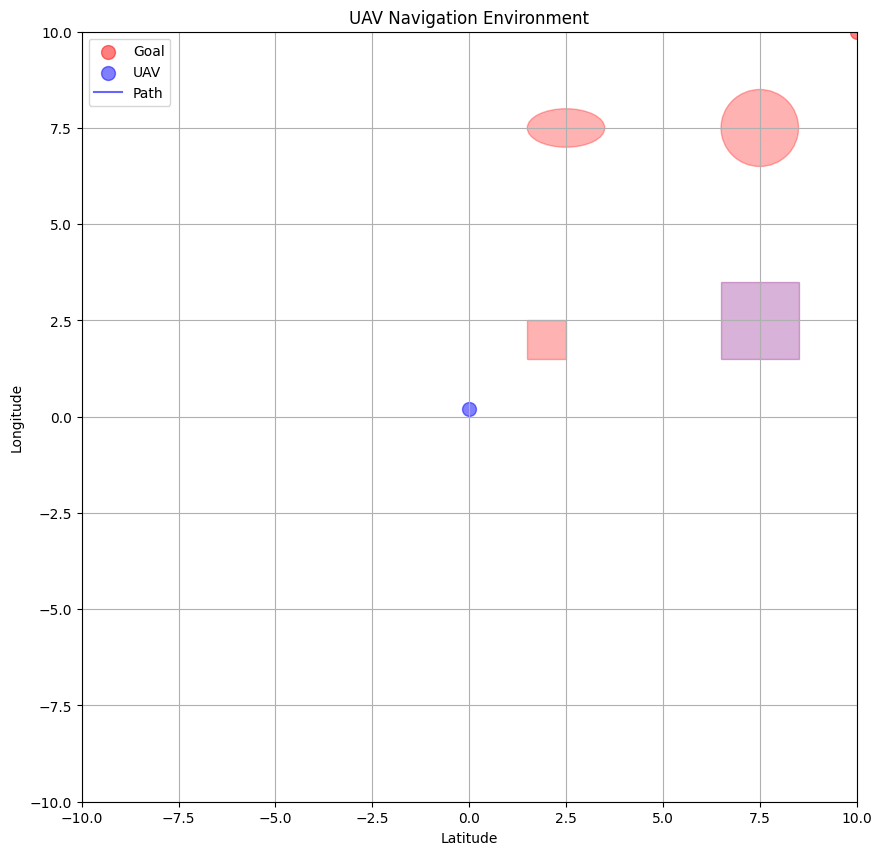

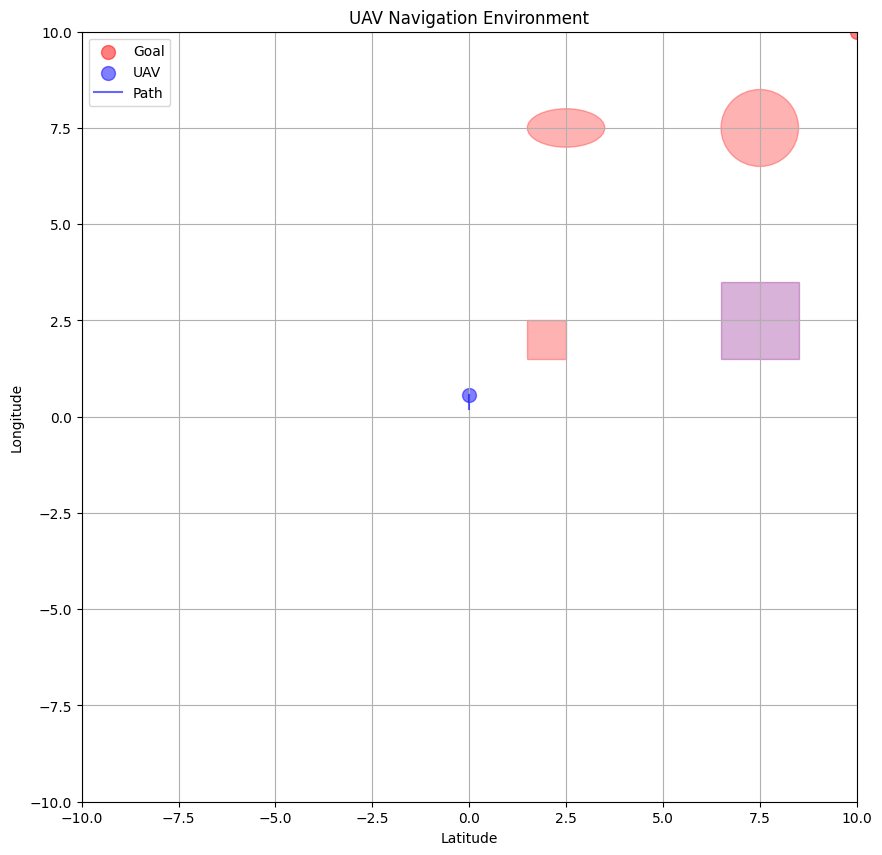

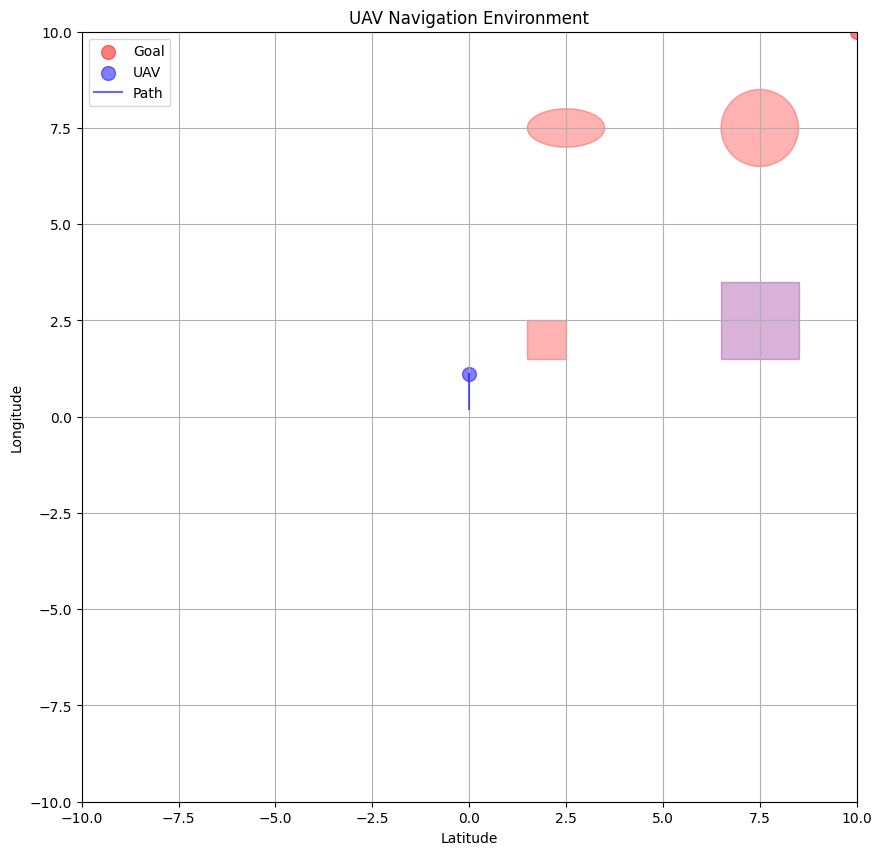

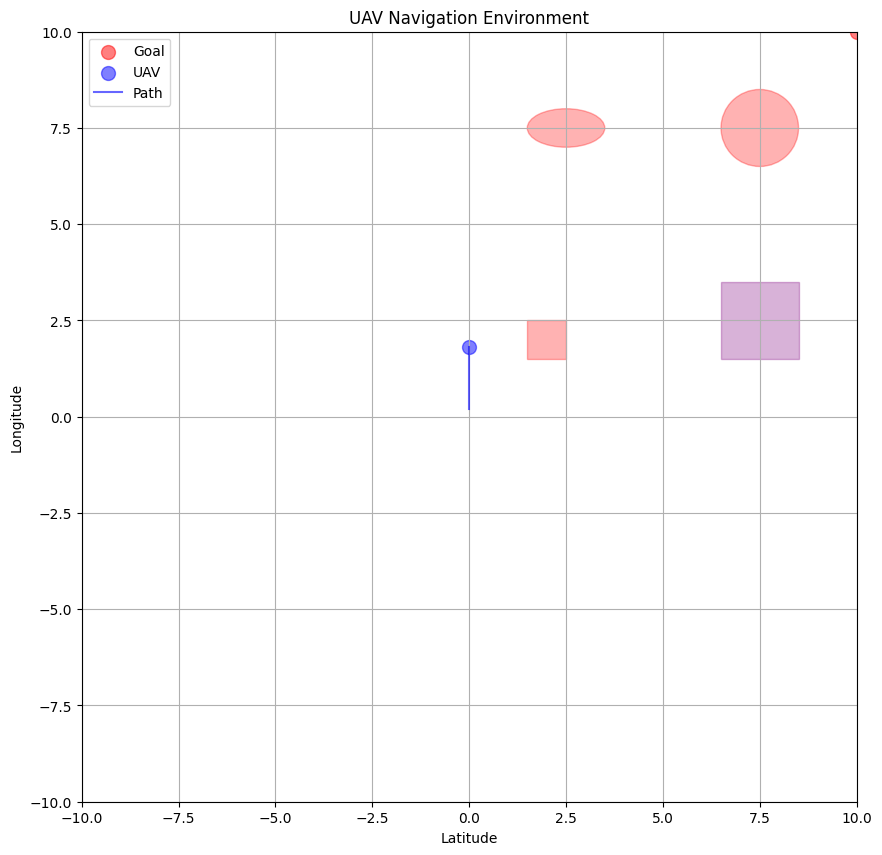

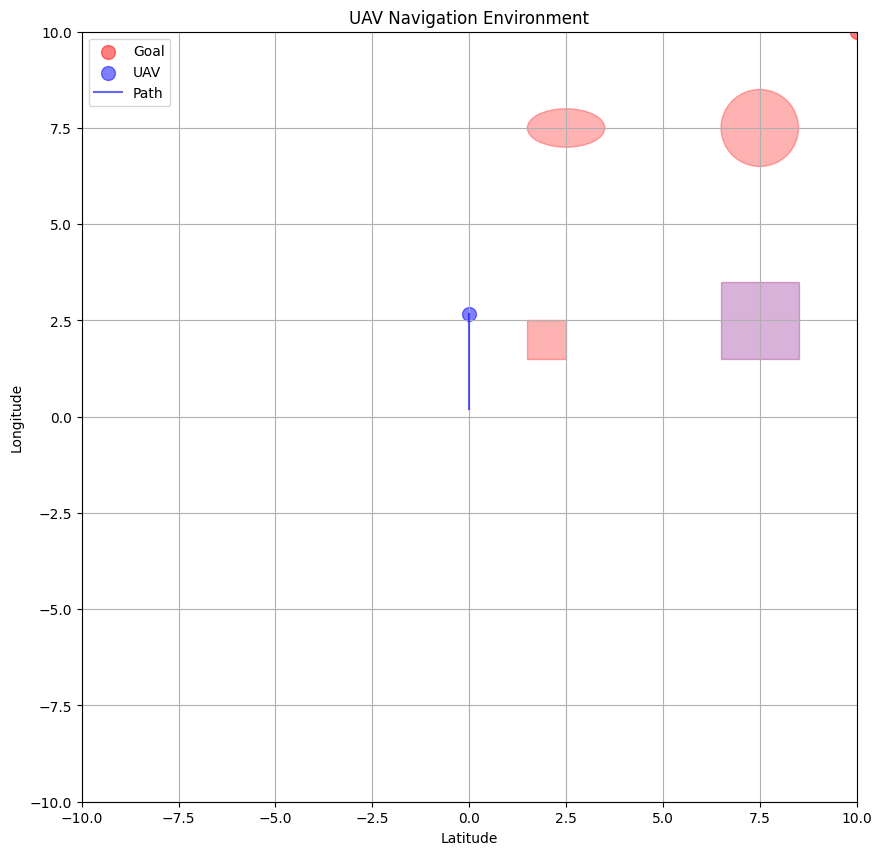

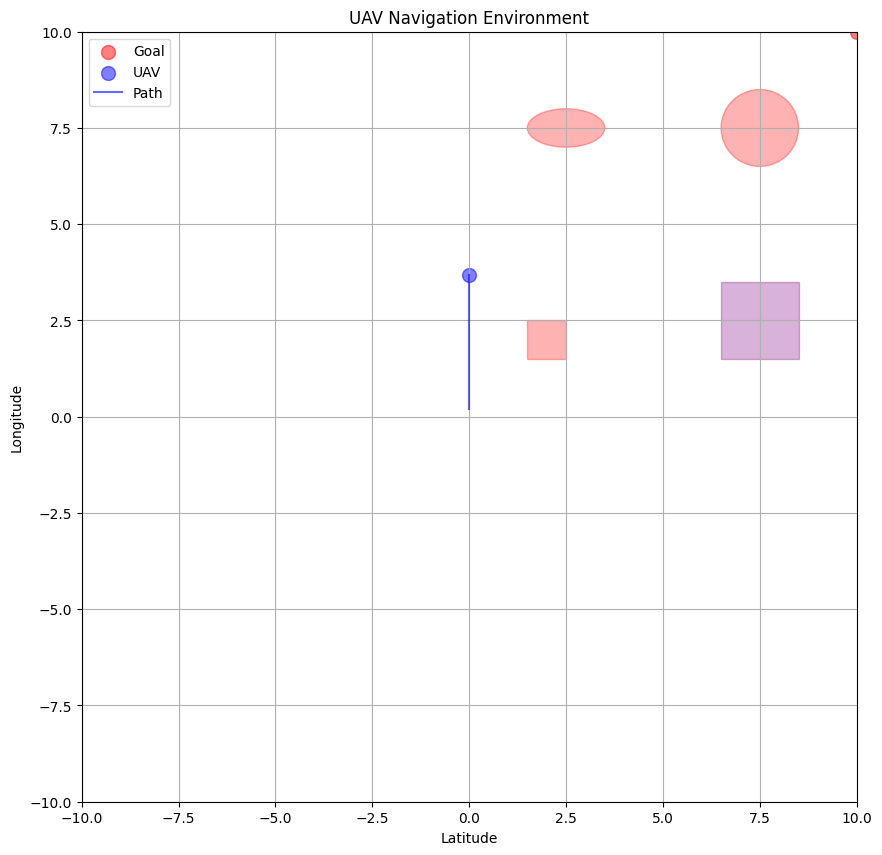

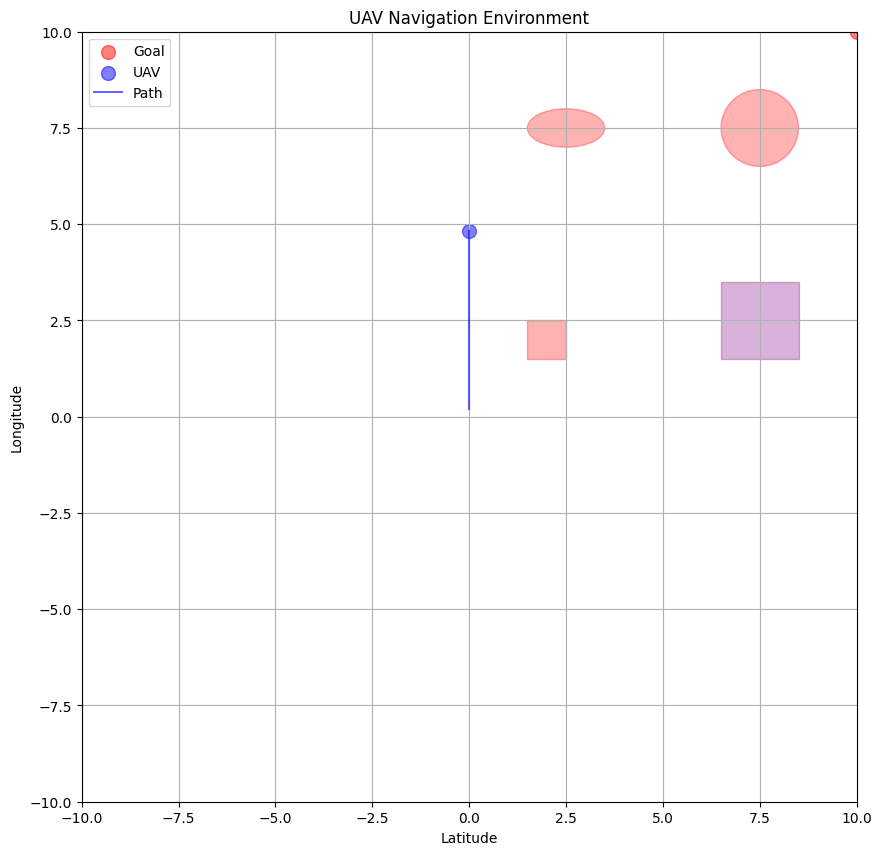

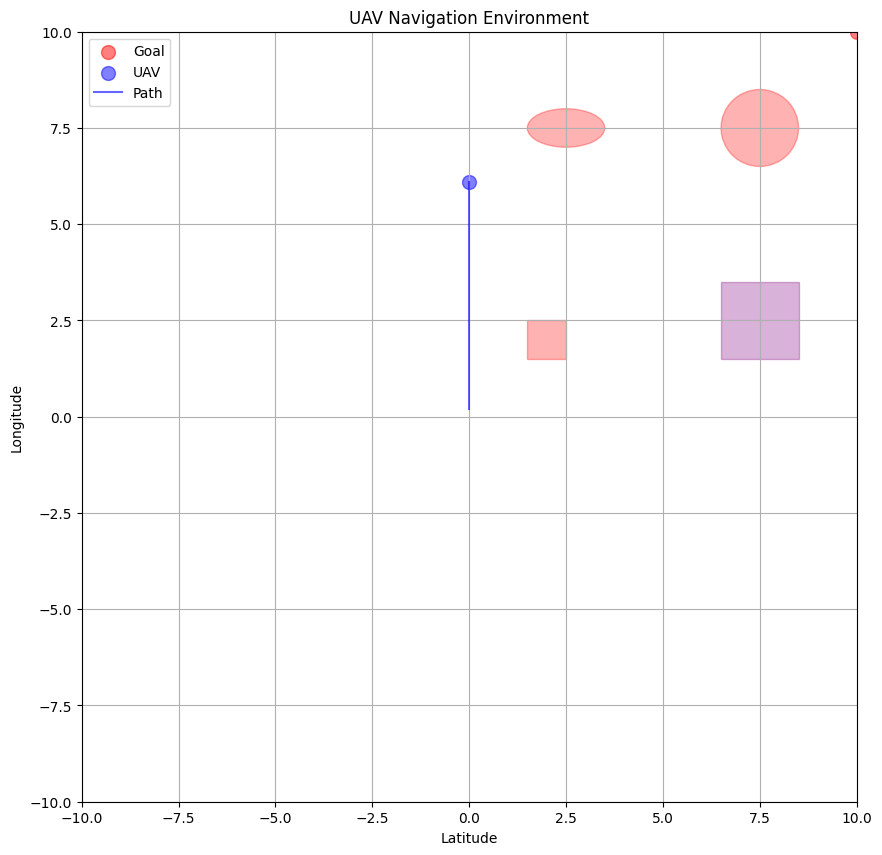

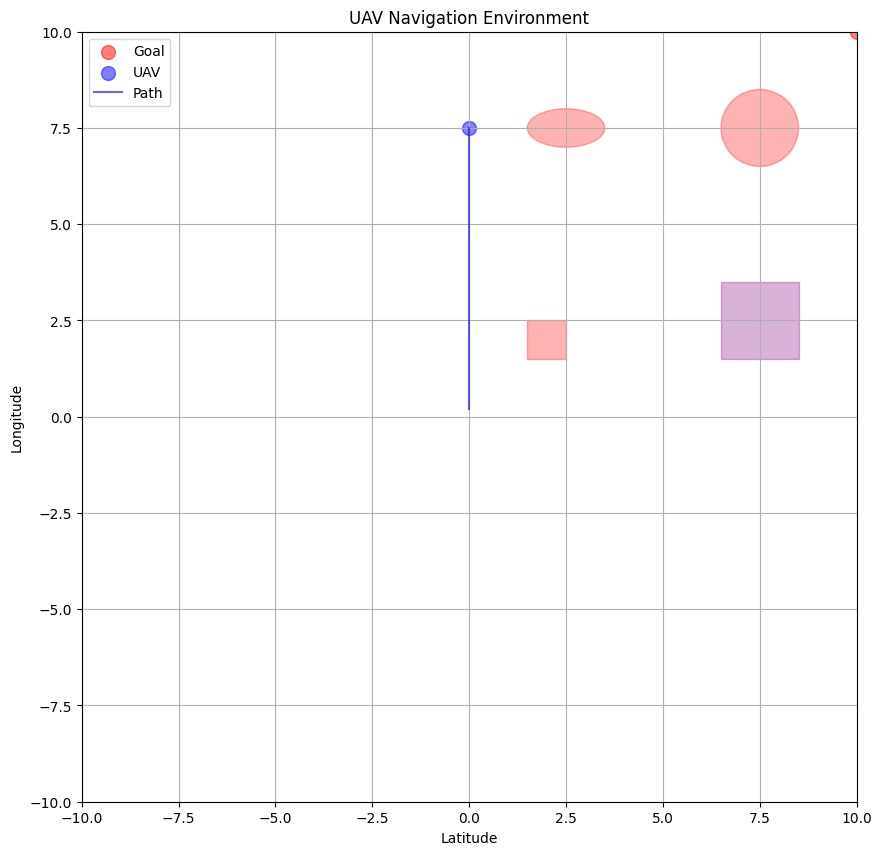

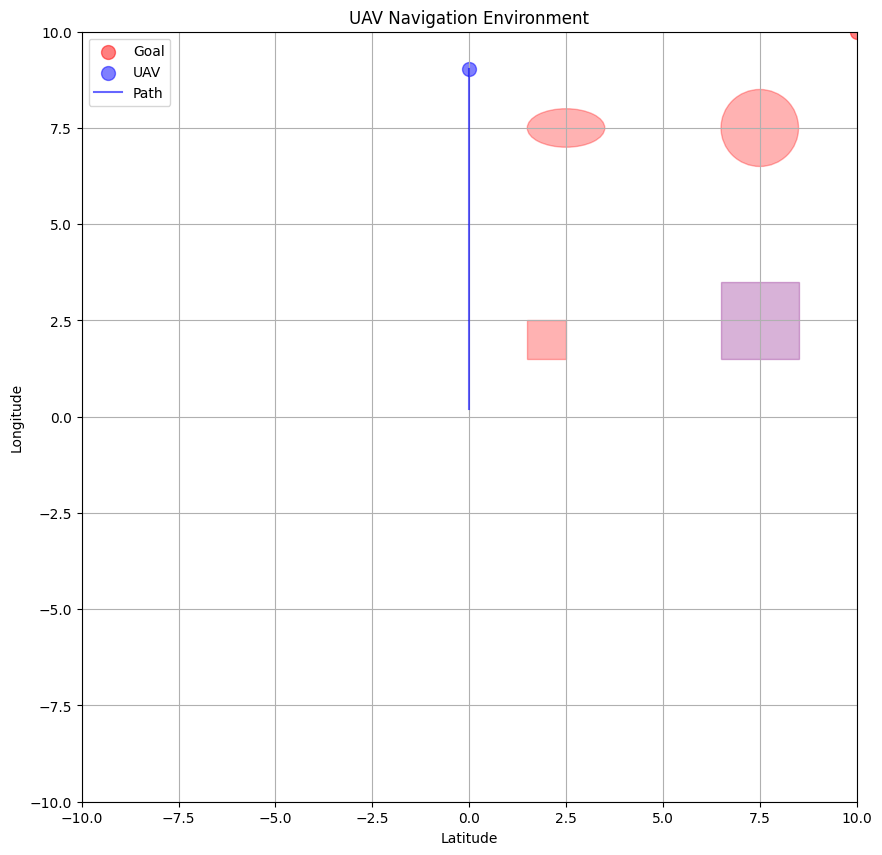

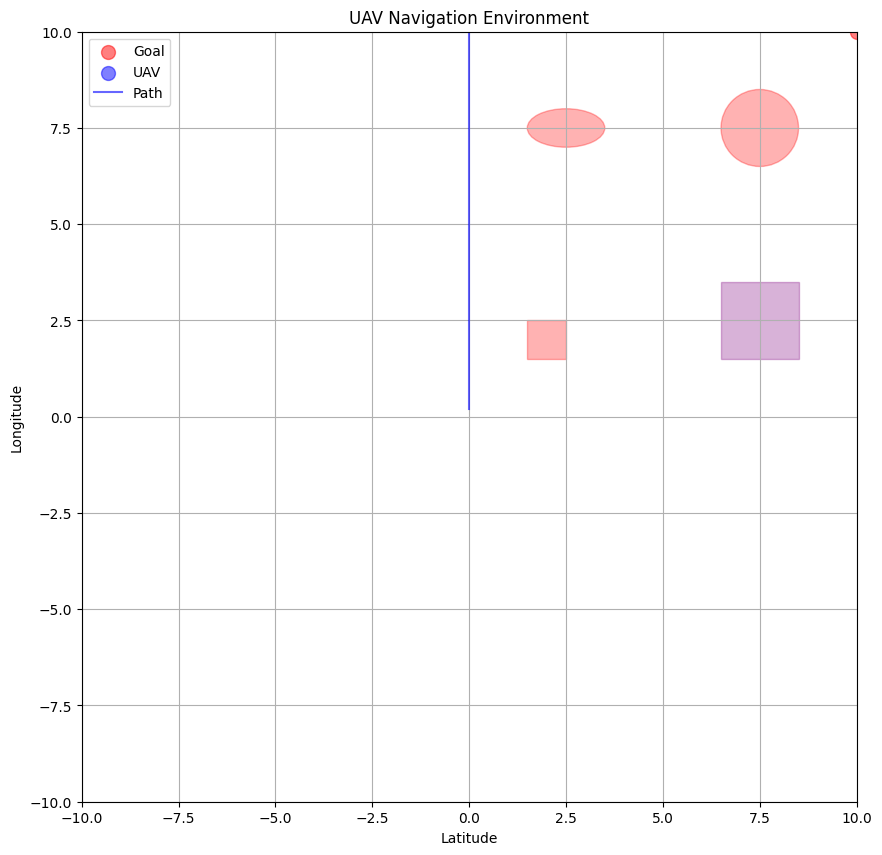

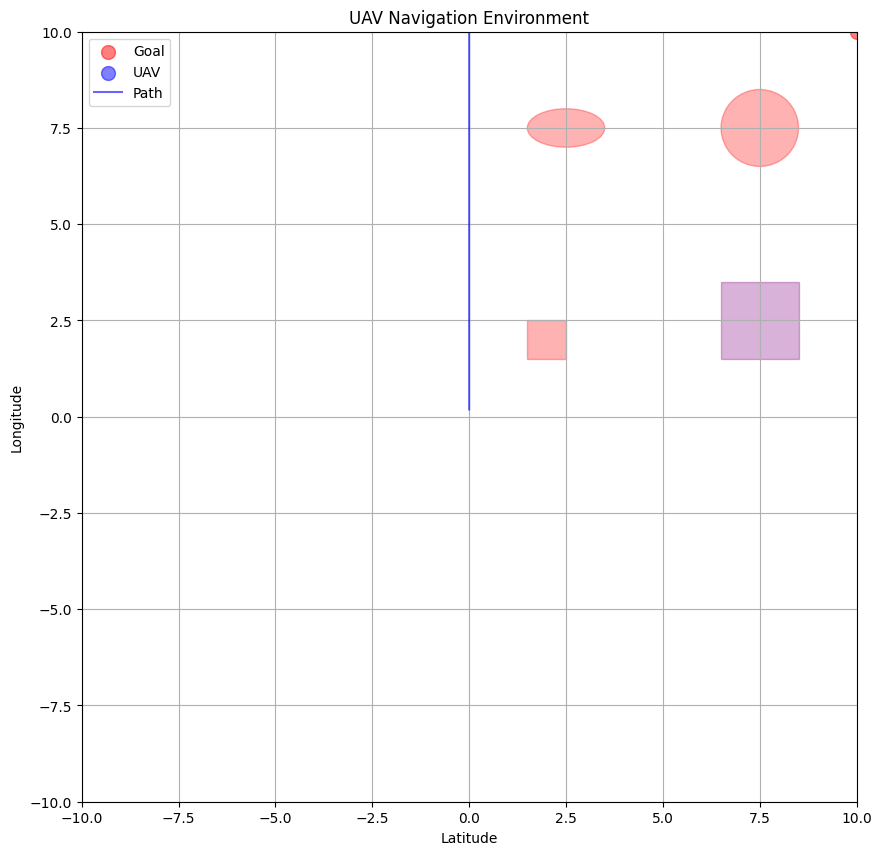

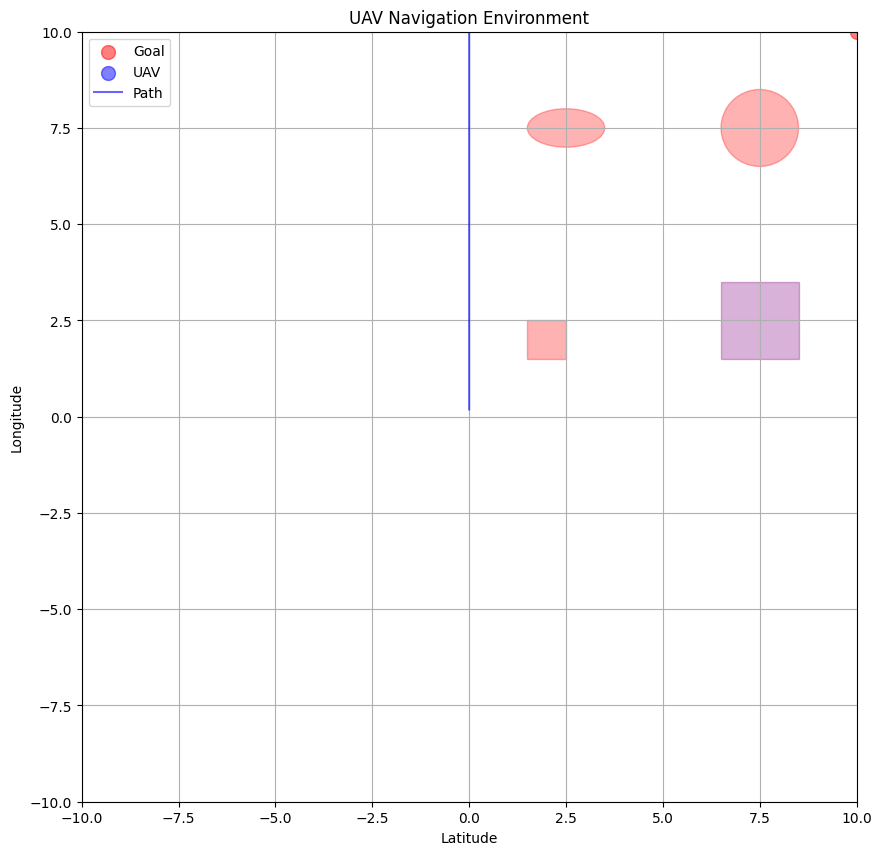

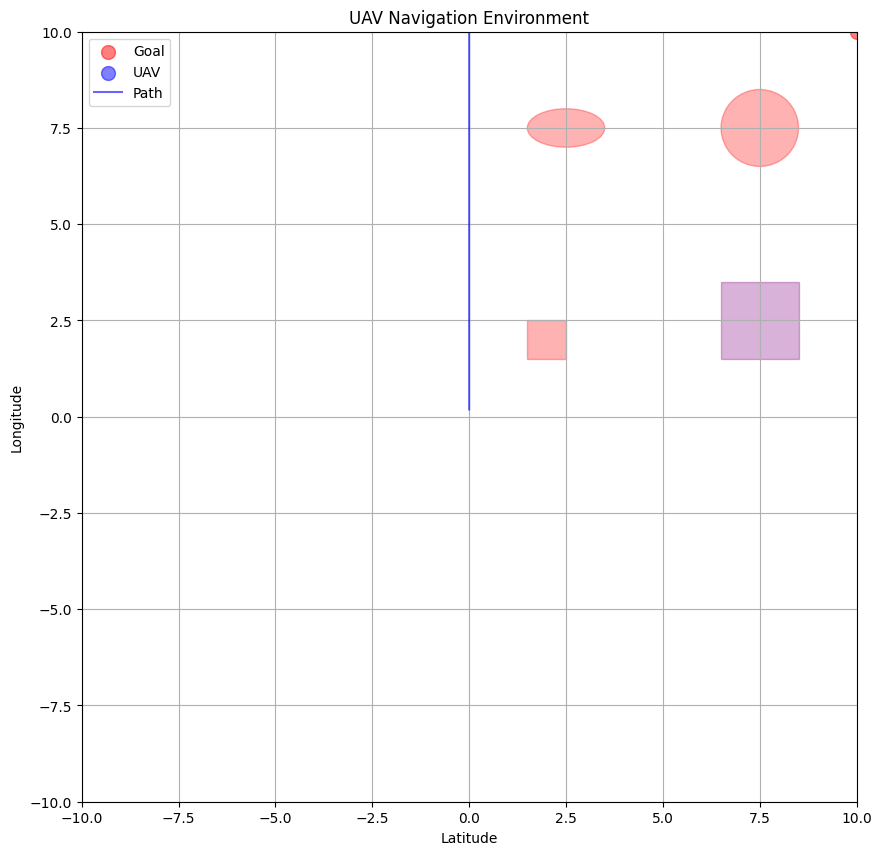

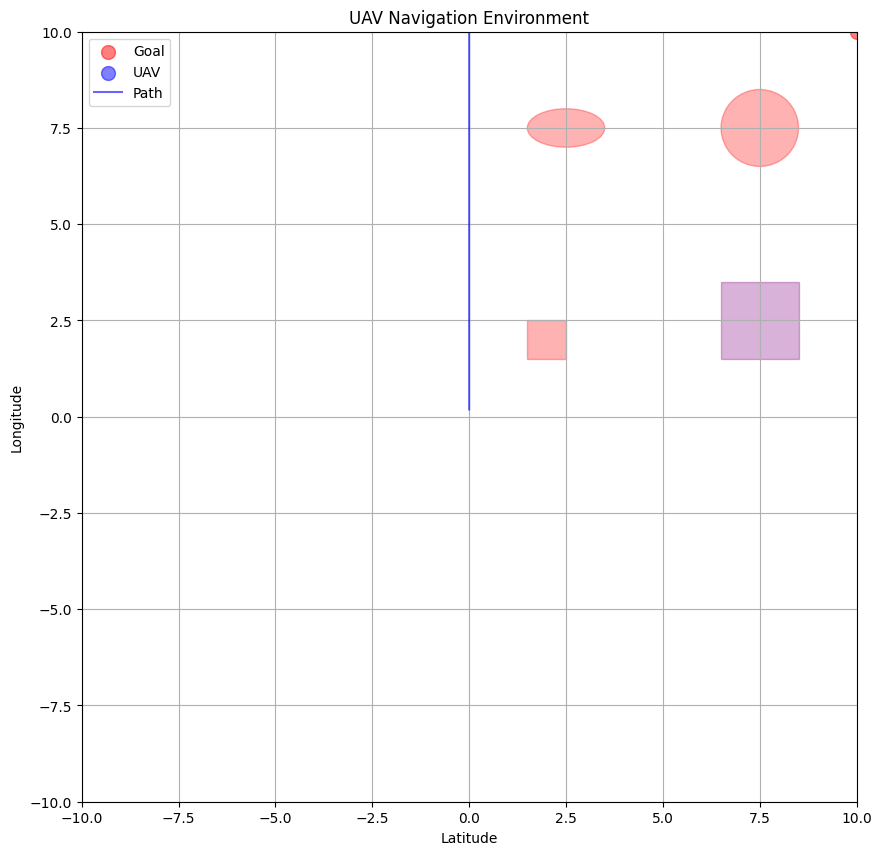

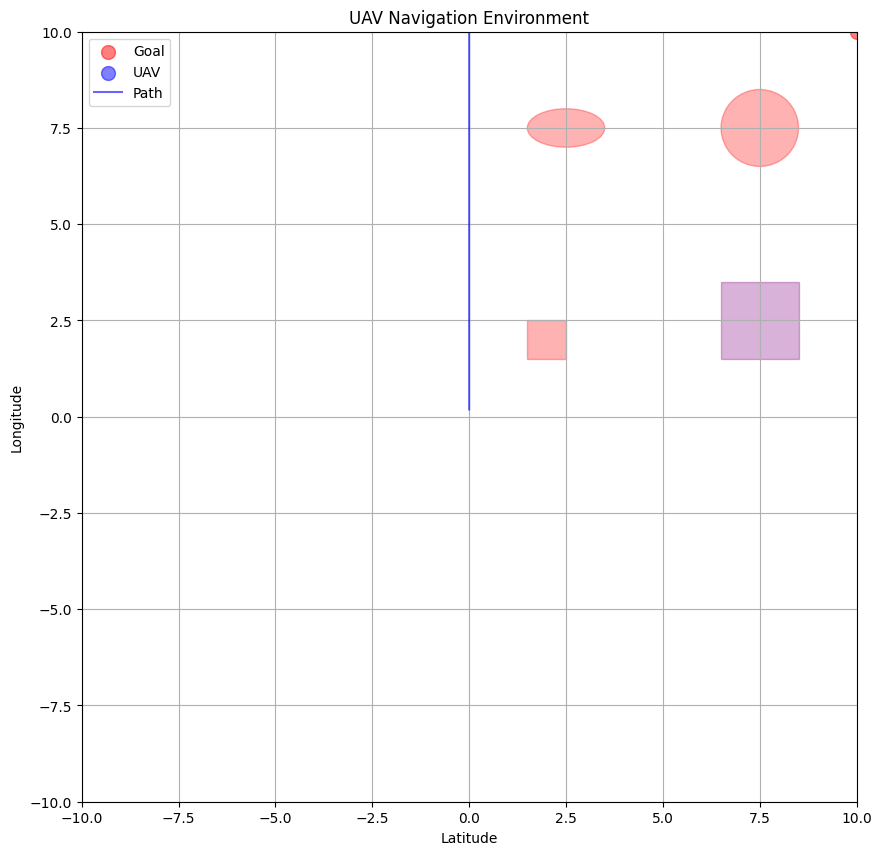

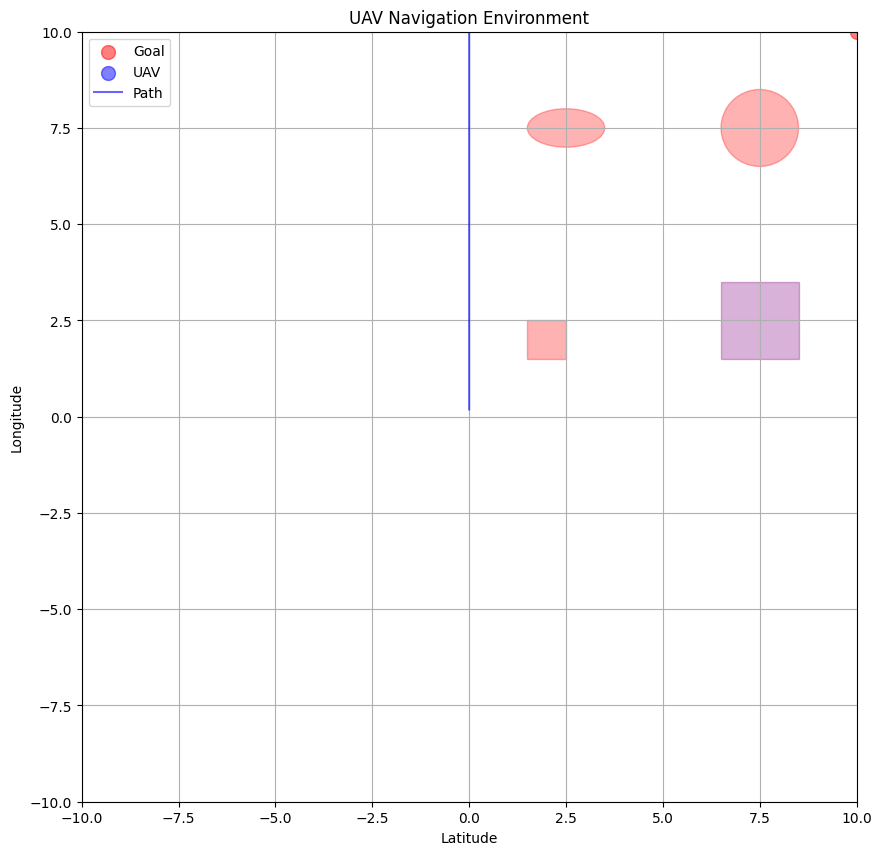

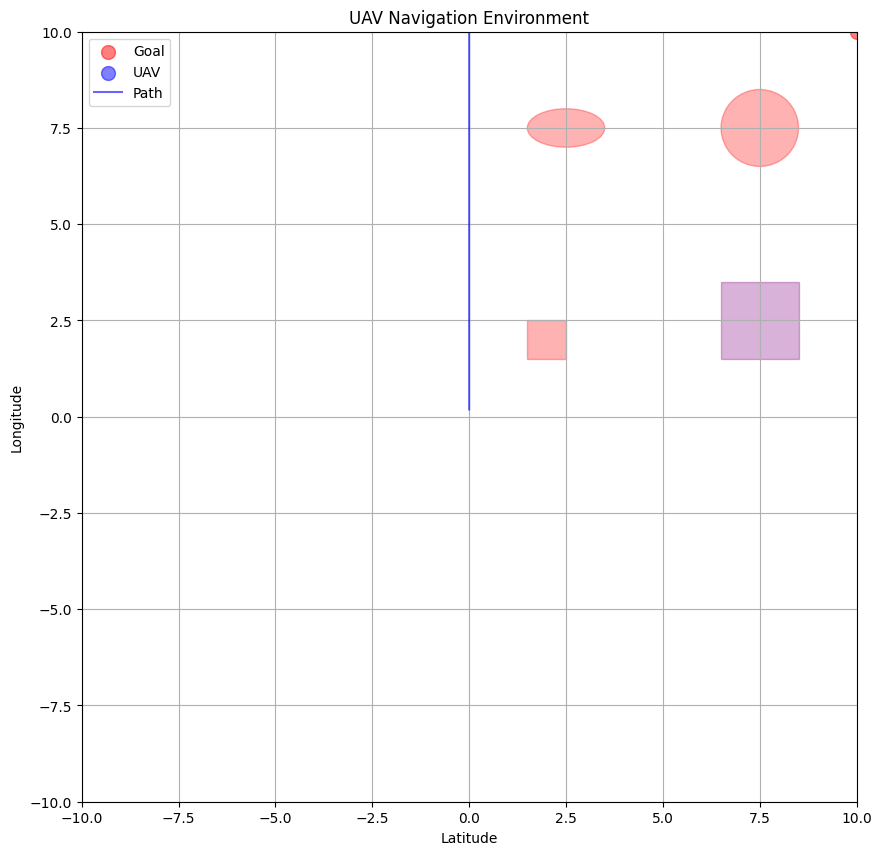

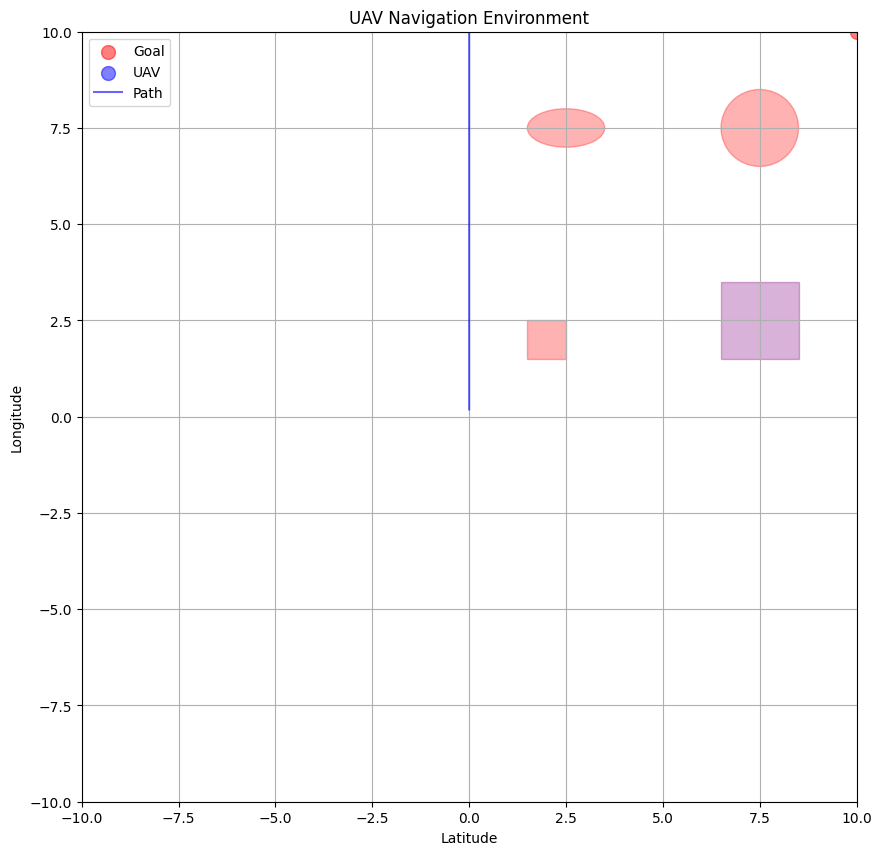

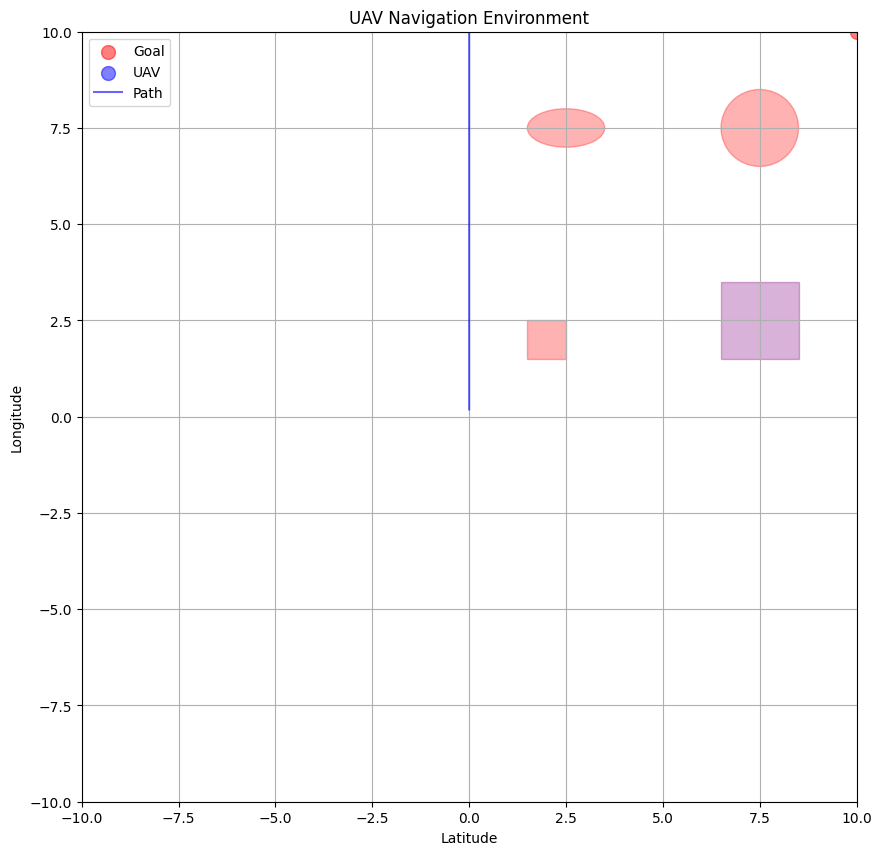

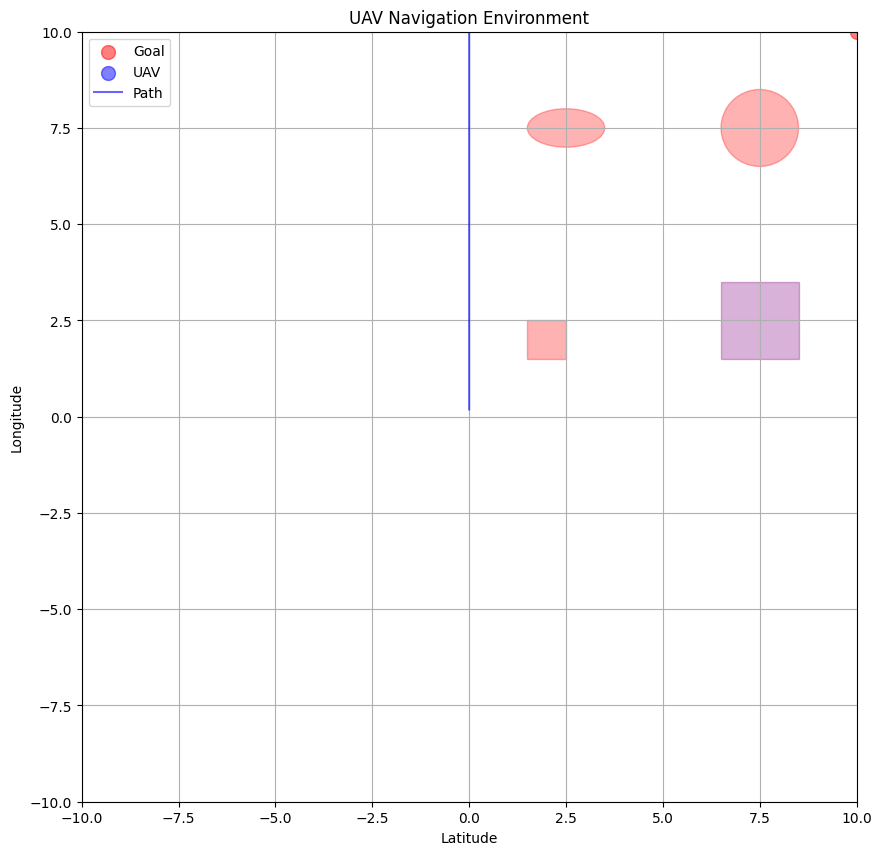

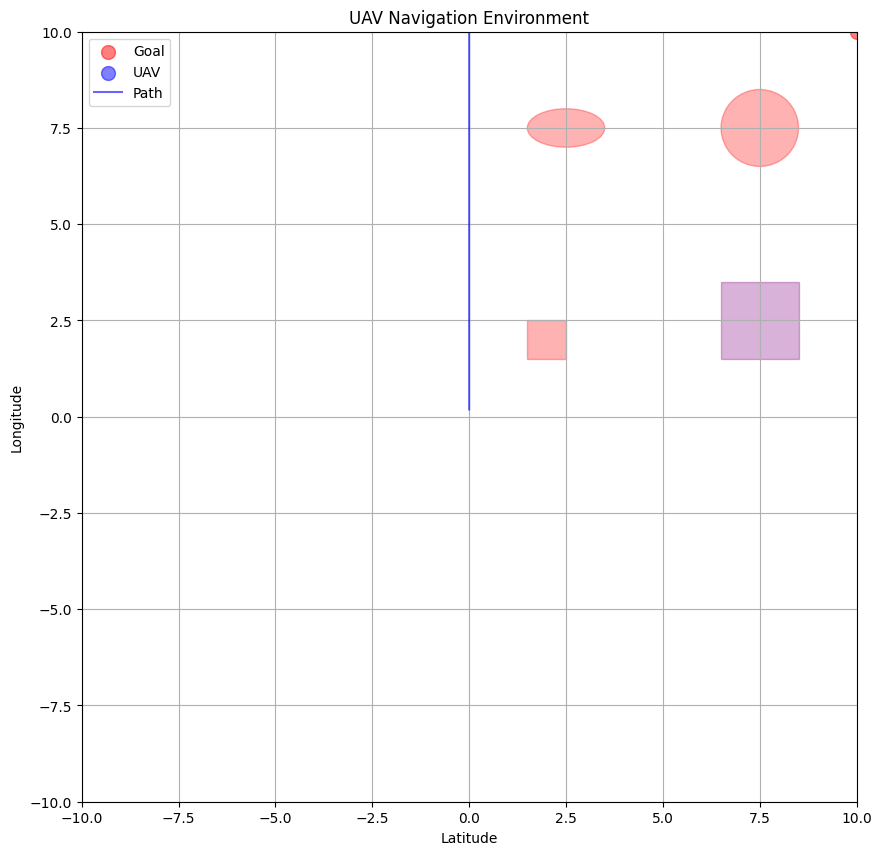

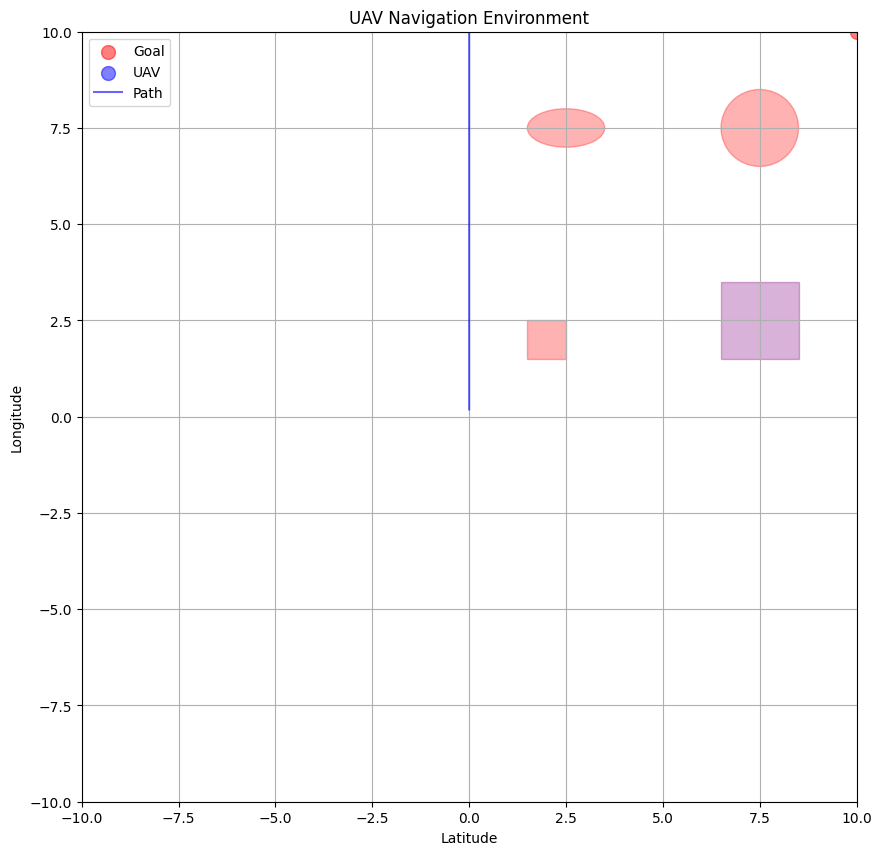

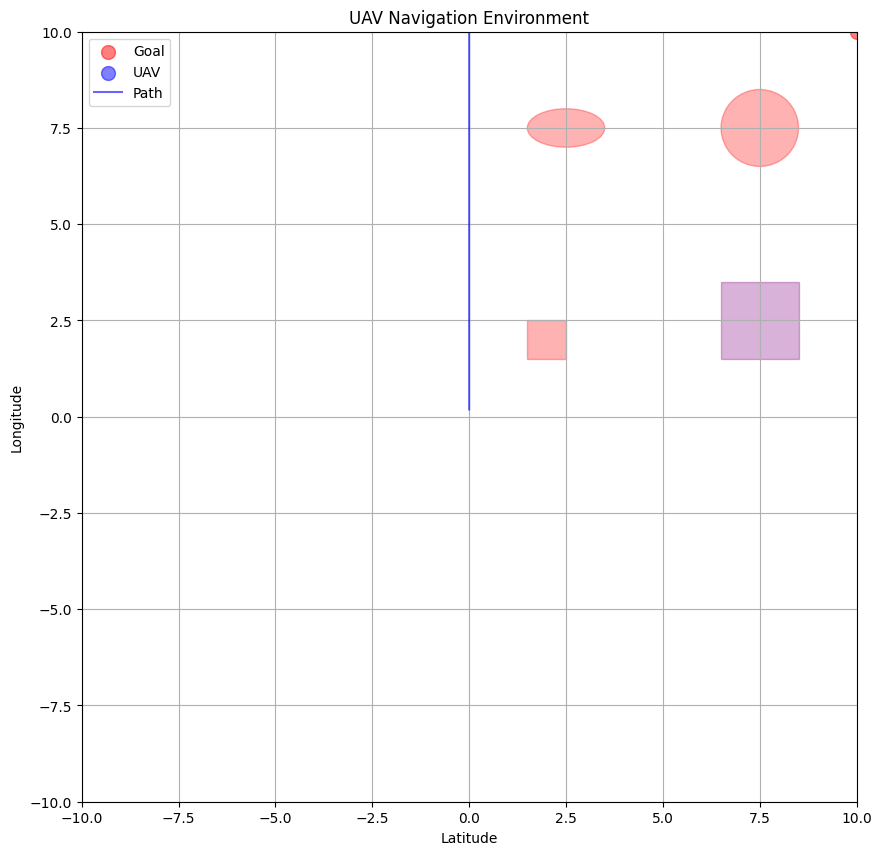

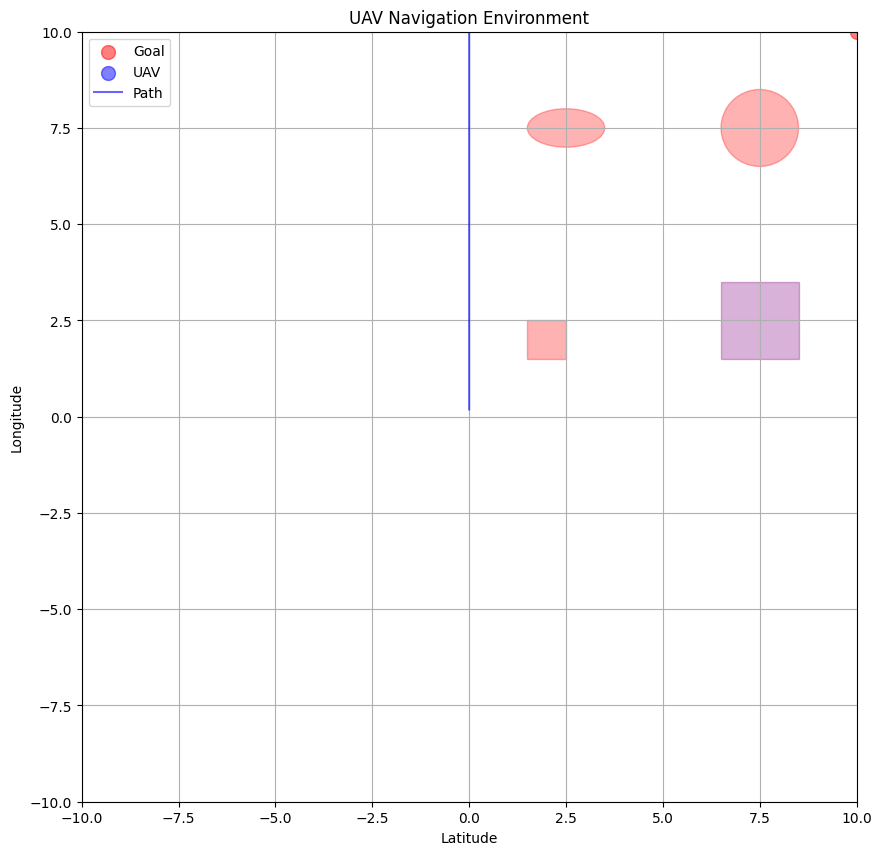

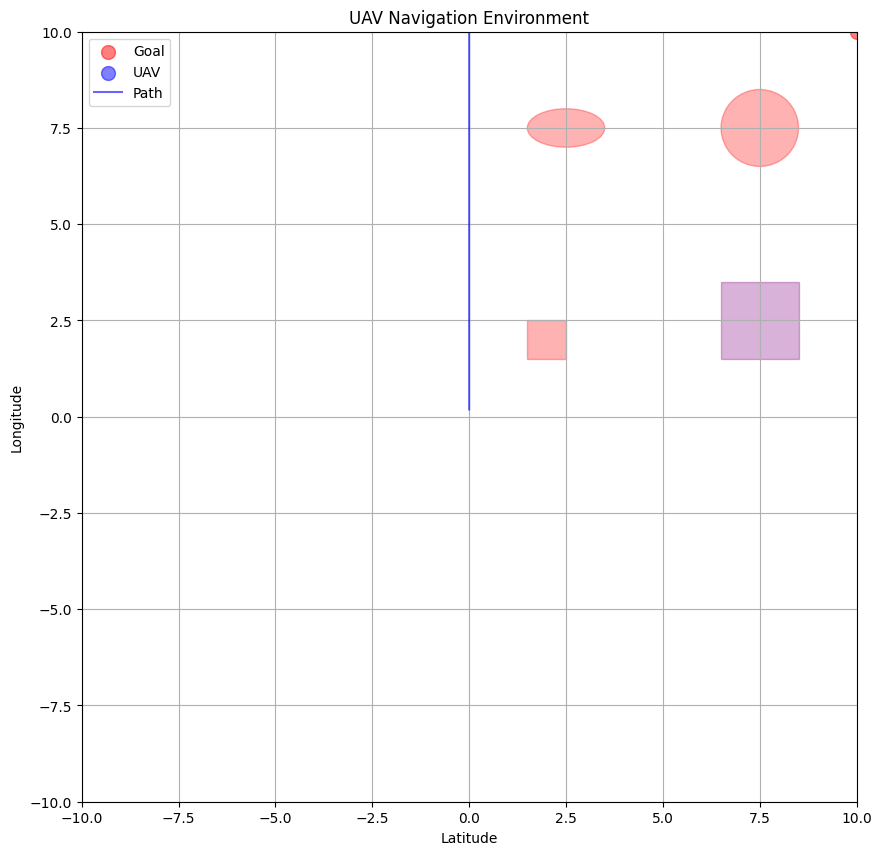

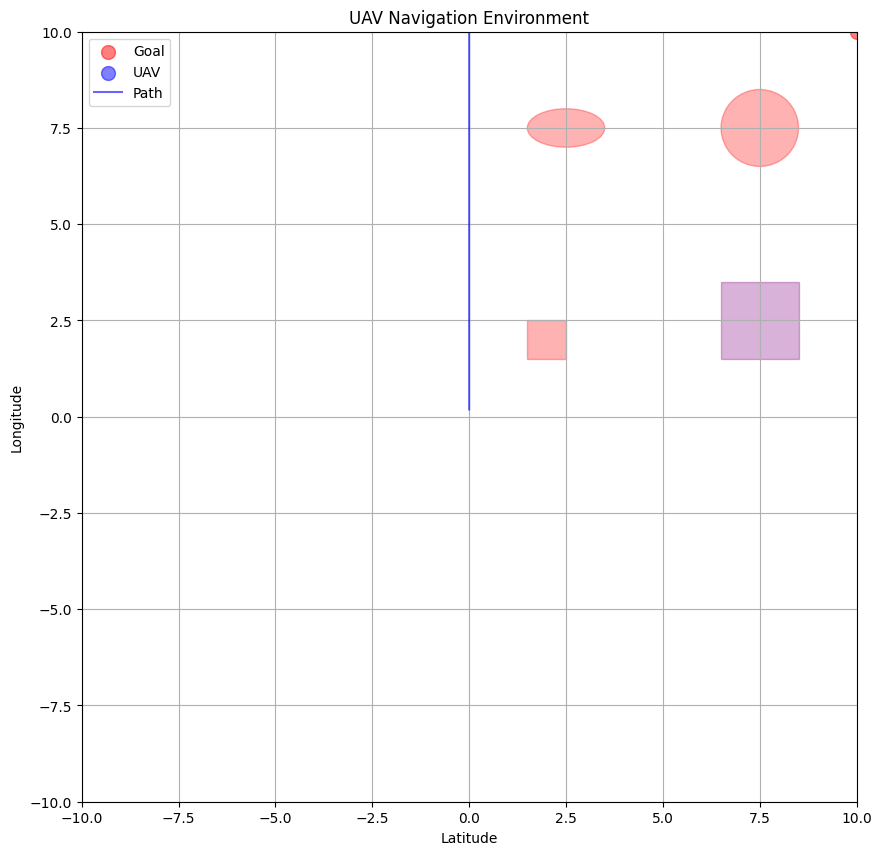

Goal reached!


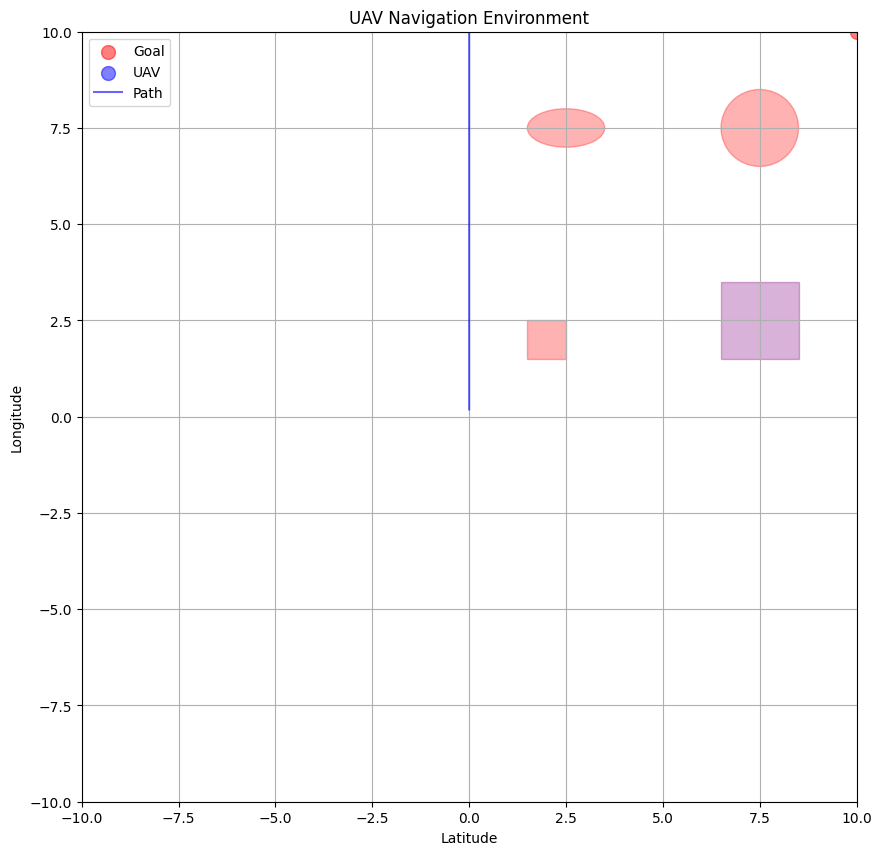

In [21]:
# Use trained q_network to act in environment and observe its behavior
def observe_behavior(env, q_network):
    state = env.reset()
    done = False
    while not done:
        q_values = q_network(np.expand_dims(state, axis=0))
        action = np.argmax(q_values)
        next_state, reward, done, _ = env.step(action)
        env.render()
        state = next_state

# Evaluate the trained model
evaluate_model(env, q_network)

# Observe the behavior of the trained model in the environment
observe_behavior(env, q_network)

In [69]:
def observe_behavior(env, q_network, max_steps=1000):
    state = env.reset()
    done = False
    positions = []
    while not done and len(positions) < max_steps:
        q_values = q_network(np.expand_dims(state, axis=0))
        action = np.argmax(q_values)
        next_state, reward, done, _ = env.step(action)
        positions.append(env.state[:2])  # Record position (latitude and longitude)
        state = next_state
    return positions

def plot_path(positions, goal_position):
    positions = np.array(positions)
    plt.figure(figsize=(10, 10))
    plt.plot(positions[:, 0], positions[:, 1], label='UAV Path', color='blue')
    plt.scatter(goal_position[0], goal_position[1], c='red', s=100, label='Goal')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Path of UAV reaching the goal')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_path(positions, goal_position, obstacles=None, no_fly_zones=None):
    """
    Plot the path taken by the UAV.

    Parameters:
    - positions (list): List of positions visited by the UAV.
    - goal_position (tuple): Tuple representing the goal position (latitude, longitude).
    - obstacles (list): List of obstacle dictionaries.
    - no_fly_zones (list): List of no-fly zone dictionaries.
    """
    # Extract latitude and longitude from the goal position
    goal_latitude, goal_longitude, _ = goal_position

    # Plot positions
    plt.plot([pos[0] for pos in positions], [pos[1] for pos in positions], label='UAV Path', color='blue')

    # Plot goal position
    plt.scatter(goal_latitude, goal_longitude, c='red', s=100, label='Goal', alpha=0.5)

    # Plot obstacles
    if obstacles:
        for obstacle in obstacles:
            obstacle_type = obstacle.get('type')
            obstacle_position = obstacle.get('position')
            if obstacle_type == 'rectangle':
                # Extract latitude and longitude from the position tuple
                obstacle_latitude, obstacle_longitude, _ = obstacle_position
                plt.scatter(obstacle_latitude, obstacle_longitude, c='gray', marker='x', label='Obstacle', alpha=0.5)
            elif obstacle_type == 'circle':
                # Extract latitude and longitude from the position tuple
                obstacle_latitude, obstacle_longitude, _ = obstacle_position
                plt.scatter(obstacle_latitude, obstacle_longitude, c='gray', marker='o', label='Obstacle', alpha=0.5)
            elif obstacle_type == 'ellipse':
                # Extract latitude and longitude from the position tuple
                obstacle_latitude, obstacle_longitude, _ = obstacle_position
                plt.scatter(obstacle_latitude, obstacle_longitude, c='gray', marker='^', label='Obstacle', alpha=0.5)

    # Plot no-fly zones
    if no_fly_zones:
        for zone in no_fly_zones:
            zone_type = zone.get('type')
            zone_position = zone.get('position')
            if zone_type == 'rectangle':
                # Extract latitude and longitude from the position tuple
                zone_latitude, zone_longitude, _ = zone_position
                plt.scatter(zone_latitude, zone_longitude, c='purple', marker='s', label='No-Fly Zone', alpha=0.5)
            elif zone_type == 'circle':
                # Extract latitude and longitude from the position tuple
                zone_latitude, zone_longitude, _ = zone_position
                plt.scatter(zone_latitude, zone_longitude, c='purple', marker='o', label='No-Fly Zone', alpha=0.5)

    # Axis labels and title
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('UAV Navigation Path')
    plt.legend()
    plt.grid(True)
    plt.show()



Goal reached!


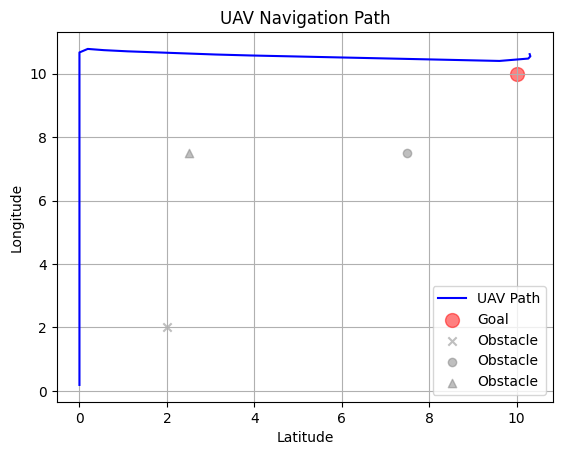

In [70]:
positions = observe_behavior(env, q_network)
plot_path(positions, env.goal_position, obstacles=env.obstacles)


**Training Both Algorithms together**

# PPO Model
# Creating a vectorized environment with 4 parallel environments
ppo_env = make_vec_env(lambda: UAVEnv(), n_envs=4)

# Initializing the PPO model with the MlpPolicy
ppo_model = PPO("MlpPolicy", 
                ppo_env, 
                learning_rate=0.0003805913356107848, 
                n_steps=64, 
                batch_size=32, 
                verbose=1)

# Training the PPO model
ppo_model.learn(total_timesteps=150000)

# Evaluating the trained PPO agent
ppo_mean_reward, _ = evaluate_policy(ppo_model, ppo_env, n_eval_episodes=20)
print(f"PPO Mean reward: {ppo_mean_reward}")

# Close the PPO environment when done
ppo_env.close()

# DDQN Model
# Set optimized hyperparameters
ddqn_learning_rate = 0.0005816786580355395
ddqn_batch_size = 128
ddqn_epsilon = 0.09940432873344196
ddqn_gamma = 0.9701913302399167

# Initialize environment and model with optimized parameters
ddqn_env = UAVEnv()
ddqn_num_actions = ddqn_env.action_space.n
ddqn_q_network = QNetwork(ddqn_num_actions)
ddqn_target_network = QNetwork(ddqn_num_actions)
ddqn_target_network.set_weights(ddqn_q_network.get_weights())

# Optimizer
ddqn_optimizer = tf.keras.optimizers.Adam(learning_rate=ddqn_learning_rate)

# Replay buffer and other setups
ddqn_replay_buffer = deque(maxlen=10000)
ddqn_total_steps = 0
ddqn_target_update_freq = 100
ddqn_num_episodes = 1000  # Number of episodes for extended training

# Training loop with optimized hyperparameters for DDQN
for ddqn_episode in range(ddqn_num_episodes):
    ddqn_state = ddqn_env.reset()
    ddqn_episode_reward = 0
    ddqn_done = False
    
    while not ddqn_done:
        if np.random.rand() < ddqn_epsilon:
            ddqn_action = np.random.randint(ddqn_num_actions)
        else:
            ddqn_q_values = ddqn_q_network(np.expand_dims(ddqn_state, axis=0))
            ddqn_action = np.argmax(ddqn_q_values)

        ddqn_next_state, ddqn_reward, ddqn_done, _ = ddqn_env.step(ddqn_action)
        ddqn_episode_reward += ddqn_reward

        ddqn_replay_buffer.append((ddqn_state, ddqn_action, ddqn_reward, ddqn_next_state, ddqn_done))
        ddqn_state = ddqn_next_state

        if len(ddqn_replay_buffer) >= ddqn_batch_size:
            ddqn_minibatch = random.sample(ddqn_replay_buffer, ddqn_batch_size)
            ddqn_states, ddqn_actions, ddqn_rewards, ddqn_next_states, ddqn_dones = zip(*ddqn_minibatch)

            ddqn_next_q_values = ddqn_target_network(np.array(ddqn_next_states))
            ddqn_max_next_q_values = np.max(ddqn_next_q_values, axis=1)
            ddqn_targets = np.array(ddqn_rewards) + (1 - np.array(ddqn_dones)) * ddqn_gamma * ddqn_max_next_q_values

            with tf.GradientTape() as ddqn_tape:
                ddqn_q_values = ddqn_q_network(np.array(ddqn_states))
                ddqn_selected_q_values = tf.reduce_sum(ddqn_q_values * tf.one_hot(ddqn_actions, ddqn_num_actions), axis=1)
                ddqn_loss = tf.reduce_mean(tf.square(ddqn_targets - ddqn_selected_q_values))
            ddqn_grads = ddqn_tape.gradient(ddqn_loss, ddqn_q_network.trainable_variables)
            ddqn_optimizer.apply_gradients(zip(ddqn_grads, ddqn_q_network.trainable_variables))

            if ddqn_total_steps % ddqn_target_update_freq == 0:
                ddqn_target_network.set_weights(ddqn_q_network.get_weights())

        ddqn_total_steps += 1

    print(f"DDQN Episode: {ddqn_episode}, Reward: {ddqn_episode_reward}")
